# Advanced Lane Finding Project

#### William Rifenburgh

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### Camera Calibration

The following cell calculates camera calibration parameters, undistorts the calibration images and saves them to the output_images folder. An example of an undistorted calibration image next to its original form is also plotted inline.

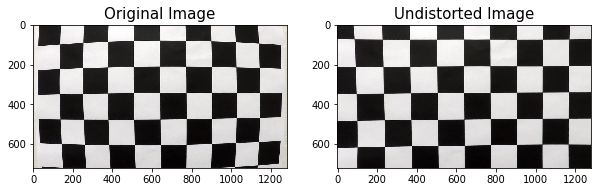

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

% matplotlib inline

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def undist_images(images):
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('./output_images/undist_' + fname.split('/')[-1], dst)

    img = cv2.imread(images[0])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(cv2.undistort(img, mtx, dist, None, mtx))
    ax2.set_title('Undistorted Image', fontsize=15)


undist_images(images)

### Undistort test images

The following cell will undistort all test images in the test_images directory, save them to the output_images folder and compare one image's original to its undistorted form.

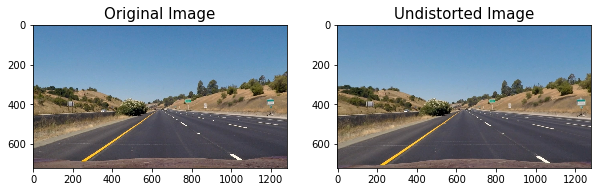

In [2]:
images = glob.glob('./test_images/*.jpg')

undist_images(images)

### Perspective Transformation

The following cells define the functions to perform a perspective transform to road images

---

The following cell allows us to preview where our source and destination points for the prototype of our perspective transformation will go. The red line polygon and cyan line polygon indicate the source and destination regions respectively. The coordinates for the source polygon were chosen to match the lane lines. The destination polygon was chosen to represent what would be a bird's eye view of the lanes.


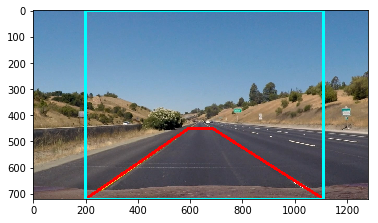

In [3]:
img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_size = (img.shape[1], img.shape[0])

src = np.float32([[200, img_size[1]], [1110, img_size[1]], [685, 450], [595, 450]])

img_src_lines = cv2.polylines(img, np.int32([src]), True, (255, 0, 0), thickness=10)
plt.imshow(img_src_lines)

dst = np.float32([[200, img_size[1]], [1110, img_size[1]], [1110, 0], [200, 0]])

img_dst_lines = cv2.polylines(img, np.int32([dst]), True, (0, 255, 255), thickness=10)
plt.imshow(img_dst_lines)

The following cell defines the function that will take the source and destinations we defined along with the camera calibration to undistort and perspective transform an image. The resulting bird's eye view image of this function performed on some of the test images is then plotted.

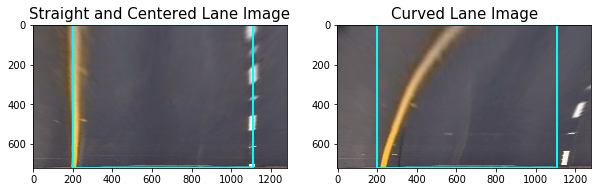

In [4]:
def undistort_and_transform(img, src, dst, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # and the inverse as well
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, M, Minv = undistort_and_transform(img, src, dst, mtx, dist)
warped_dst_lines = cv2.polylines(warped, np.int32([dst]), True, (0, 255, 255), thickness=10)

img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
warped, M, Minv = undistort_and_transform(img, src, dst, mtx, dist)
warped_dst_lines_curved = cv2.polylines(warped, np.int32([dst]), True, (0, 255, 255), thickness=10)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(warped_dst_lines)
ax1.set_title('Straight and Centered Lane Image', fontsize=15)
ax2.imshow(warped_dst_lines_curved)
ax2.set_title('Curved Lane Image', fontsize=15)

### Color and Gradient Thresholding

The following cell contains code for the function used to identify lane markings using thresholding of sobel x operator convolutions and HLS colorspace transforms. A result of thresholding is shown where the green indicates where x-gradient thresholding criteria were met and blue indicates where color lightness thresholding criteria was met.



True

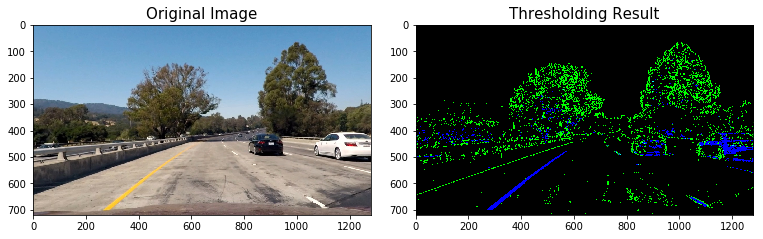

In [5]:
image = mpimg.imread('./output_images/undist_test1.jpg')

# Edit this function to create your own pipeline.
def threshold_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSL color space and separate the L channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
result, result_binary = threshold_image(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)


ax2.imshow(result)
ax2.set_title('Thresholding Result', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result = 255 * result.astype("uint8")
result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_images/colored_binary.jpg", result)

binary = 255 * result_binary.astype("uint8")
cv2.imwrite("./output_images/combined_binary.jpg", binary)

### Lane Line Polynomial Fitting

Below is an example of thresholding and perspective transforming a road image using the functions we have previously developed


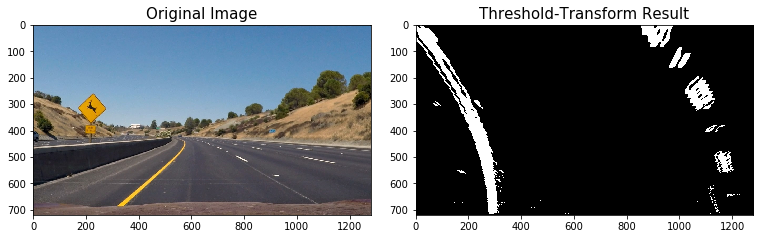

In [6]:
image = mpimg.imread('./test_images/test2.jpg')
result, result_binary = threshold_image(image)
warped, M, Minv = undistort_and_transform(result_binary, src, dst, mtx, dist)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=15)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Threshold-Transform Result', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The code cell below will plot a histogram of the bottom half of the binary, perspective transformed image. The  peaks indicate the x-position of both lane lines and where the find_polynomails function will begin its search for the lane lines.

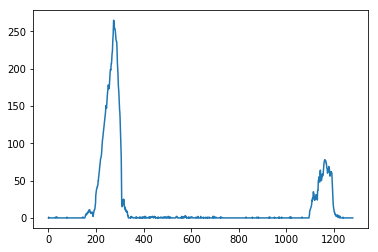

In [7]:
#Plot histogram of threshold-transform binary image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

The following cell defines the lane finding function which takes in a warped, binary image and fits polynomials to each lane marking side. The functions plotgraph option enables us to preview these lane line polynomials. The function find_curvature_and_offset is also defined beforehand so that it may be used in find_polynomials as much of its required arguments are caculated in the find_polynomials function.


left_curverad:  318.573161466  [m], right_curverad:  259.484867417  [m], offset_m:  0.0966507636163  [m]


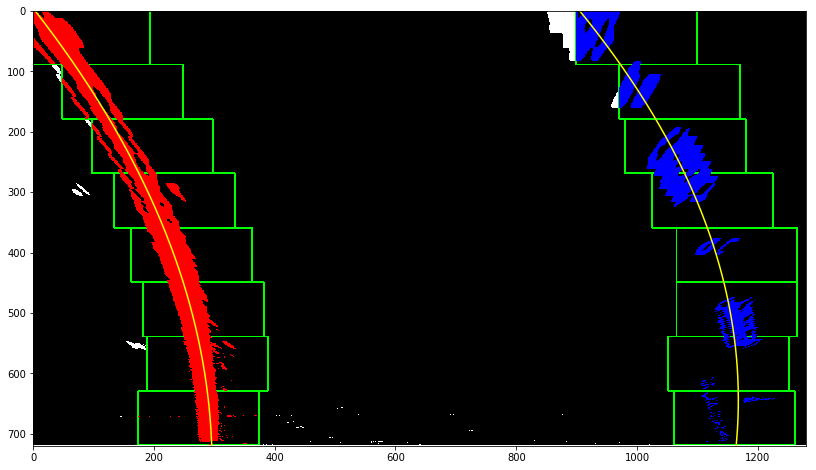

In [8]:
def find_curvature_and_offset(leftx, rightx, lefty, righty, img_height_pix, img_width_pix):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature at the base of the image (img_height_pix)
    left_curverad = ((1 + (2 * left_fit_cr[0] * img_height_pix * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = (
                         (1 + (
                         2 * right_fit_cr[0] * img_height_pix * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    img_height_m = img_height_pix * ym_per_pix
    img_width_m = img_width_pix * xm_per_pix

    left_intercept = np.polyval(left_fit_cr, img_height_m)
    right_intercept = np.polyval(right_fit_cr, img_width_m)

    center = (left_intercept + right_intercept) / 2.0

    offset_m = center - img_width_m / 2.0

    return left_curverad, right_curverad, offset_m

def find_polynomials(binary_warped, plotgraph=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if plotgraph:
        plt.figure(figsize=(16, 8))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    l_curverad, r_curverad, offset_m = find_curvature_and_offset(leftx, rightx, lefty, righty, binary_warped.shape[0],
                                                                 binary_warped.shape[1])

    return left_fit, right_fit, l_curverad, r_curverad, offset_m


left_fit, right_fit, left_curverad, right_curverad, vehicle_offset_m = find_polynomials(warped, True)

print('left_curverad: ',left_curverad, ' [m], right_curverad: ' , right_curverad, ' [m], offset_m: ' , vehicle_offset_m, ' [m]')

To help keep track of lane lines in sharp curves and challenging conditions as well as skip the windowing operations, we can use the polynomials found from the initial find_polynomials function to narrow our search to a region of interest around the previous polynomials for the next frame in a video. The next cell defines the function for this method. A plot showing the region of interest may be shown by setting plotgraph=True.

left_curverad:  318.284465766  [m], right_curverad:  216.412606797  [m], offset_m:  0.0811410231584  [m]


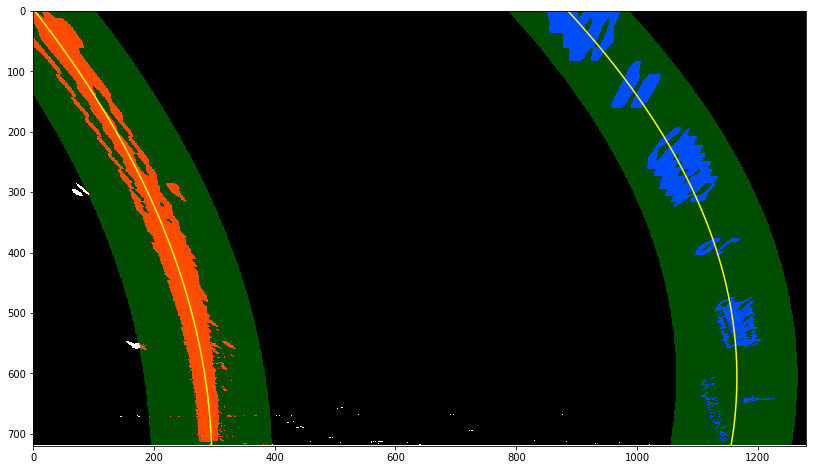

In [9]:
def find_polynomials_skip_windowing(binary_warped, left_fit, right_fit, plotgraph=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
    nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
    (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
    nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    if plotgraph:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(16, 8))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    l_curverad, r_curverad, offset_m = find_curvature_and_offset(leftx, rightx, lefty, righty, binary_warped.shape[0],
                                                                 binary_warped.shape[1])

    return left_fit, right_fit, l_curverad, r_curverad, offset_m

left_fit, right_fit, left_curverad, right_curverad, vehicle_offset_m = find_polynomials_skip_windowing(warped, left_fit,
                                                                                                       right_fit, True)

print('left_curverad: ',left_curverad, ' [m], right_curverad: ' , right_curverad, ' [m], offset_m: ' , vehicle_offset_m, ' [m]')

The following function draws the green overlay of what our algorithms perceive to be the lane as well as radius of curvature for the lanes and deviation off the center of the lane.

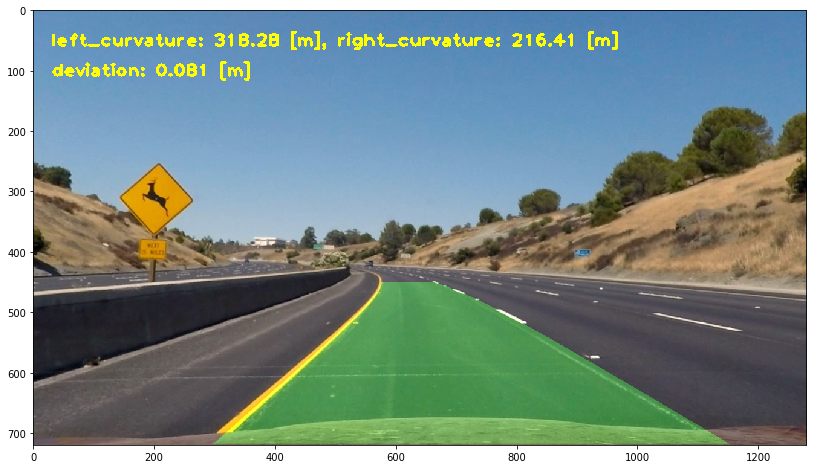

In [11]:
def draw_lane(undistorted_img, warped, left_fit, right_fit, minv, l_radius, r_radius, deviation_offset):
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minv, (undistorted_img.shape[1], undistorted_img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

    # Add Curvature and Deviation Text
    l_radius_txt = str(np.round(l_radius, 2))
    r_radius_txt = str(np.round(r_radius, 2))
    deviation_offset_txt = "{:.3f}".format(deviation_offset)
    font = cv2.FONT_HERSHEY_PLAIN
    curvature_txt = "left_curvature: " + l_radius_txt + " [m], right_curvature: " + r_radius_txt + " [m]"
    deviation_txt = "deviation: " + deviation_offset_txt + " [m]"
    cv2.putText(result, curvature_txt, (30, 60), font, 2, (255, 255, 0), 3)
    cv2.putText(result, deviation_txt, (30, 110), font, 2, (255, 255, 0), 3)
    
    return result

image = mpimg.imread('./test_images/test2.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
result = draw_lane(undist, warped, left_fit, right_fit, Minv, left_curverad, right_curverad, vehicle_offset_m)
plt.figure(figsize=(16, 8))
plt.imshow(result)

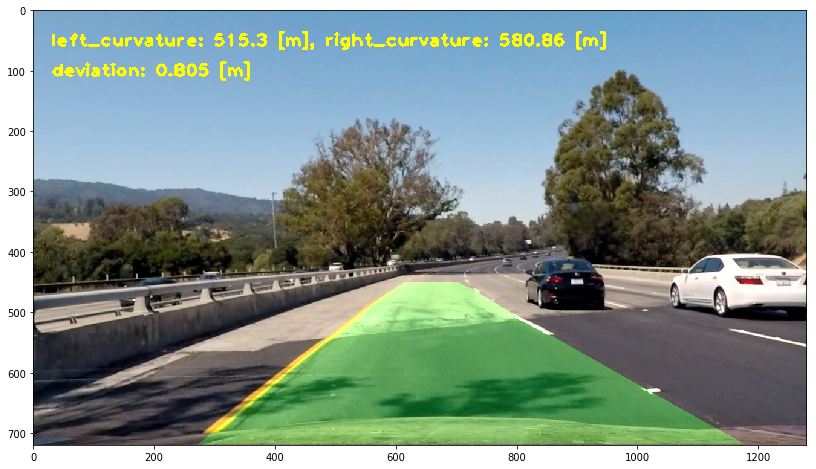

In [12]:
def process_image(image):    
    result, result_binary = threshold_image(image)
    warped, M, Minv = undistort_and_transform(result_binary, src, dst, mtx, dist)
    left_fit, right_fit, left_curverad, right_curverad, vehicle_offset_m = find_polynomials(warped, False)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    result = draw_lane(undist, warped, left_fit, right_fit, Minv, left_curverad, right_curverad, vehicle_offset_m)
    return result

image = mpimg.imread('./test_images/test4.jpg')
result = process_image(image)
plt.figure(figsize=(16, 8))
plt.imshow(result)

In [55]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = "./output_images/project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_output.mp4


[MoviePy] Writing video ./output_images/project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:30,  5.97it/s]

  0%|          | 2/1261 [00:00<03:28,  6.04it/s]

  0%|          | 3/1261 [00:00<03:32,  5.91it/s]

  0%|          | 4/1261 [00:00<03:31,  5.95it/s]

  0%|          | 5/1261 [00:00<03:37,  5.79it/s]

  0%|          | 6/1261 [00:01<03:37,  5.77it/s]

  1%|          | 7/1261 [00:01<03:37,  5.77it/s]

  1%|          | 8/1261 [00:01<03:35,  5.82it/s]

  1%|          | 9/1261 [00:01<03:29,  5.98it/s]

  1%|          | 10/1261 [00:01<03:28,  5.99it/s]

  1%|          | 11/1261 [00:01<03:27,  6.02it/s]

  1%|          | 12/1261 [00:02<03:30,  5.95it/s]

  1%|          | 13/1261 [00:02<03:25,  6.07it/s]

  1%|          | 14/1261 [00:02<03:22,  6.15it/s]

  1%|          | 15/1261 [00:02<03:22,  6.16it/s]

  1%|▏         | 16/1261 [00:02<03:20,  6.21it/s]

  1%|▏         | 17/1261 [00:02<03:19,  6.25it/s]

  1%|▏         | 18/1261 [00:02<03:17,  6.30it/s]

  2%|▏         | 19/1261 [00:03<03:16,  6.33it/s]

  2%|▏         | 20/1261 [00:03<03:18,  6.26it/s]

  2%|▏         | 21/1261 [00:03<03:19,  6.21it/s]

  2%|▏         | 22/1261 [00:03<03:18,  6.23it/s]

  2%|▏         | 23/1261 [00:03<03:23,  6.08it/s]

  2%|▏         | 24/1261 [00:03<03:26,  6.00it/s]

  2%|▏         | 25/1261 [00:04<03:28,  5.92it/s]

  2%|▏         | 26/1261 [00:04<03:29,  5.90it/s]

  2%|▏         | 27/1261 [00:04<03:34,  5.76it/s]

  2%|▏         | 28/1261 [00:04<03:30,  5.87it/s]

  2%|▏         | 29/1261 [00:04<03:27,  5.95it/s]

  2%|▏         | 30/1261 [00:04<03:21,  6.10it/s]

  2%|▏         | 31/1261 [00:05<03:19,  6.15it/s]

  3%|▎         | 32/1261 [00:05<03:18,  6.18it/s]

  3%|▎         | 33/1261 [00:05<03:18,  6.18it/s]

  3%|▎         | 34/1261 [00:05<03:17,  6.21it/s]

  3%|▎         | 35/1261 [00:05<03:16,  6.24it/s]

  3%|▎         | 36/1261 [00:05<03:16,  6.24it/s]

  3%|▎         | 37/1261 [00:06<03:18,  6.18it/s]

  3%|▎         | 38/1261 [00:06<03:16,  6.23it/s]

  3%|▎         | 39/1261 [00:06<03:23,  6.01it/s]

  3%|▎         | 40/1261 [00:06<03:21,  6.06it/s]

  3%|▎         | 41/1261 [00:06<03:18,  6.16it/s]

  3%|▎         | 42/1261 [00:06<03:14,  6.28it/s]

  3%|▎         | 43/1261 [00:07<03:14,  6.27it/s]

  3%|▎         | 44/1261 [00:07<03:14,  6.26it/s]

  4%|▎         | 45/1261 [00:07<03:11,  6.34it/s]

  4%|▎         | 46/1261 [00:07<03:10,  6.38it/s]

  4%|▎         | 47/1261 [00:07<03:09,  6.42it/s]

  4%|▍         | 48/1261 [00:07<03:08,  6.45it/s]

  4%|▍         | 49/1261 [00:07<03:07,  6.47it/s]

  4%|▍         | 50/1261 [00:08<03:07,  6.47it/s]

  4%|▍         | 51/1261 [00:08<03:10,  6.36it/s]

  4%|▍         | 52/1261 [00:08<03:15,  6.17it/s]

  4%|▍         | 53/1261 [00:08<03:15,  6.18it/s]

  4%|▍         | 54/1261 [00:08<03:13,  6.24it/s]

  4%|▍         | 55/1261 [00:08<03:10,  6.34it/s]

  4%|▍         | 56/1261 [00:09<03:07,  6.42it/s]

  5%|▍         | 57/1261 [00:09<03:07,  6.41it/s]

  5%|▍         | 58/1261 [00:09<03:06,  6.44it/s]

  5%|▍         | 59/1261 [00:09<03:07,  6.41it/s]

  5%|▍         | 60/1261 [00:09<03:05,  6.46it/s]

  5%|▍         | 61/1261 [00:09<03:05,  6.48it/s]

  5%|▍         | 62/1261 [00:10<03:05,  6.47it/s]

  5%|▍         | 63/1261 [00:10<03:05,  6.46it/s]

  5%|▌         | 64/1261 [00:10<03:07,  6.39it/s]

  5%|▌         | 65/1261 [00:10<03:05,  6.45it/s]

  5%|▌         | 66/1261 [00:10<03:06,  6.39it/s]

  5%|▌         | 67/1261 [00:10<03:16,  6.08it/s]

  5%|▌         | 68/1261 [00:11<03:15,  6.10it/s]

  5%|▌         | 69/1261 [00:11<03:13,  6.16it/s]

  6%|▌         | 70/1261 [00:11<03:12,  6.19it/s]

  6%|▌         | 71/1261 [00:11<03:10,  6.25it/s]

  6%|▌         | 72/1261 [00:11<03:09,  6.28it/s]

  6%|▌         | 73/1261 [00:11<03:09,  6.26it/s]

  6%|▌         | 74/1261 [00:11<03:08,  6.31it/s]

  6%|▌         | 75/1261 [00:12<03:07,  6.31it/s]

  6%|▌         | 76/1261 [00:12<03:06,  6.36it/s]

  6%|▌         | 77/1261 [00:12<03:06,  6.33it/s]

  6%|▌         | 78/1261 [00:12<03:08,  6.26it/s]

  6%|▋         | 79/1261 [00:12<03:09,  6.25it/s]

  6%|▋         | 80/1261 [00:12<03:08,  6.25it/s]

  6%|▋         | 81/1261 [00:13<03:11,  6.15it/s]

  7%|▋         | 82/1261 [00:13<03:20,  5.89it/s]

  7%|▋         | 83/1261 [00:13<03:19,  5.90it/s]

  7%|▋         | 84/1261 [00:13<03:17,  5.97it/s]

  7%|▋         | 85/1261 [00:13<03:13,  6.08it/s]

  7%|▋         | 86/1261 [00:13<03:11,  6.15it/s]

  7%|▋         | 87/1261 [00:14<03:09,  6.19it/s]

  7%|▋         | 88/1261 [00:14<03:07,  6.25it/s]

  7%|▋         | 89/1261 [00:14<03:06,  6.27it/s]

  7%|▋         | 90/1261 [00:14<03:04,  6.33it/s]

  7%|▋         | 91/1261 [00:14<03:05,  6.30it/s]

  7%|▋         | 92/1261 [00:14<03:05,  6.31it/s]

  7%|▋         | 93/1261 [00:15<03:05,  6.31it/s]

  7%|▋         | 94/1261 [00:15<03:06,  6.25it/s]

  8%|▊         | 95/1261 [00:15<03:04,  6.31it/s]

  8%|▊         | 96/1261 [00:15<03:11,  6.07it/s]

  8%|▊         | 97/1261 [00:15<03:21,  5.78it/s]

  8%|▊         | 98/1261 [00:15<03:20,  5.79it/s]

  8%|▊         | 99/1261 [00:16<03:15,  5.96it/s]

  8%|▊         | 100/1261 [00:16<03:11,  6.05it/s]

  8%|▊         | 101/1261 [00:16<03:07,  6.17it/s]

  8%|▊         | 102/1261 [00:16<03:08,  6.14it/s]

  8%|▊         | 103/1261 [00:16<03:07,  6.16it/s]

  8%|▊         | 104/1261 [00:16<03:09,  6.10it/s]

  8%|▊         | 105/1261 [00:17<03:08,  6.12it/s]

  8%|▊         | 106/1261 [00:17<03:07,  6.16it/s]

  8%|▊         | 107/1261 [00:17<03:07,  6.15it/s]

  9%|▊         | 108/1261 [00:17<03:11,  6.02it/s]

  9%|▊         | 109/1261 [00:17<03:31,  5.45it/s]

  9%|▊         | 110/1261 [00:17<03:38,  5.27it/s]

  9%|▉         | 111/1261 [00:18<03:40,  5.21it/s]

  9%|▉         | 112/1261 [00:18<03:35,  5.34it/s]

  9%|▉         | 113/1261 [00:18<03:30,  5.45it/s]

  9%|▉         | 114/1261 [00:18<03:29,  5.48it/s]

  9%|▉         | 115/1261 [00:18<03:28,  5.49it/s]

  9%|▉         | 116/1261 [00:19<03:20,  5.71it/s]

  9%|▉         | 117/1261 [00:19<03:15,  5.85it/s]

  9%|▉         | 118/1261 [00:19<03:11,  5.97it/s]

  9%|▉         | 119/1261 [00:19<03:07,  6.10it/s]

 10%|▉         | 120/1261 [00:19<03:05,  6.15it/s]

 10%|▉         | 121/1261 [00:19<03:04,  6.19it/s]

 10%|▉         | 122/1261 [00:19<03:10,  5.99it/s]

 10%|▉         | 123/1261 [00:20<03:07,  6.08it/s]

 10%|▉         | 124/1261 [00:20<03:13,  5.89it/s]

 10%|▉         | 125/1261 [00:20<03:24,  5.56it/s]

 10%|▉         | 126/1261 [00:20<03:23,  5.57it/s]

 10%|█         | 127/1261 [00:20<03:21,  5.62it/s]

 10%|█         | 128/1261 [00:21<03:22,  5.60it/s]

 10%|█         | 129/1261 [00:21<03:20,  5.64it/s]

 10%|█         | 130/1261 [00:21<03:20,  5.65it/s]

 10%|█         | 131/1261 [00:21<03:20,  5.63it/s]

 10%|█         | 132/1261 [00:21<03:18,  5.70it/s]

 11%|█         | 133/1261 [00:21<03:16,  5.73it/s]

 11%|█         | 134/1261 [00:22<03:14,  5.81it/s]

 11%|█         | 135/1261 [00:22<03:08,  5.96it/s]

 11%|█         | 136/1261 [00:22<03:06,  6.05it/s]

 11%|█         | 137/1261 [00:22<03:02,  6.15it/s]

 11%|█         | 138/1261 [00:22<03:11,  5.88it/s]

 11%|█         | 139/1261 [00:22<03:23,  5.52it/s]

 11%|█         | 140/1261 [00:23<03:21,  5.56it/s]

 11%|█         | 141/1261 [00:23<03:23,  5.50it/s]

 11%|█▏        | 142/1261 [00:23<03:19,  5.62it/s]

 11%|█▏        | 143/1261 [00:23<03:14,  5.74it/s]

 11%|█▏        | 144/1261 [00:23<03:09,  5.88it/s]

 11%|█▏        | 145/1261 [00:23<03:07,  5.97it/s]

 12%|█▏        | 146/1261 [00:24<03:04,  6.06it/s]

 12%|█▏        | 147/1261 [00:24<03:04,  6.05it/s]

 12%|█▏        | 148/1261 [00:24<03:03,  6.07it/s]

 12%|█▏        | 149/1261 [00:24<03:04,  6.04it/s]

 12%|█▏        | 150/1261 [00:24<03:03,  6.06it/s]

 12%|█▏        | 151/1261 [00:24<03:04,  6.02it/s]

 12%|█▏        | 152/1261 [00:25<03:09,  5.85it/s]

 12%|█▏        | 153/1261 [00:25<03:18,  5.58it/s]

 12%|█▏        | 154/1261 [00:25<03:52,  4.75it/s]

 12%|█▏        | 155/1261 [00:25<03:41,  4.98it/s]

 12%|█▏        | 156/1261 [00:25<03:32,  5.20it/s]

 12%|█▏        | 157/1261 [00:26<03:29,  5.28it/s]

 13%|█▎        | 158/1261 [00:26<03:22,  5.44it/s]

 13%|█▎        | 159/1261 [00:26<03:19,  5.52it/s]

 13%|█▎        | 160/1261 [00:26<03:19,  5.51it/s]

 13%|█▎        | 161/1261 [00:26<03:20,  5.50it/s]

 13%|█▎        | 162/1261 [00:27<03:19,  5.50it/s]

 13%|█▎        | 163/1261 [00:27<03:18,  5.52it/s]

 13%|█▎        | 164/1261 [00:27<03:13,  5.67it/s]

 13%|█▎        | 165/1261 [00:27<03:12,  5.69it/s]

 13%|█▎        | 166/1261 [00:27<03:16,  5.57it/s]

 13%|█▎        | 167/1261 [00:27<03:14,  5.62it/s]

 13%|█▎        | 168/1261 [00:28<03:17,  5.54it/s]

 13%|█▎        | 169/1261 [00:28<03:08,  5.78it/s]

 13%|█▎        | 170/1261 [00:28<03:06,  5.85it/s]

 14%|█▎        | 171/1261 [00:28<03:03,  5.94it/s]

 14%|█▎        | 172/1261 [00:28<03:36,  5.03it/s]

 14%|█▎        | 173/1261 [00:29<03:25,  5.28it/s]

 14%|█▍        | 174/1261 [00:29<03:21,  5.38it/s]

 14%|█▍        | 175/1261 [00:29<03:20,  5.43it/s]

 14%|█▍        | 176/1261 [00:29<03:14,  5.58it/s]

 14%|█▍        | 177/1261 [00:29<03:07,  5.79it/s]

 14%|█▍        | 178/1261 [00:29<03:04,  5.88it/s]

 14%|█▍        | 179/1261 [00:30<03:04,  5.88it/s]

 14%|█▍        | 180/1261 [00:30<03:03,  5.88it/s]

 14%|█▍        | 181/1261 [00:30<03:15,  5.53it/s]

 14%|█▍        | 182/1261 [00:30<03:27,  5.19it/s]

 15%|█▍        | 183/1261 [00:30<03:17,  5.45it/s]

 15%|█▍        | 184/1261 [00:31<03:21,  5.35it/s]

 15%|█▍        | 185/1261 [00:31<03:17,  5.46it/s]

 15%|█▍        | 186/1261 [00:31<03:14,  5.51it/s]

 15%|█▍        | 187/1261 [00:31<03:12,  5.57it/s]

 15%|█▍        | 188/1261 [00:31<03:18,  5.39it/s]

 15%|█▍        | 189/1261 [00:31<03:14,  5.51it/s]

 15%|█▌        | 190/1261 [00:32<03:13,  5.53it/s]

 15%|█▌        | 191/1261 [00:32<03:18,  5.39it/s]

 15%|█▌        | 192/1261 [00:32<03:13,  5.54it/s]

 15%|█▌        | 193/1261 [00:32<03:05,  5.77it/s]

 15%|█▌        | 194/1261 [00:32<02:58,  5.98it/s]

 15%|█▌        | 195/1261 [00:32<02:55,  6.08it/s]

 16%|█▌        | 196/1261 [00:33<02:56,  6.05it/s]

 16%|█▌        | 197/1261 [00:33<02:52,  6.15it/s]

 16%|█▌        | 198/1261 [00:33<02:53,  6.12it/s]

 16%|█▌        | 199/1261 [00:33<02:51,  6.19it/s]

 16%|█▌        | 200/1261 [00:33<02:51,  6.19it/s]

 16%|█▌        | 201/1261 [00:33<02:54,  6.06it/s]

 16%|█▌        | 202/1261 [00:34<03:00,  5.85it/s]

 16%|█▌        | 203/1261 [00:34<03:08,  5.63it/s]

 16%|█▌        | 204/1261 [00:34<03:04,  5.72it/s]

 16%|█▋        | 205/1261 [00:34<03:00,  5.86it/s]

 16%|█▋        | 206/1261 [00:34<02:56,  5.98it/s]

 16%|█▋        | 207/1261 [00:34<02:54,  6.06it/s]

 16%|█▋        | 208/1261 [00:35<02:52,  6.09it/s]

 17%|█▋        | 209/1261 [00:35<02:51,  6.12it/s]

 17%|█▋        | 210/1261 [00:35<02:51,  6.14it/s]

 17%|█▋        | 211/1261 [00:35<02:51,  6.13it/s]

 17%|█▋        | 212/1261 [00:35<02:52,  6.07it/s]

 17%|█▋        | 213/1261 [00:35<02:50,  6.16it/s]

 17%|█▋        | 214/1261 [00:36<02:51,  6.12it/s]

 17%|█▋        | 215/1261 [00:36<02:50,  6.14it/s]

 17%|█▋        | 216/1261 [00:36<02:53,  6.03it/s]

 17%|█▋        | 217/1261 [00:36<03:02,  5.71it/s]

 17%|█▋        | 218/1261 [00:36<03:06,  5.60it/s]

 17%|█▋        | 219/1261 [00:37<03:24,  5.08it/s]

 17%|█▋        | 220/1261 [00:37<03:18,  5.25it/s]

 18%|█▊        | 221/1261 [00:37<03:08,  5.53it/s]

 18%|█▊        | 222/1261 [00:37<03:02,  5.69it/s]

 18%|█▊        | 223/1261 [00:37<02:56,  5.87it/s]

 18%|█▊        | 224/1261 [00:37<02:55,  5.90it/s]

 18%|█▊        | 225/1261 [00:38<02:52,  5.99it/s]

 18%|█▊        | 226/1261 [00:38<02:52,  6.01it/s]

 18%|█▊        | 227/1261 [00:38<02:49,  6.11it/s]

 18%|█▊        | 228/1261 [00:38<02:50,  6.07it/s]

 18%|█▊        | 229/1261 [00:38<02:46,  6.19it/s]

 18%|█▊        | 230/1261 [00:38<02:52,  5.97it/s]

 18%|█▊        | 231/1261 [00:39<03:02,  5.63it/s]

 18%|█▊        | 232/1261 [00:39<03:06,  5.52it/s]

 18%|█▊        | 233/1261 [00:39<03:05,  5.54it/s]

 19%|█▊        | 234/1261 [00:39<03:23,  5.05it/s]

 19%|█▊        | 235/1261 [00:39<03:15,  5.25it/s]

 19%|█▊        | 236/1261 [00:39<03:06,  5.49it/s]

 19%|█▉        | 237/1261 [00:40<03:01,  5.64it/s]

 19%|█▉        | 238/1261 [00:40<02:56,  5.80it/s]

 19%|█▉        | 239/1261 [00:40<02:53,  5.90it/s]

 19%|█▉        | 240/1261 [00:40<02:50,  6.00it/s]

 19%|█▉        | 241/1261 [00:40<03:02,  5.59it/s]

 19%|█▉        | 242/1261 [00:41<03:00,  5.64it/s]

 19%|█▉        | 243/1261 [00:41<03:05,  5.48it/s]

 19%|█▉        | 244/1261 [00:41<03:06,  5.47it/s]

 19%|█▉        | 245/1261 [00:41<03:11,  5.31it/s]

 20%|█▉        | 246/1261 [00:41<03:08,  5.37it/s]

 20%|█▉        | 247/1261 [00:41<03:04,  5.51it/s]

 20%|█▉        | 248/1261 [00:42<02:59,  5.65it/s]

 20%|█▉        | 249/1261 [00:42<03:06,  5.42it/s]

 20%|█▉        | 250/1261 [00:42<03:22,  4.99it/s]

 20%|█▉        | 251/1261 [00:42<03:11,  5.27it/s]

 20%|█▉        | 252/1261 [00:42<03:04,  5.48it/s]

 20%|██        | 253/1261 [00:43<02:56,  5.72it/s]

 20%|██        | 254/1261 [00:43<02:52,  5.84it/s]

 20%|██        | 255/1261 [00:43<02:46,  6.04it/s]

 20%|██        | 256/1261 [00:43<02:46,  6.04it/s]

 20%|██        | 257/1261 [00:43<02:50,  5.89it/s]

 20%|██        | 258/1261 [00:43<03:01,  5.54it/s]

 21%|██        | 259/1261 [00:44<02:59,  5.60it/s]

 21%|██        | 260/1261 [00:44<02:59,  5.59it/s]

 21%|██        | 261/1261 [00:44<03:07,  5.32it/s]

 21%|██        | 262/1261 [00:44<03:03,  5.43it/s]

 21%|██        | 263/1261 [00:44<03:00,  5.54it/s]

 21%|██        | 264/1261 [00:45<03:00,  5.51it/s]

 21%|██        | 265/1261 [00:45<03:01,  5.47it/s]

 21%|██        | 266/1261 [00:45<03:00,  5.52it/s]

 21%|██        | 267/1261 [00:45<02:53,  5.72it/s]

 21%|██▏       | 268/1261 [00:45<02:50,  5.83it/s]

 21%|██▏       | 269/1261 [00:45<02:48,  5.90it/s]

 21%|██▏       | 270/1261 [00:46<02:49,  5.86it/s]

 21%|██▏       | 271/1261 [00:46<02:53,  5.70it/s]

 22%|██▏       | 272/1261 [00:46<03:04,  5.37it/s]

 22%|██▏       | 273/1261 [00:46<03:02,  5.41it/s]

 22%|██▏       | 274/1261 [00:46<03:11,  5.16it/s]

 22%|██▏       | 275/1261 [00:47<03:25,  4.81it/s]

 22%|██▏       | 276/1261 [00:47<03:12,  5.11it/s]

 22%|██▏       | 277/1261 [00:47<03:04,  5.33it/s]

 22%|██▏       | 278/1261 [00:47<03:00,  5.45it/s]

 22%|██▏       | 279/1261 [00:47<02:53,  5.67it/s]

 22%|██▏       | 280/1261 [00:47<02:50,  5.77it/s]

 22%|██▏       | 281/1261 [00:48<02:45,  5.92it/s]

 22%|██▏       | 282/1261 [00:48<02:45,  5.91it/s]

 22%|██▏       | 283/1261 [00:48<02:45,  5.92it/s]

 23%|██▎       | 284/1261 [00:48<02:48,  5.79it/s]

 23%|██▎       | 285/1261 [00:48<03:03,  5.31it/s]

 23%|██▎       | 286/1261 [00:48<03:04,  5.28it/s]

 23%|██▎       | 287/1261 [00:49<03:03,  5.30it/s]

 23%|██▎       | 288/1261 [00:49<03:01,  5.35it/s]

 23%|██▎       | 289/1261 [00:49<02:57,  5.47it/s]

 23%|██▎       | 290/1261 [00:49<02:53,  5.59it/s]

 23%|██▎       | 291/1261 [00:49<02:54,  5.56it/s]

 23%|██▎       | 292/1261 [00:50<02:51,  5.64it/s]

 23%|██▎       | 293/1261 [00:50<03:26,  4.70it/s]

 23%|██▎       | 294/1261 [00:50<03:15,  4.96it/s]

 23%|██▎       | 295/1261 [00:50<03:10,  5.07it/s]

 23%|██▎       | 296/1261 [00:50<03:07,  5.15it/s]

 24%|██▎       | 297/1261 [00:51<03:05,  5.19it/s]

 24%|██▎       | 298/1261 [00:51<03:03,  5.26it/s]

 24%|██▎       | 299/1261 [00:51<02:57,  5.42it/s]

 24%|██▍       | 300/1261 [00:51<02:52,  5.57it/s]

 24%|██▍       | 301/1261 [00:51<02:49,  5.68it/s]

 24%|██▍       | 302/1261 [00:51<02:47,  5.72it/s]

 24%|██▍       | 303/1261 [00:52<02:47,  5.71it/s]

 24%|██▍       | 304/1261 [00:52<02:47,  5.73it/s]

 24%|██▍       | 305/1261 [00:52<02:43,  5.84it/s]

 24%|██▍       | 306/1261 [00:52<02:41,  5.93it/s]

 24%|██▍       | 307/1261 [00:52<02:41,  5.90it/s]

 24%|██▍       | 308/1261 [00:52<02:40,  5.93it/s]

 25%|██▍       | 309/1261 [00:53<02:38,  6.00it/s]

 25%|██▍       | 310/1261 [00:53<02:40,  5.94it/s]

 25%|██▍       | 311/1261 [00:53<02:45,  5.73it/s]

 25%|██▍       | 312/1261 [00:53<02:49,  5.58it/s]

 25%|██▍       | 313/1261 [00:53<02:52,  5.50it/s]

 25%|██▍       | 314/1261 [00:54<03:01,  5.20it/s]

 25%|██▍       | 315/1261 [00:54<02:59,  5.28it/s]

 25%|██▌       | 316/1261 [00:54<02:50,  5.55it/s]

 25%|██▌       | 317/1261 [00:54<02:47,  5.63it/s]

 25%|██▌       | 318/1261 [00:54<02:44,  5.73it/s]

 25%|██▌       | 319/1261 [00:54<02:47,  5.62it/s]

 25%|██▌       | 320/1261 [00:55<02:48,  5.59it/s]

 25%|██▌       | 321/1261 [00:55<02:55,  5.36it/s]

 26%|██▌       | 322/1261 [00:55<02:54,  5.39it/s]

 26%|██▌       | 323/1261 [00:55<02:48,  5.57it/s]

 26%|██▌       | 324/1261 [00:55<02:48,  5.55it/s]

 26%|██▌       | 325/1261 [00:56<02:52,  5.42it/s]

 26%|██▌       | 326/1261 [00:56<02:50,  5.47it/s]

 26%|██▌       | 327/1261 [00:56<02:43,  5.70it/s]

 26%|██▌       | 328/1261 [00:56<02:44,  5.67it/s]

 26%|██▌       | 329/1261 [00:56<02:41,  5.77it/s]

 26%|██▌       | 330/1261 [00:56<02:41,  5.77it/s]

 26%|██▌       | 331/1261 [00:57<02:38,  5.86it/s]

 26%|██▋       | 332/1261 [00:57<02:37,  5.92it/s]

 26%|██▋       | 333/1261 [00:57<02:36,  5.94it/s]

 26%|██▋       | 334/1261 [00:57<02:40,  5.78it/s]

 27%|██▋       | 335/1261 [00:57<02:42,  5.70it/s]

 27%|██▋       | 336/1261 [00:57<02:44,  5.63it/s]

 27%|██▋       | 337/1261 [00:58<02:48,  5.50it/s]

 27%|██▋       | 338/1261 [00:58<02:50,  5.42it/s]

 27%|██▋       | 339/1261 [00:58<02:52,  5.33it/s]

 27%|██▋       | 340/1261 [00:58<02:59,  5.14it/s]

 27%|██▋       | 341/1261 [00:58<02:52,  5.34it/s]

 27%|██▋       | 342/1261 [00:59<02:46,  5.51it/s]

 27%|██▋       | 343/1261 [00:59<02:44,  5.57it/s]

 27%|██▋       | 344/1261 [00:59<02:40,  5.71it/s]

 27%|██▋       | 345/1261 [00:59<02:37,  5.80it/s]

 27%|██▋       | 346/1261 [00:59<02:36,  5.84it/s]

 28%|██▊       | 347/1261 [00:59<02:34,  5.91it/s]

 28%|██▊       | 348/1261 [01:00<02:32,  5.97it/s]

 28%|██▊       | 349/1261 [01:00<02:31,  6.03it/s]

 28%|██▊       | 350/1261 [01:00<02:33,  5.94it/s]

 28%|██▊       | 351/1261 [01:00<02:35,  5.85it/s]

 28%|██▊       | 352/1261 [01:00<02:44,  5.54it/s]

 28%|██▊       | 353/1261 [01:00<02:43,  5.56it/s]

 28%|██▊       | 354/1261 [01:01<02:54,  5.20it/s]

 28%|██▊       | 355/1261 [01:01<03:11,  4.73it/s]

 28%|██▊       | 356/1261 [01:01<03:01,  4.97it/s]

 28%|██▊       | 357/1261 [01:01<02:57,  5.10it/s]

 28%|██▊       | 358/1261 [01:02<02:50,  5.29it/s]

 28%|██▊       | 359/1261 [01:02<02:43,  5.52it/s]

 29%|██▊       | 360/1261 [01:02<02:40,  5.61it/s]

 29%|██▊       | 361/1261 [01:02<02:36,  5.77it/s]

 29%|██▊       | 362/1261 [01:02<02:31,  5.92it/s]

 29%|██▉       | 363/1261 [01:02<02:30,  5.98it/s]

 29%|██▉       | 364/1261 [01:02<02:30,  5.95it/s]

 29%|██▉       | 365/1261 [01:03<02:35,  5.77it/s]

 29%|██▉       | 366/1261 [01:03<02:40,  5.57it/s]

 29%|██▉       | 367/1261 [01:03<02:40,  5.55it/s]

 29%|██▉       | 368/1261 [01:03<02:41,  5.53it/s]

 29%|██▉       | 369/1261 [01:03<02:41,  5.53it/s]

 29%|██▉       | 370/1261 [01:04<02:38,  5.62it/s]

 29%|██▉       | 371/1261 [01:04<02:35,  5.72it/s]

 30%|██▉       | 372/1261 [01:04<02:35,  5.70it/s]

 30%|██▉       | 373/1261 [01:04<02:32,  5.81it/s]

 30%|██▉       | 374/1261 [01:04<02:34,  5.76it/s]

 30%|██▉       | 375/1261 [01:04<02:31,  5.85it/s]

 30%|██▉       | 376/1261 [01:05<02:31,  5.84it/s]

 30%|██▉       | 377/1261 [01:05<02:29,  5.90it/s]

 30%|██▉       | 378/1261 [01:05<02:29,  5.93it/s]

 30%|███       | 379/1261 [01:05<02:33,  5.76it/s]

 30%|███       | 380/1261 [01:05<02:40,  5.50it/s]

 30%|███       | 381/1261 [01:06<02:37,  5.58it/s]

 30%|███       | 382/1261 [01:06<02:35,  5.65it/s]

 30%|███       | 383/1261 [01:06<02:32,  5.75it/s]

 30%|███       | 384/1261 [01:06<02:28,  5.90it/s]

 31%|███       | 385/1261 [01:06<02:28,  5.90it/s]

 31%|███       | 386/1261 [01:06<02:26,  5.95it/s]

 31%|███       | 387/1261 [01:07<02:27,  5.94it/s]

 31%|███       | 388/1261 [01:07<02:27,  5.93it/s]

 31%|███       | 389/1261 [01:07<02:26,  5.97it/s]

 31%|███       | 390/1261 [01:07<02:25,  5.97it/s]

 31%|███       | 391/1261 [01:07<02:24,  6.03it/s]

 31%|███       | 392/1261 [01:07<02:23,  6.07it/s]

 31%|███       | 393/1261 [01:08<02:30,  5.79it/s]

 31%|███       | 394/1261 [01:08<02:39,  5.43it/s]

 31%|███▏      | 395/1261 [01:08<02:39,  5.42it/s]

 31%|███▏      | 396/1261 [01:08<02:37,  5.50it/s]

 31%|███▏      | 397/1261 [01:08<02:34,  5.61it/s]

 32%|███▏      | 398/1261 [01:08<02:34,  5.59it/s]

 32%|███▏      | 399/1261 [01:09<02:32,  5.65it/s]

 32%|███▏      | 400/1261 [01:09<02:30,  5.71it/s]

 32%|███▏      | 401/1261 [01:09<02:26,  5.86it/s]

 32%|███▏      | 402/1261 [01:09<02:25,  5.90it/s]

 32%|███▏      | 403/1261 [01:09<02:22,  6.01it/s]

 32%|███▏      | 404/1261 [01:09<02:21,  6.07it/s]

 32%|███▏      | 405/1261 [01:10<02:21,  6.05it/s]

 32%|███▏      | 406/1261 [01:10<02:25,  5.89it/s]

 32%|███▏      | 407/1261 [01:10<02:31,  5.62it/s]

 32%|███▏      | 408/1261 [01:10<02:41,  5.28it/s]

 32%|███▏      | 409/1261 [01:10<02:56,  4.83it/s]

 33%|███▎      | 410/1261 [01:11<02:55,  4.85it/s]

 33%|███▎      | 411/1261 [01:11<02:51,  4.97it/s]

 33%|███▎      | 412/1261 [01:11<02:43,  5.19it/s]

 33%|███▎      | 413/1261 [01:11<02:37,  5.39it/s]

 33%|███▎      | 414/1261 [01:11<02:31,  5.60it/s]

 33%|███▎      | 415/1261 [01:11<02:27,  5.75it/s]

 33%|███▎      | 416/1261 [01:12<02:24,  5.85it/s]

 33%|███▎      | 417/1261 [01:12<02:22,  5.93it/s]

 33%|███▎      | 418/1261 [01:12<02:20,  5.98it/s]

 33%|███▎      | 419/1261 [01:12<02:23,  5.89it/s]

 33%|███▎      | 420/1261 [01:12<02:23,  5.86it/s]

 33%|███▎      | 421/1261 [01:13<02:26,  5.74it/s]

 33%|███▎      | 422/1261 [01:13<02:24,  5.80it/s]

 34%|███▎      | 423/1261 [01:13<02:26,  5.70it/s]

 34%|███▎      | 424/1261 [01:13<02:26,  5.71it/s]

 34%|███▎      | 425/1261 [01:13<02:30,  5.56it/s]

 34%|███▍      | 426/1261 [01:13<02:34,  5.42it/s]

 34%|███▍      | 427/1261 [01:14<02:33,  5.45it/s]

 34%|███▍      | 428/1261 [01:14<02:28,  5.60it/s]

 34%|███▍      | 429/1261 [01:14<02:28,  5.61it/s]

 34%|███▍      | 430/1261 [01:14<02:23,  5.79it/s]

 34%|███▍      | 431/1261 [01:14<02:22,  5.84it/s]

 34%|███▍      | 432/1261 [01:14<02:19,  5.95it/s]

 34%|███▍      | 433/1261 [01:15<02:19,  5.95it/s]

 34%|███▍      | 434/1261 [01:15<02:18,  5.99it/s]

 34%|███▍      | 435/1261 [01:15<02:16,  6.05it/s]

 35%|███▍      | 436/1261 [01:15<02:16,  6.06it/s]

 35%|███▍      | 437/1261 [01:15<02:19,  5.90it/s]

 35%|███▍      | 438/1261 [01:15<02:23,  5.73it/s]

 35%|███▍      | 439/1261 [01:16<02:25,  5.64it/s]

 35%|███▍      | 440/1261 [01:16<02:31,  5.43it/s]

 35%|███▍      | 441/1261 [01:16<02:31,  5.40it/s]

 35%|███▌      | 442/1261 [01:16<02:31,  5.42it/s]

 35%|███▌      | 443/1261 [01:16<02:28,  5.50it/s]

 35%|███▌      | 444/1261 [01:17<02:27,  5.53it/s]

 35%|███▌      | 445/1261 [01:17<02:27,  5.54it/s]

 35%|███▌      | 446/1261 [01:17<02:24,  5.63it/s]

 35%|███▌      | 447/1261 [01:17<02:23,  5.69it/s]

 36%|███▌      | 448/1261 [01:17<02:21,  5.73it/s]

 36%|███▌      | 449/1261 [01:17<02:17,  5.89it/s]

 36%|███▌      | 450/1261 [01:18<02:15,  5.97it/s]

 36%|███▌      | 451/1261 [01:18<02:14,  6.01it/s]

 36%|███▌      | 452/1261 [01:18<02:12,  6.09it/s]

 36%|███▌      | 453/1261 [01:18<02:15,  5.97it/s]

 36%|███▌      | 454/1261 [01:18<02:23,  5.62it/s]

 36%|███▌      | 455/1261 [01:18<02:24,  5.56it/s]

 36%|███▌      | 456/1261 [01:19<02:25,  5.54it/s]

 36%|███▌      | 457/1261 [01:19<02:25,  5.51it/s]

 36%|███▋      | 458/1261 [01:19<02:22,  5.62it/s]

 36%|███▋      | 459/1261 [01:19<02:25,  5.53it/s]

 36%|███▋      | 460/1261 [01:19<02:23,  5.58it/s]

 37%|███▋      | 461/1261 [01:20<02:23,  5.56it/s]

 37%|███▋      | 462/1261 [01:20<02:22,  5.60it/s]

 37%|███▋      | 463/1261 [01:20<02:23,  5.55it/s]

 37%|███▋      | 464/1261 [01:20<02:19,  5.71it/s]

 37%|███▋      | 465/1261 [01:20<02:28,  5.37it/s]

 37%|███▋      | 466/1261 [01:21<02:42,  4.90it/s]

 37%|███▋      | 467/1261 [01:21<02:41,  4.93it/s]

 37%|███▋      | 468/1261 [01:21<02:40,  4.94it/s]

 37%|███▋      | 469/1261 [01:21<02:55,  4.52it/s]

 37%|███▋      | 470/1261 [01:21<02:44,  4.82it/s]

 37%|███▋      | 471/1261 [01:22<02:34,  5.12it/s]

 37%|███▋      | 472/1261 [01:22<02:26,  5.38it/s]

 38%|███▊      | 473/1261 [01:22<02:20,  5.59it/s]

 38%|███▊      | 474/1261 [01:22<02:18,  5.69it/s]

 38%|███▊      | 475/1261 [01:22<02:17,  5.72it/s]

 38%|███▊      | 476/1261 [01:22<02:15,  5.77it/s]

 38%|███▊      | 477/1261 [01:23<02:14,  5.84it/s]

 38%|███▊      | 478/1261 [01:23<02:12,  5.91it/s]

 38%|███▊      | 479/1261 [01:23<02:10,  6.01it/s]

 38%|███▊      | 480/1261 [01:23<02:41,  4.83it/s]

 38%|███▊      | 481/1261 [01:23<02:40,  4.85it/s]

 38%|███▊      | 482/1261 [01:24<02:36,  4.96it/s]

 38%|███▊      | 483/1261 [01:24<02:29,  5.19it/s]

 38%|███▊      | 484/1261 [01:24<02:21,  5.48it/s]

 38%|███▊      | 485/1261 [01:24<02:17,  5.64it/s]

 39%|███▊      | 486/1261 [01:24<02:14,  5.77it/s]

 39%|███▊      | 487/1261 [01:24<02:15,  5.73it/s]

 39%|███▊      | 488/1261 [01:25<02:16,  5.65it/s]

 39%|███▉      | 489/1261 [01:25<02:17,  5.63it/s]

 39%|███▉      | 490/1261 [01:25<02:17,  5.60it/s]

 39%|███▉      | 491/1261 [01:25<02:17,  5.61it/s]

 39%|███▉      | 492/1261 [01:25<02:13,  5.75it/s]

 39%|███▉      | 493/1261 [01:25<02:15,  5.68it/s]

 39%|███▉      | 494/1261 [01:26<02:20,  5.48it/s]

 39%|███▉      | 495/1261 [01:26<02:21,  5.41it/s]

 39%|███▉      | 496/1261 [01:26<02:23,  5.32it/s]

 39%|███▉      | 497/1261 [01:26<02:22,  5.37it/s]

 39%|███▉      | 498/1261 [01:26<02:18,  5.52it/s]

 40%|███▉      | 499/1261 [01:27<02:14,  5.65it/s]

 40%|███▉      | 500/1261 [01:27<02:12,  5.75it/s]

 40%|███▉      | 501/1261 [01:27<02:08,  5.89it/s]

 40%|███▉      | 502/1261 [01:27<02:08,  5.92it/s]

 40%|███▉      | 503/1261 [01:27<02:11,  5.75it/s]

 40%|███▉      | 504/1261 [01:27<02:12,  5.70it/s]

 40%|████      | 505/1261 [01:28<02:15,  5.59it/s]

 40%|████      | 506/1261 [01:28<02:15,  5.56it/s]

 40%|████      | 507/1261 [01:28<02:18,  5.45it/s]

 40%|████      | 508/1261 [01:28<02:22,  5.29it/s]

 40%|████      | 509/1261 [01:28<02:22,  5.27it/s]

 40%|████      | 510/1261 [01:29<02:22,  5.26it/s]

 41%|████      | 511/1261 [01:29<02:18,  5.40it/s]

 41%|████      | 512/1261 [01:29<02:17,  5.45it/s]

 41%|████      | 513/1261 [01:29<02:13,  5.61it/s]

 41%|████      | 514/1261 [01:29<02:12,  5.64it/s]

 41%|████      | 515/1261 [01:29<02:12,  5.61it/s]

 41%|████      | 516/1261 [01:30<02:13,  5.57it/s]

 41%|████      | 517/1261 [01:30<02:13,  5.59it/s]

 41%|████      | 518/1261 [01:30<02:11,  5.67it/s]

 41%|████      | 519/1261 [01:30<02:24,  5.15it/s]

 41%|████      | 520/1261 [01:30<02:24,  5.14it/s]

 41%|████▏     | 521/1261 [01:31<02:26,  5.06it/s]

 41%|████▏     | 522/1261 [01:31<02:24,  5.12it/s]

 41%|████▏     | 523/1261 [01:31<02:20,  5.24it/s]

 42%|████▏     | 524/1261 [01:31<02:17,  5.35it/s]

 42%|████▏     | 525/1261 [01:31<02:16,  5.41it/s]

 42%|████▏     | 526/1261 [01:32<02:14,  5.46it/s]

 42%|████▏     | 527/1261 [01:32<02:14,  5.44it/s]

 42%|████▏     | 528/1261 [01:32<02:14,  5.47it/s]

 42%|████▏     | 529/1261 [01:32<02:07,  5.72it/s]

 42%|████▏     | 530/1261 [01:32<02:04,  5.86it/s]

 42%|████▏     | 531/1261 [01:32<02:01,  6.03it/s]

 42%|████▏     | 532/1261 [01:33<01:59,  6.09it/s]

 42%|████▏     | 533/1261 [01:33<01:56,  6.25it/s]

 42%|████▏     | 534/1261 [01:33<02:00,  6.02it/s]

 42%|████▏     | 535/1261 [01:33<02:06,  5.73it/s]

 43%|████▎     | 536/1261 [01:33<02:05,  5.76it/s]

 43%|████▎     | 537/1261 [01:33<02:04,  5.84it/s]

 43%|████▎     | 538/1261 [01:34<02:09,  5.59it/s]

 43%|████▎     | 539/1261 [01:34<02:04,  5.81it/s]

 43%|████▎     | 540/1261 [01:34<01:58,  6.10it/s]

 43%|████▎     | 541/1261 [01:34<01:55,  6.23it/s]

 43%|████▎     | 542/1261 [01:34<01:55,  6.21it/s]

 43%|████▎     | 543/1261 [01:34<01:55,  6.21it/s]

 43%|████▎     | 544/1261 [01:35<01:57,  6.11it/s]

 43%|████▎     | 545/1261 [01:35<01:57,  6.08it/s]

 43%|████▎     | 546/1261 [01:35<01:56,  6.11it/s]

 43%|████▎     | 547/1261 [01:35<02:00,  5.93it/s]

 43%|████▎     | 548/1261 [01:35<01:58,  6.02it/s]

 44%|████▎     | 549/1261 [01:35<02:01,  5.85it/s]

 44%|████▎     | 550/1261 [01:36<02:02,  5.79it/s]

 44%|████▎     | 551/1261 [01:36<02:05,  5.66it/s]

 44%|████▍     | 552/1261 [01:36<02:05,  5.65it/s]

 44%|████▍     | 553/1261 [01:36<02:02,  5.77it/s]

 44%|████▍     | 554/1261 [01:36<01:58,  5.97it/s]

 44%|████▍     | 555/1261 [01:36<01:56,  6.04it/s]

 44%|████▍     | 556/1261 [01:37<01:54,  6.14it/s]

 44%|████▍     | 557/1261 [01:37<01:52,  6.24it/s]

 44%|████▍     | 558/1261 [01:37<02:00,  5.83it/s]

 44%|████▍     | 559/1261 [01:37<02:11,  5.33it/s]

 44%|████▍     | 560/1261 [01:37<02:03,  5.69it/s]

 44%|████▍     | 561/1261 [01:37<01:56,  6.03it/s]

 45%|████▍     | 562/1261 [01:38<01:52,  6.22it/s]

 45%|████▍     | 563/1261 [01:38<01:56,  6.00it/s]

 45%|████▍     | 564/1261 [01:38<01:54,  6.10it/s]

 45%|████▍     | 565/1261 [01:38<01:52,  6.18it/s]

 45%|████▍     | 566/1261 [01:38<01:52,  6.18it/s]

 45%|████▍     | 567/1261 [01:38<01:51,  6.21it/s]

 45%|████▌     | 568/1261 [01:39<01:52,  6.18it/s]

 45%|████▌     | 569/1261 [01:39<01:50,  6.25it/s]

 45%|████▌     | 570/1261 [01:39<02:02,  5.65it/s]

 45%|████▌     | 571/1261 [01:39<02:02,  5.64it/s]

 45%|████▌     | 572/1261 [01:39<01:57,  5.88it/s]

 45%|████▌     | 573/1261 [01:39<01:52,  6.11it/s]

 46%|████▌     | 574/1261 [01:40<01:49,  6.26it/s]

 46%|████▌     | 575/1261 [01:40<01:46,  6.46it/s]

 46%|████▌     | 576/1261 [01:40<01:45,  6.52it/s]

 46%|████▌     | 577/1261 [01:40<01:44,  6.55it/s]

 46%|████▌     | 578/1261 [01:40<01:48,  6.29it/s]

 46%|████▌     | 579/1261 [01:40<01:47,  6.33it/s]

 46%|████▌     | 580/1261 [01:40<01:45,  6.43it/s]

 46%|████▌     | 581/1261 [01:41<01:46,  6.40it/s]

 46%|████▌     | 582/1261 [01:41<01:43,  6.54it/s]

 46%|████▌     | 583/1261 [01:41<01:42,  6.64it/s]

 46%|████▋     | 584/1261 [01:41<01:40,  6.76it/s]

 46%|████▋     | 585/1261 [01:41<01:40,  6.75it/s]

 46%|████▋     | 586/1261 [01:41<01:39,  6.80it/s]

 47%|████▋     | 587/1261 [01:42<01:39,  6.80it/s]

 47%|████▋     | 588/1261 [01:42<01:39,  6.73it/s]

 47%|████▋     | 589/1261 [01:42<01:39,  6.74it/s]

 47%|████▋     | 590/1261 [01:42<01:49,  6.15it/s]

 47%|████▋     | 591/1261 [01:42<02:01,  5.52it/s]

 47%|████▋     | 592/1261 [01:42<01:57,  5.70it/s]

 47%|████▋     | 593/1261 [01:43<01:57,  5.68it/s]

 47%|████▋     | 594/1261 [01:43<01:55,  5.76it/s]

 47%|████▋     | 595/1261 [01:43<01:58,  5.61it/s]

 47%|████▋     | 596/1261 [01:43<02:05,  5.31it/s]

 47%|████▋     | 597/1261 [01:43<01:58,  5.59it/s]

 47%|████▋     | 598/1261 [01:43<01:54,  5.80it/s]

 48%|████▊     | 599/1261 [01:44<01:49,  6.04it/s]

 48%|████▊     | 600/1261 [01:44<01:47,  6.14it/s]

 48%|████▊     | 601/1261 [01:44<01:46,  6.23it/s]

 48%|████▊     | 602/1261 [01:44<01:43,  6.39it/s]

 48%|████▊     | 603/1261 [01:44<01:41,  6.46it/s]

 48%|████▊     | 604/1261 [01:44<01:41,  6.47it/s]

 48%|████▊     | 605/1261 [01:45<01:40,  6.54it/s]

 48%|████▊     | 606/1261 [01:45<01:40,  6.53it/s]

 48%|████▊     | 607/1261 [01:45<01:41,  6.43it/s]

 48%|████▊     | 608/1261 [01:45<01:47,  6.08it/s]

 48%|████▊     | 609/1261 [01:45<01:48,  5.99it/s]

 48%|████▊     | 610/1261 [01:45<01:49,  5.95it/s]

 48%|████▊     | 611/1261 [01:46<01:49,  5.93it/s]

 49%|████▊     | 612/1261 [01:46<01:49,  5.91it/s]

 49%|████▊     | 613/1261 [01:46<01:47,  6.04it/s]

 49%|████▊     | 614/1261 [01:46<01:45,  6.11it/s]

 49%|████▉     | 615/1261 [01:46<01:47,  6.03it/s]

 49%|████▉     | 616/1261 [01:46<01:47,  6.00it/s]

 49%|████▉     | 617/1261 [01:47<01:48,  5.95it/s]

 49%|████▉     | 618/1261 [01:47<01:49,  5.86it/s]

 49%|████▉     | 619/1261 [01:47<01:47,  5.98it/s]

 49%|████▉     | 620/1261 [01:47<01:45,  6.05it/s]

 49%|████▉     | 621/1261 [01:47<01:46,  6.03it/s]

 49%|████▉     | 622/1261 [01:47<01:49,  5.82it/s]

 49%|████▉     | 623/1261 [01:48<01:54,  5.57it/s]

 49%|████▉     | 624/1261 [01:48<01:53,  5.61it/s]

 50%|████▉     | 625/1261 [01:48<01:52,  5.66it/s]

 50%|████▉     | 626/1261 [01:48<01:47,  5.89it/s]

 50%|████▉     | 627/1261 [01:48<01:44,  6.07it/s]

 50%|████▉     | 628/1261 [01:48<01:42,  6.17it/s]

 50%|████▉     | 629/1261 [01:49<01:43,  6.09it/s]

 50%|████▉     | 630/1261 [01:49<01:47,  5.88it/s]

 50%|█████     | 631/1261 [01:49<01:49,  5.75it/s]

 50%|█████     | 632/1261 [01:49<01:51,  5.65it/s]

 50%|█████     | 633/1261 [01:49<01:50,  5.66it/s]

 50%|█████     | 634/1261 [01:49<01:49,  5.72it/s]

 50%|█████     | 635/1261 [01:50<01:47,  5.82it/s]

 50%|█████     | 636/1261 [01:50<01:50,  5.67it/s]

 51%|█████     | 637/1261 [01:50<01:56,  5.34it/s]

 51%|█████     | 638/1261 [01:50<01:56,  5.36it/s]

 51%|█████     | 639/1261 [01:50<01:52,  5.54it/s]

 51%|█████     | 640/1261 [01:51<01:50,  5.63it/s]

 51%|█████     | 641/1261 [01:51<01:47,  5.75it/s]

 51%|█████     | 642/1261 [01:51<01:48,  5.68it/s]

 51%|█████     | 643/1261 [01:51<01:48,  5.70it/s]

 51%|█████     | 644/1261 [01:51<01:44,  5.90it/s]

 51%|█████     | 645/1261 [01:51<01:41,  6.05it/s]

 51%|█████     | 646/1261 [01:52<01:39,  6.20it/s]

 51%|█████▏    | 647/1261 [01:52<01:39,  6.18it/s]

 51%|█████▏    | 648/1261 [01:52<01:38,  6.20it/s]

 51%|█████▏    | 649/1261 [01:52<01:38,  6.21it/s]

 52%|█████▏    | 650/1261 [01:52<01:40,  6.11it/s]

 52%|█████▏    | 651/1261 [01:52<01:46,  5.73it/s]

 52%|█████▏    | 652/1261 [01:53<01:45,  5.76it/s]

 52%|█████▏    | 653/1261 [01:53<01:46,  5.72it/s]

 52%|█████▏    | 654/1261 [01:53<01:43,  5.88it/s]

 52%|█████▏    | 655/1261 [01:53<01:40,  6.03it/s]

 52%|█████▏    | 656/1261 [01:53<01:40,  6.03it/s]

 52%|█████▏    | 657/1261 [01:53<01:39,  6.07it/s]

 52%|█████▏    | 658/1261 [01:54<01:39,  6.09it/s]

 52%|█████▏    | 659/1261 [01:54<01:38,  6.14it/s]

 52%|█████▏    | 660/1261 [01:54<01:38,  6.09it/s]

 52%|█████▏    | 661/1261 [01:54<01:41,  5.92it/s]

 52%|█████▏    | 662/1261 [01:54<01:43,  5.81it/s]

 53%|█████▎    | 663/1261 [01:54<01:43,  5.76it/s]

 53%|█████▎    | 664/1261 [01:55<01:45,  5.68it/s]

 53%|█████▎    | 665/1261 [01:55<01:45,  5.66it/s]

 53%|█████▎    | 666/1261 [01:55<01:45,  5.63it/s]

 53%|█████▎    | 667/1261 [01:55<01:43,  5.72it/s]

 53%|█████▎    | 668/1261 [01:55<01:44,  5.69it/s]

 53%|█████▎    | 669/1261 [01:55<01:43,  5.70it/s]

 53%|█████▎    | 670/1261 [01:56<01:44,  5.64it/s]

 53%|█████▎    | 671/1261 [01:56<01:49,  5.39it/s]

 53%|█████▎    | 672/1261 [01:56<01:45,  5.59it/s]

 53%|█████▎    | 673/1261 [01:56<01:42,  5.76it/s]

 53%|█████▎    | 674/1261 [01:56<01:39,  5.90it/s]

 54%|█████▎    | 675/1261 [01:56<01:37,  6.01it/s]

 54%|█████▎    | 676/1261 [01:57<01:35,  6.13it/s]

 54%|█████▎    | 677/1261 [01:57<01:35,  6.13it/s]

 54%|█████▍    | 678/1261 [01:57<01:35,  6.14it/s]

 54%|█████▍    | 679/1261 [01:57<01:36,  6.05it/s]

 54%|█████▍    | 680/1261 [01:57<01:40,  5.80it/s]

 54%|█████▍    | 681/1261 [01:58<01:40,  5.78it/s]

 54%|█████▍    | 682/1261 [01:58<01:40,  5.79it/s]

 54%|█████▍    | 683/1261 [01:58<01:40,  5.74it/s]

 54%|█████▍    | 684/1261 [01:58<01:38,  5.87it/s]

 54%|█████▍    | 685/1261 [01:58<01:36,  5.97it/s]

 54%|█████▍    | 686/1261 [01:58<01:36,  5.98it/s]

 54%|█████▍    | 687/1261 [01:59<01:41,  5.66it/s]

 55%|█████▍    | 688/1261 [01:59<01:37,  5.87it/s]

 55%|█████▍    | 689/1261 [01:59<01:34,  6.04it/s]

 55%|█████▍    | 690/1261 [01:59<01:32,  6.15it/s]

 55%|█████▍    | 691/1261 [01:59<01:32,  6.19it/s]

 55%|█████▍    | 692/1261 [01:59<01:30,  6.27it/s]

 55%|█████▍    | 693/1261 [01:59<01:31,  6.19it/s]

 55%|█████▌    | 694/1261 [02:00<01:35,  5.97it/s]

 55%|█████▌    | 695/1261 [02:00<01:36,  5.84it/s]

 55%|█████▌    | 696/1261 [02:00<01:35,  5.92it/s]

 55%|█████▌    | 697/1261 [02:00<01:34,  5.98it/s]

 55%|█████▌    | 698/1261 [02:00<01:31,  6.15it/s]

 55%|█████▌    | 699/1261 [02:00<01:31,  6.18it/s]

 56%|█████▌    | 700/1261 [02:01<01:29,  6.26it/s]

 56%|█████▌    | 701/1261 [02:01<01:29,  6.24it/s]

 56%|█████▌    | 702/1261 [02:01<01:29,  6.21it/s]

 56%|█████▌    | 703/1261 [02:01<01:29,  6.23it/s]

 56%|█████▌    | 704/1261 [02:01<01:28,  6.29it/s]

 56%|█████▌    | 705/1261 [02:01<01:27,  6.32it/s]

 56%|█████▌    | 706/1261 [02:02<01:28,  6.27it/s]

 56%|█████▌    | 707/1261 [02:02<01:28,  6.29it/s]

 56%|█████▌    | 708/1261 [02:02<01:29,  6.17it/s]

 56%|█████▌    | 709/1261 [02:02<01:31,  6.03it/s]

 56%|█████▋    | 710/1261 [02:02<01:35,  5.77it/s]

 56%|█████▋    | 711/1261 [02:02<01:34,  5.81it/s]

 56%|█████▋    | 712/1261 [02:03<01:31,  5.99it/s]

 57%|█████▋    | 713/1261 [02:03<01:29,  6.13it/s]

 57%|█████▋    | 714/1261 [02:03<01:27,  6.24it/s]

 57%|█████▋    | 715/1261 [02:03<01:25,  6.36it/s]

 57%|█████▋    | 716/1261 [02:03<01:26,  6.33it/s]

 57%|█████▋    | 717/1261 [02:03<01:25,  6.37it/s]

 57%|█████▋    | 718/1261 [02:04<01:26,  6.30it/s]

 57%|█████▋    | 719/1261 [02:04<01:24,  6.39it/s]

 57%|█████▋    | 720/1261 [02:04<01:25,  6.30it/s]

 57%|█████▋    | 721/1261 [02:04<01:24,  6.41it/s]

 57%|█████▋    | 722/1261 [02:04<01:23,  6.45it/s]

 57%|█████▋    | 723/1261 [02:04<01:23,  6.44it/s]

 57%|█████▋    | 724/1261 [02:05<01:27,  6.13it/s]

 57%|█████▋    | 725/1261 [02:05<01:30,  5.92it/s]

 58%|█████▊    | 726/1261 [02:05<01:31,  5.82it/s]

 58%|█████▊    | 727/1261 [02:05<01:32,  5.78it/s]

 58%|█████▊    | 728/1261 [02:05<01:31,  5.85it/s]

 58%|█████▊    | 729/1261 [02:05<01:30,  5.91it/s]

 58%|█████▊    | 730/1261 [02:06<01:26,  6.11it/s]

 58%|█████▊    | 731/1261 [02:06<01:24,  6.30it/s]

 58%|█████▊    | 732/1261 [02:06<01:24,  6.27it/s]

 58%|█████▊    | 733/1261 [02:06<01:24,  6.26it/s]

 58%|█████▊    | 734/1261 [02:06<01:22,  6.37it/s]

 58%|█████▊    | 735/1261 [02:06<01:22,  6.41it/s]

 58%|█████▊    | 736/1261 [02:06<01:20,  6.48it/s]

 58%|█████▊    | 737/1261 [02:07<01:21,  6.46it/s]

 59%|█████▊    | 738/1261 [02:07<01:21,  6.41it/s]

 59%|█████▊    | 739/1261 [02:07<01:31,  5.72it/s]

 59%|█████▊    | 740/1261 [02:07<01:42,  5.06it/s]

 59%|█████▉    | 741/1261 [02:07<01:40,  5.20it/s]

 59%|█████▉    | 742/1261 [02:08<01:36,  5.39it/s]

 59%|█████▉    | 743/1261 [02:08<01:32,  5.60it/s]

 59%|█████▉    | 744/1261 [02:08<01:27,  5.88it/s]

 59%|█████▉    | 745/1261 [02:08<01:25,  6.02it/s]

 59%|█████▉    | 746/1261 [02:08<01:25,  6.05it/s]

 59%|█████▉    | 747/1261 [02:08<01:25,  5.99it/s]

 59%|█████▉    | 748/1261 [02:09<01:23,  6.11it/s]

 59%|█████▉    | 749/1261 [02:09<01:22,  6.22it/s]

 59%|█████▉    | 750/1261 [02:09<01:21,  6.30it/s]

 60%|█████▉    | 751/1261 [02:09<01:20,  6.31it/s]

 60%|█████▉    | 752/1261 [02:09<01:21,  6.24it/s]

 60%|█████▉    | 753/1261 [02:09<01:20,  6.32it/s]

 60%|█████▉    | 754/1261 [02:10<01:24,  6.02it/s]

 60%|█████▉    | 755/1261 [02:10<01:26,  5.82it/s]

 60%|█████▉    | 756/1261 [02:10<01:26,  5.86it/s]

 60%|██████    | 757/1261 [02:10<01:25,  5.88it/s]

 60%|██████    | 758/1261 [02:10<01:25,  5.91it/s]

 60%|██████    | 759/1261 [02:10<01:29,  5.58it/s]

 60%|██████    | 760/1261 [02:11<01:27,  5.75it/s]

 60%|██████    | 761/1261 [02:11<01:24,  5.91it/s]

 60%|██████    | 762/1261 [02:11<01:23,  5.95it/s]

 61%|██████    | 763/1261 [02:11<01:23,  5.98it/s]

 61%|██████    | 764/1261 [02:11<01:20,  6.17it/s]

 61%|██████    | 765/1261 [02:11<01:19,  6.24it/s]

 61%|██████    | 766/1261 [02:12<01:19,  6.21it/s]

 61%|██████    | 767/1261 [02:12<01:20,  6.17it/s]

 61%|██████    | 768/1261 [02:12<01:22,  5.95it/s]

 61%|██████    | 769/1261 [02:12<01:25,  5.74it/s]

 61%|██████    | 770/1261 [02:12<01:25,  5.72it/s]

 61%|██████    | 771/1261 [02:12<01:23,  5.85it/s]

 61%|██████    | 772/1261 [02:13<01:23,  5.84it/s]

 61%|██████▏   | 773/1261 [02:13<01:22,  5.89it/s]

 61%|██████▏   | 774/1261 [02:13<01:21,  6.00it/s]

 61%|██████▏   | 775/1261 [02:13<01:21,  5.95it/s]

 62%|██████▏   | 776/1261 [02:13<01:27,  5.54it/s]

 62%|██████▏   | 777/1261 [02:14<01:34,  5.12it/s]

 62%|██████▏   | 778/1261 [02:14<01:27,  5.50it/s]

 62%|██████▏   | 779/1261 [02:14<01:23,  5.76it/s]

 62%|██████▏   | 780/1261 [02:14<01:22,  5.85it/s]

 62%|██████▏   | 781/1261 [02:14<01:19,  6.00it/s]

 62%|██████▏   | 782/1261 [02:14<01:18,  6.12it/s]

 62%|██████▏   | 783/1261 [02:14<01:17,  6.18it/s]

 62%|██████▏   | 784/1261 [02:15<01:19,  5.99it/s]

 62%|██████▏   | 785/1261 [02:15<01:19,  5.95it/s]

 62%|██████▏   | 786/1261 [02:15<01:19,  5.94it/s]

 62%|██████▏   | 787/1261 [02:15<01:20,  5.87it/s]

 62%|██████▏   | 788/1261 [02:15<01:22,  5.75it/s]

 63%|██████▎   | 789/1261 [02:16<01:23,  5.63it/s]

 63%|██████▎   | 790/1261 [02:16<01:23,  5.65it/s]

 63%|██████▎   | 791/1261 [02:16<01:22,  5.67it/s]

 63%|██████▎   | 792/1261 [02:16<01:22,  5.71it/s]

 63%|██████▎   | 793/1261 [02:16<01:21,  5.77it/s]

 63%|██████▎   | 794/1261 [02:16<01:19,  5.91it/s]

 63%|██████▎   | 795/1261 [02:17<01:17,  6.00it/s]

 63%|██████▎   | 796/1261 [02:17<01:15,  6.12it/s]

 63%|██████▎   | 797/1261 [02:17<01:15,  6.13it/s]

 63%|██████▎   | 798/1261 [02:17<01:15,  6.13it/s]

 63%|██████▎   | 799/1261 [02:17<01:14,  6.21it/s]

 63%|██████▎   | 800/1261 [02:17<01:13,  6.30it/s]

 64%|██████▎   | 801/1261 [02:17<01:13,  6.29it/s]

 64%|██████▎   | 802/1261 [02:18<01:13,  6.26it/s]

 64%|██████▎   | 803/1261 [02:18<01:14,  6.15it/s]

 64%|██████▍   | 804/1261 [02:18<01:18,  5.84it/s]

 64%|██████▍   | 805/1261 [02:18<01:19,  5.72it/s]

 64%|██████▍   | 806/1261 [02:18<01:19,  5.72it/s]

 64%|██████▍   | 807/1261 [02:19<01:19,  5.74it/s]

 64%|██████▍   | 808/1261 [02:19<01:18,  5.75it/s]

 64%|██████▍   | 809/1261 [02:19<01:19,  5.66it/s]

 64%|██████▍   | 810/1261 [02:19<01:19,  5.69it/s]

 64%|██████▍   | 811/1261 [02:19<01:17,  5.84it/s]

 64%|██████▍   | 812/1261 [02:19<01:15,  5.97it/s]

 64%|██████▍   | 813/1261 [02:20<01:14,  6.01it/s]

 65%|██████▍   | 814/1261 [02:20<01:14,  5.99it/s]

 65%|██████▍   | 815/1261 [02:20<01:13,  6.10it/s]

 65%|██████▍   | 816/1261 [02:20<01:12,  6.10it/s]

 65%|██████▍   | 817/1261 [02:20<01:13,  6.06it/s]

 65%|██████▍   | 818/1261 [02:20<01:17,  5.69it/s]

 65%|██████▍   | 819/1261 [02:21<01:16,  5.75it/s]

 65%|██████▌   | 820/1261 [02:21<01:15,  5.82it/s]

 65%|██████▌   | 821/1261 [02:21<01:18,  5.58it/s]

 65%|██████▌   | 822/1261 [02:21<01:17,  5.68it/s]

 65%|██████▌   | 823/1261 [02:21<01:13,  5.93it/s]

 65%|██████▌   | 824/1261 [02:21<01:13,  5.92it/s]

 65%|██████▌   | 825/1261 [02:22<01:12,  6.03it/s]

 66%|██████▌   | 826/1261 [02:22<01:11,  6.05it/s]

 66%|██████▌   | 827/1261 [02:22<01:09,  6.20it/s]

 66%|██████▌   | 828/1261 [02:22<01:09,  6.20it/s]

 66%|██████▌   | 829/1261 [02:22<01:08,  6.28it/s]

 66%|██████▌   | 830/1261 [02:22<01:15,  5.74it/s]

 66%|██████▌   | 831/1261 [02:23<01:16,  5.63it/s]

 66%|██████▌   | 832/1261 [02:23<01:18,  5.50it/s]

 66%|██████▌   | 833/1261 [02:23<01:16,  5.56it/s]

 66%|██████▌   | 834/1261 [02:23<01:17,  5.52it/s]

 66%|██████▌   | 835/1261 [02:23<01:15,  5.63it/s]

 66%|██████▋   | 836/1261 [02:23<01:14,  5.71it/s]

 66%|██████▋   | 837/1261 [02:24<01:11,  5.90it/s]

 66%|██████▋   | 838/1261 [02:24<01:10,  6.03it/s]

 67%|██████▋   | 839/1261 [02:24<01:09,  6.08it/s]

 67%|██████▋   | 840/1261 [02:24<01:09,  6.05it/s]

 67%|██████▋   | 841/1261 [02:24<01:09,  6.03it/s]

 67%|██████▋   | 842/1261 [02:24<01:09,  6.06it/s]

 67%|██████▋   | 843/1261 [02:25<01:07,  6.16it/s]

 67%|██████▋   | 844/1261 [02:25<01:09,  5.98it/s]

 67%|██████▋   | 845/1261 [02:25<01:11,  5.85it/s]

 67%|██████▋   | 846/1261 [02:25<01:12,  5.75it/s]

 67%|██████▋   | 847/1261 [02:25<01:14,  5.54it/s]

 67%|██████▋   | 848/1261 [02:26<01:14,  5.54it/s]

 67%|██████▋   | 849/1261 [02:26<01:14,  5.53it/s]

 67%|██████▋   | 850/1261 [02:26<01:14,  5.52it/s]

 67%|██████▋   | 851/1261 [02:26<01:13,  5.58it/s]

 68%|██████▊   | 852/1261 [02:26<01:11,  5.73it/s]

 68%|██████▊   | 853/1261 [02:26<01:09,  5.84it/s]

 68%|██████▊   | 854/1261 [02:27<01:09,  5.84it/s]

 68%|██████▊   | 855/1261 [02:27<01:08,  5.95it/s]

 68%|██████▊   | 856/1261 [02:27<01:07,  6.04it/s]

 68%|██████▊   | 857/1261 [02:27<01:06,  6.09it/s]

 68%|██████▊   | 858/1261 [02:27<01:04,  6.21it/s]

 68%|██████▊   | 859/1261 [02:27<01:04,  6.21it/s]

 68%|██████▊   | 860/1261 [02:28<01:05,  6.08it/s]

 68%|██████▊   | 861/1261 [02:28<01:10,  5.65it/s]

 68%|██████▊   | 862/1261 [02:28<01:09,  5.75it/s]

 68%|██████▊   | 863/1261 [02:28<01:07,  5.89it/s]

 69%|██████▊   | 864/1261 [02:28<01:06,  5.93it/s]

 69%|██████▊   | 865/1261 [02:28<01:05,  6.06it/s]

 69%|██████▊   | 866/1261 [02:29<01:04,  6.15it/s]

 69%|██████▉   | 867/1261 [02:29<01:03,  6.16it/s]

 69%|██████▉   | 868/1261 [02:29<01:03,  6.23it/s]

 69%|██████▉   | 869/1261 [02:29<01:04,  6.06it/s]

 69%|██████▉   | 870/1261 [02:29<01:03,  6.19it/s]

 69%|██████▉   | 871/1261 [02:29<01:02,  6.19it/s]

 69%|██████▉   | 872/1261 [02:30<01:02,  6.25it/s]

 69%|██████▉   | 873/1261 [02:30<01:02,  6.19it/s]

 69%|██████▉   | 874/1261 [02:30<01:02,  6.19it/s]

 69%|██████▉   | 875/1261 [02:30<01:05,  5.89it/s]

 69%|██████▉   | 876/1261 [02:30<01:06,  5.79it/s]

 70%|██████▉   | 877/1261 [02:30<01:06,  5.78it/s]

 70%|██████▉   | 878/1261 [02:31<01:06,  5.73it/s]

 70%|██████▉   | 879/1261 [02:31<01:18,  4.87it/s]

 70%|██████▉   | 880/1261 [02:31<01:13,  5.15it/s]

 70%|██████▉   | 881/1261 [02:31<01:11,  5.33it/s]

 70%|██████▉   | 882/1261 [02:31<01:10,  5.40it/s]

 70%|███████   | 883/1261 [02:32<01:09,  5.47it/s]

 70%|███████   | 884/1261 [02:32<01:08,  5.54it/s]

 70%|███████   | 885/1261 [02:32<01:05,  5.73it/s]

 70%|███████   | 886/1261 [02:32<01:03,  5.94it/s]

 70%|███████   | 887/1261 [02:32<01:03,  5.93it/s]

 70%|███████   | 888/1261 [02:32<01:02,  5.97it/s]

 70%|███████   | 889/1261 [02:33<01:02,  5.91it/s]

 71%|███████   | 890/1261 [02:33<01:03,  5.84it/s]

 71%|███████   | 891/1261 [02:33<01:04,  5.72it/s]

 71%|███████   | 892/1261 [02:33<01:07,  5.48it/s]

 71%|███████   | 893/1261 [02:33<01:06,  5.53it/s]

 71%|███████   | 894/1261 [02:33<01:05,  5.60it/s]

 71%|███████   | 895/1261 [02:34<01:05,  5.55it/s]

 71%|███████   | 896/1261 [02:34<01:05,  5.56it/s]

 71%|███████   | 897/1261 [02:34<01:05,  5.54it/s]

 71%|███████   | 898/1261 [02:34<01:04,  5.62it/s]

 71%|███████▏  | 899/1261 [02:34<01:02,  5.79it/s]

 71%|███████▏  | 900/1261 [02:34<01:00,  5.95it/s]

 71%|███████▏  | 901/1261 [02:35<00:59,  6.06it/s]

 72%|███████▏  | 902/1261 [02:35<00:58,  6.14it/s]

 72%|███████▏  | 903/1261 [02:35<00:57,  6.20it/s]

 72%|███████▏  | 904/1261 [02:35<00:56,  6.27it/s]

 72%|███████▏  | 905/1261 [02:35<00:56,  6.25it/s]

 72%|███████▏  | 906/1261 [02:35<00:56,  6.31it/s]

 72%|███████▏  | 907/1261 [02:36<00:55,  6.35it/s]

 72%|███████▏  | 908/1261 [02:36<00:55,  6.35it/s]

 72%|███████▏  | 909/1261 [02:36<00:58,  6.02it/s]

 72%|███████▏  | 910/1261 [02:36<00:59,  5.92it/s]

 72%|███████▏  | 911/1261 [02:36<01:01,  5.72it/s]

 72%|███████▏  | 912/1261 [02:36<01:00,  5.77it/s]

 72%|███████▏  | 913/1261 [02:37<01:00,  5.71it/s]

 72%|███████▏  | 914/1261 [02:37<01:00,  5.69it/s]

 73%|███████▎  | 915/1261 [02:37<00:58,  5.89it/s]

 73%|███████▎  | 916/1261 [02:37<00:57,  6.01it/s]

 73%|███████▎  | 917/1261 [02:37<00:56,  6.11it/s]

 73%|███████▎  | 918/1261 [02:37<00:55,  6.16it/s]

 73%|███████▎  | 919/1261 [02:38<00:54,  6.28it/s]

 73%|███████▎  | 920/1261 [02:38<00:54,  6.26it/s]

 73%|███████▎  | 921/1261 [02:38<00:54,  6.27it/s]

 73%|███████▎  | 922/1261 [02:38<00:53,  6.30it/s]

 73%|███████▎  | 923/1261 [02:38<00:54,  6.21it/s]

 73%|███████▎  | 924/1261 [02:38<00:58,  5.73it/s]

 73%|███████▎  | 925/1261 [02:39<00:58,  5.77it/s]

 73%|███████▎  | 926/1261 [02:39<00:58,  5.75it/s]

 74%|███████▎  | 927/1261 [02:39<00:57,  5.77it/s]

 74%|███████▎  | 928/1261 [02:39<00:56,  5.94it/s]

 74%|███████▎  | 929/1261 [02:39<00:54,  6.05it/s]

 74%|███████▍  | 930/1261 [02:39<00:54,  6.11it/s]

 74%|███████▍  | 931/1261 [02:40<00:53,  6.19it/s]

 74%|███████▍  | 932/1261 [02:40<00:53,  6.19it/s]

 74%|███████▍  | 933/1261 [02:40<00:52,  6.27it/s]

 74%|███████▍  | 934/1261 [02:40<00:51,  6.31it/s]

 74%|███████▍  | 935/1261 [02:40<00:51,  6.30it/s]

 74%|███████▍  | 936/1261 [02:40<00:51,  6.30it/s]

 74%|███████▍  | 937/1261 [02:41<00:51,  6.23it/s]

 74%|███████▍  | 938/1261 [02:41<00:53,  6.09it/s]

 74%|███████▍  | 939/1261 [02:41<00:56,  5.66it/s]

 75%|███████▍  | 940/1261 [02:41<00:57,  5.62it/s]

 75%|███████▍  | 941/1261 [02:41<00:56,  5.71it/s]

 75%|███████▍  | 942/1261 [02:42<01:01,  5.16it/s]

 75%|███████▍  | 943/1261 [02:42<00:58,  5.39it/s]

 75%|███████▍  | 944/1261 [02:42<00:56,  5.57it/s]

 75%|███████▍  | 945/1261 [02:42<00:54,  5.79it/s]

 75%|███████▌  | 946/1261 [02:42<00:53,  5.91it/s]

 75%|███████▌  | 947/1261 [02:42<00:53,  5.91it/s]

 75%|███████▌  | 948/1261 [02:42<00:52,  5.97it/s]

 75%|███████▌  | 949/1261 [02:43<00:51,  6.05it/s]

 75%|███████▌  | 950/1261 [02:43<00:51,  6.09it/s]

 75%|███████▌  | 951/1261 [02:43<00:50,  6.15it/s]

 75%|███████▌  | 952/1261 [02:43<00:51,  6.02it/s]

 76%|███████▌  | 953/1261 [02:43<00:54,  5.67it/s]

 76%|███████▌  | 954/1261 [02:44<00:54,  5.64it/s]

 76%|███████▌  | 955/1261 [02:44<00:53,  5.77it/s]

 76%|███████▌  | 956/1261 [02:44<00:53,  5.74it/s]

 76%|███████▌  | 957/1261 [02:44<00:53,  5.73it/s]

 76%|███████▌  | 958/1261 [02:44<00:51,  5.91it/s]

 76%|███████▌  | 959/1261 [02:44<00:50,  5.98it/s]

 76%|███████▌  | 960/1261 [02:45<00:50,  5.99it/s]

 76%|███████▌  | 961/1261 [02:45<00:49,  6.12it/s]

 76%|███████▋  | 962/1261 [02:45<00:48,  6.12it/s]

 76%|███████▋  | 963/1261 [02:45<00:48,  6.20it/s]

 76%|███████▋  | 964/1261 [02:45<00:47,  6.22it/s]

 77%|███████▋  | 965/1261 [02:45<00:49,  5.96it/s]

 77%|███████▋  | 966/1261 [02:46<00:51,  5.70it/s]

 77%|███████▋  | 967/1261 [02:46<00:53,  5.53it/s]

 77%|███████▋  | 968/1261 [02:46<00:53,  5.51it/s]

 77%|███████▋  | 969/1261 [02:46<00:51,  5.71it/s]

 77%|███████▋  | 970/1261 [02:46<00:50,  5.78it/s]

 77%|███████▋  | 971/1261 [02:46<00:49,  5.87it/s]

 77%|███████▋  | 972/1261 [02:47<00:48,  5.95it/s]

 77%|███████▋  | 973/1261 [02:47<00:46,  6.16it/s]

 77%|███████▋  | 974/1261 [02:47<00:46,  6.23it/s]

 77%|███████▋  | 975/1261 [02:47<00:45,  6.30it/s]

 77%|███████▋  | 976/1261 [02:47<00:44,  6.36it/s]

 77%|███████▋  | 977/1261 [02:47<00:44,  6.41it/s]

 78%|███████▊  | 978/1261 [02:47<00:44,  6.39it/s]

 78%|███████▊  | 979/1261 [02:48<00:44,  6.31it/s]

 78%|███████▊  | 980/1261 [02:48<00:45,  6.16it/s]

 78%|███████▊  | 981/1261 [02:48<00:45,  6.22it/s]

 78%|███████▊  | 982/1261 [02:48<00:45,  6.18it/s]

 78%|███████▊  | 983/1261 [02:48<00:46,  6.02it/s]

 78%|███████▊  | 984/1261 [02:48<00:45,  6.07it/s]

 78%|███████▊  | 985/1261 [02:49<00:47,  5.86it/s]

 78%|███████▊  | 986/1261 [02:49<00:47,  5.85it/s]

 78%|███████▊  | 987/1261 [02:49<00:46,  5.89it/s]

 78%|███████▊  | 988/1261 [02:49<00:45,  6.05it/s]

 78%|███████▊  | 989/1261 [02:49<00:43,  6.20it/s]

 79%|███████▊  | 990/1261 [02:49<00:43,  6.17it/s]

 79%|███████▊  | 991/1261 [02:50<00:43,  6.25it/s]

 79%|███████▊  | 992/1261 [02:50<00:41,  6.41it/s]

 79%|███████▊  | 993/1261 [02:50<00:40,  6.55it/s]

 79%|███████▉  | 994/1261 [02:50<00:40,  6.59it/s]

 79%|███████▉  | 995/1261 [02:50<00:39,  6.67it/s]

 79%|███████▉  | 996/1261 [02:50<00:39,  6.64it/s]

 79%|███████▉  | 997/1261 [02:51<00:39,  6.70it/s]

 79%|███████▉  | 998/1261 [02:51<00:42,  6.24it/s]

 79%|███████▉  | 999/1261 [02:51<00:40,  6.39it/s]

 79%|███████▉  | 1000/1261 [02:51<00:41,  6.27it/s]

 79%|███████▉  | 1001/1261 [02:51<00:42,  6.05it/s]

 79%|███████▉  | 1002/1261 [02:51<00:42,  6.08it/s]

 80%|███████▉  | 1003/1261 [02:52<00:41,  6.15it/s]

 80%|███████▉  | 1004/1261 [02:52<00:41,  6.21it/s]

 80%|███████▉  | 1005/1261 [02:52<00:40,  6.25it/s]

 80%|███████▉  | 1006/1261 [02:52<00:39,  6.54it/s]

 80%|███████▉  | 1007/1261 [02:52<00:37,  6.78it/s]

 80%|███████▉  | 1008/1261 [02:52<00:36,  6.99it/s]

 80%|████████  | 1009/1261 [02:52<00:35,  7.06it/s]

 80%|████████  | 1010/1261 [02:53<00:35,  6.97it/s]

 80%|████████  | 1011/1261 [02:53<00:35,  7.03it/s]

 80%|████████  | 1012/1261 [02:53<00:36,  6.87it/s]

 80%|████████  | 1013/1261 [02:53<00:35,  6.94it/s]

 80%|████████  | 1014/1261 [02:53<00:34,  7.06it/s]

 80%|████████  | 1015/1261 [02:53<00:35,  7.00it/s]

 81%|████████  | 1016/1261 [02:53<00:36,  6.80it/s]

 81%|████████  | 1017/1261 [02:54<00:38,  6.37it/s]

 81%|████████  | 1018/1261 [02:54<00:38,  6.29it/s]

 81%|████████  | 1019/1261 [02:54<00:39,  6.20it/s]

 81%|████████  | 1020/1261 [02:54<00:38,  6.27it/s]

 81%|████████  | 1021/1261 [02:54<00:38,  6.31it/s]

 81%|████████  | 1022/1261 [02:54<00:38,  6.25it/s]

 81%|████████  | 1023/1261 [02:55<00:38,  6.26it/s]

 81%|████████  | 1024/1261 [02:55<00:38,  6.23it/s]

 81%|████████▏ | 1025/1261 [02:55<00:37,  6.31it/s]

 81%|████████▏ | 1026/1261 [02:55<00:36,  6.44it/s]

 81%|████████▏ | 1027/1261 [02:55<00:35,  6.52it/s]

 82%|████████▏ | 1028/1261 [02:55<00:36,  6.44it/s]

 82%|████████▏ | 1029/1261 [02:55<00:36,  6.44it/s]

 82%|████████▏ | 1030/1261 [02:56<00:35,  6.42it/s]

 82%|████████▏ | 1031/1261 [02:56<00:43,  5.28it/s]

 82%|████████▏ | 1032/1261 [02:56<00:45,  5.09it/s]

 82%|████████▏ | 1033/1261 [02:56<00:43,  5.22it/s]

 82%|████████▏ | 1034/1261 [02:56<00:42,  5.33it/s]

 82%|████████▏ | 1035/1261 [02:57<00:42,  5.38it/s]

 82%|████████▏ | 1036/1261 [02:57<00:42,  5.31it/s]

 82%|████████▏ | 1037/1261 [02:57<00:40,  5.56it/s]

 82%|████████▏ | 1038/1261 [02:57<00:38,  5.73it/s]

 82%|████████▏ | 1039/1261 [02:57<00:38,  5.84it/s]

 82%|████████▏ | 1040/1261 [02:58<00:38,  5.81it/s]

 83%|████████▎ | 1041/1261 [02:58<00:37,  5.85it/s]

 83%|████████▎ | 1042/1261 [02:58<00:37,  5.87it/s]

 83%|████████▎ | 1043/1261 [02:58<00:37,  5.83it/s]

 83%|████████▎ | 1044/1261 [02:58<00:38,  5.68it/s]

 83%|████████▎ | 1045/1261 [02:58<00:39,  5.54it/s]

 83%|████████▎ | 1046/1261 [02:59<00:41,  5.17it/s]

 83%|████████▎ | 1047/1261 [02:59<00:40,  5.28it/s]

 83%|████████▎ | 1048/1261 [02:59<00:39,  5.38it/s]

 83%|████████▎ | 1049/1261 [02:59<00:38,  5.57it/s]

 83%|████████▎ | 1050/1261 [02:59<00:37,  5.65it/s]

 83%|████████▎ | 1051/1261 [02:59<00:36,  5.76it/s]

 83%|████████▎ | 1052/1261 [03:00<00:35,  5.90it/s]

 84%|████████▎ | 1053/1261 [03:00<00:34,  6.00it/s]

 84%|████████▎ | 1054/1261 [03:00<00:34,  5.94it/s]

 84%|████████▎ | 1055/1261 [03:00<00:34,  5.92it/s]

 84%|████████▎ | 1056/1261 [03:00<00:34,  5.89it/s]

 84%|████████▍ | 1057/1261 [03:00<00:35,  5.78it/s]

 84%|████████▍ | 1058/1261 [03:01<00:34,  5.84it/s]

 84%|████████▍ | 1059/1261 [03:01<00:34,  5.86it/s]

 84%|████████▍ | 1060/1261 [03:01<00:34,  5.74it/s]

 84%|████████▍ | 1061/1261 [03:01<00:36,  5.50it/s]

 84%|████████▍ | 1062/1261 [03:01<00:36,  5.46it/s]

 84%|████████▍ | 1063/1261 [03:02<00:35,  5.56it/s]

 84%|████████▍ | 1064/1261 [03:02<00:35,  5.55it/s]

 84%|████████▍ | 1065/1261 [03:02<00:33,  5.77it/s]

 85%|████████▍ | 1066/1261 [03:02<00:33,  5.84it/s]

 85%|████████▍ | 1067/1261 [03:02<00:32,  5.98it/s]

 85%|████████▍ | 1068/1261 [03:02<00:32,  5.96it/s]

 85%|████████▍ | 1069/1261 [03:03<00:31,  6.04it/s]

 85%|████████▍ | 1070/1261 [03:03<00:31,  6.02it/s]

 85%|████████▍ | 1071/1261 [03:03<00:31,  6.02it/s]

 85%|████████▌ | 1072/1261 [03:03<00:31,  6.00it/s]

 85%|████████▌ | 1073/1261 [03:03<00:31,  5.98it/s]

 85%|████████▌ | 1074/1261 [03:03<00:32,  5.72it/s]

 85%|████████▌ | 1075/1261 [03:04<00:32,  5.77it/s]

 85%|████████▌ | 1076/1261 [03:04<00:32,  5.72it/s]

 85%|████████▌ | 1077/1261 [03:04<00:31,  5.80it/s]

 85%|████████▌ | 1078/1261 [03:04<00:37,  4.84it/s]

 86%|████████▌ | 1079/1261 [03:04<00:35,  5.12it/s]

 86%|████████▌ | 1080/1261 [03:05<00:34,  5.32it/s]

 86%|████████▌ | 1081/1261 [03:05<00:36,  4.94it/s]

 86%|████████▌ | 1082/1261 [03:05<00:35,  5.07it/s]

 86%|████████▌ | 1083/1261 [03:05<00:32,  5.42it/s]

 86%|████████▌ | 1084/1261 [03:05<00:31,  5.63it/s]

 86%|████████▌ | 1085/1261 [03:05<00:30,  5.86it/s]

 86%|████████▌ | 1086/1261 [03:06<00:29,  5.90it/s]

 86%|████████▌ | 1087/1261 [03:06<00:29,  5.90it/s]

 86%|████████▋ | 1088/1261 [03:06<00:28,  6.06it/s]

 86%|████████▋ | 1089/1261 [03:06<00:28,  6.03it/s]

 86%|████████▋ | 1090/1261 [03:06<00:28,  6.06it/s]

 87%|████████▋ | 1091/1261 [03:06<00:27,  6.09it/s]

 87%|████████▋ | 1092/1261 [03:07<00:28,  5.86it/s]

 87%|████████▋ | 1093/1261 [03:07<00:29,  5.73it/s]

 87%|████████▋ | 1094/1261 [03:07<00:29,  5.62it/s]

 87%|████████▋ | 1095/1261 [03:07<00:29,  5.56it/s]

 87%|████████▋ | 1096/1261 [03:07<00:29,  5.66it/s]

 87%|████████▋ | 1097/1261 [03:08<00:29,  5.60it/s]

 87%|████████▋ | 1098/1261 [03:08<00:28,  5.65it/s]

 87%|████████▋ | 1099/1261 [03:08<00:27,  5.83it/s]

 87%|████████▋ | 1100/1261 [03:08<00:26,  6.00it/s]

 87%|████████▋ | 1101/1261 [03:08<00:26,  6.04it/s]

 87%|████████▋ | 1102/1261 [03:08<00:26,  6.03it/s]

 87%|████████▋ | 1103/1261 [03:09<00:26,  6.05it/s]

 88%|████████▊ | 1104/1261 [03:09<00:25,  6.13it/s]

 88%|████████▊ | 1105/1261 [03:09<00:25,  6.12it/s]

 88%|████████▊ | 1106/1261 [03:09<00:25,  6.12it/s]

 88%|████████▊ | 1107/1261 [03:09<00:25,  6.11it/s]

 88%|████████▊ | 1108/1261 [03:09<00:27,  5.64it/s]

 88%|████████▊ | 1109/1261 [03:10<00:26,  5.63it/s]

 88%|████████▊ | 1110/1261 [03:10<00:27,  5.55it/s]

 88%|████████▊ | 1111/1261 [03:10<00:26,  5.63it/s]

 88%|████████▊ | 1112/1261 [03:10<00:26,  5.60it/s]

 88%|████████▊ | 1113/1261 [03:10<00:28,  5.27it/s]

 88%|████████▊ | 1114/1261 [03:11<00:30,  4.86it/s]

 88%|████████▊ | 1115/1261 [03:11<00:28,  5.07it/s]

 89%|████████▊ | 1116/1261 [03:11<00:27,  5.26it/s]

 89%|████████▊ | 1117/1261 [03:11<00:26,  5.44it/s]

 89%|████████▊ | 1118/1261 [03:11<00:25,  5.63it/s]

 89%|████████▊ | 1119/1261 [03:11<00:26,  5.42it/s]

 89%|████████▉ | 1120/1261 [03:12<00:25,  5.62it/s]

 89%|████████▉ | 1121/1261 [03:12<00:25,  5.52it/s]

 89%|████████▉ | 1122/1261 [03:12<00:25,  5.42it/s]

 89%|████████▉ | 1123/1261 [03:12<00:25,  5.46it/s]

 89%|████████▉ | 1124/1261 [03:12<00:25,  5.46it/s]

 89%|████████▉ | 1125/1261 [03:13<00:25,  5.33it/s]

 89%|████████▉ | 1126/1261 [03:13<00:25,  5.34it/s]

 89%|████████▉ | 1127/1261 [03:13<00:24,  5.53it/s]

 89%|████████▉ | 1128/1261 [03:13<00:23,  5.56it/s]

 90%|████████▉ | 1129/1261 [03:13<00:22,  5.82it/s]

 90%|████████▉ | 1130/1261 [03:13<00:22,  5.95it/s]

 90%|████████▉ | 1131/1261 [03:14<00:21,  6.06it/s]

 90%|████████▉ | 1132/1261 [03:14<00:20,  6.17it/s]

 90%|████████▉ | 1133/1261 [03:14<00:20,  6.25it/s]

 90%|████████▉ | 1134/1261 [03:14<00:20,  6.26it/s]

 90%|█████████ | 1135/1261 [03:14<00:20,  6.01it/s]

 90%|█████████ | 1136/1261 [03:14<00:22,  5.59it/s]

 90%|█████████ | 1137/1261 [03:15<00:24,  5.12it/s]

 90%|█████████ | 1138/1261 [03:15<00:24,  5.10it/s]

 90%|█████████ | 1139/1261 [03:15<00:23,  5.25it/s]

 90%|█████████ | 1140/1261 [03:15<00:21,  5.53it/s]

 90%|█████████ | 1141/1261 [03:15<00:20,  5.75it/s]

 91%|█████████ | 1142/1261 [03:15<00:20,  5.84it/s]

 91%|█████████ | 1143/1261 [03:16<00:19,  5.98it/s]

 91%|█████████ | 1144/1261 [03:16<00:19,  6.04it/s]

 91%|█████████ | 1145/1261 [03:16<00:18,  6.11it/s]

 91%|█████████ | 1146/1261 [03:16<00:19,  6.02it/s]

 91%|█████████ | 1147/1261 [03:16<00:18,  6.14it/s]

 91%|█████████ | 1148/1261 [03:16<00:18,  6.15it/s]

 91%|█████████ | 1149/1261 [03:17<00:18,  5.97it/s]

 91%|█████████ | 1150/1261 [03:17<00:19,  5.62it/s]

 91%|█████████▏| 1151/1261 [03:17<00:19,  5.66it/s]

 91%|█████████▏| 1152/1261 [03:17<00:18,  5.81it/s]

 91%|█████████▏| 1153/1261 [03:17<00:18,  5.83it/s]

 92%|█████████▏| 1154/1261 [03:18<00:18,  5.89it/s]

 92%|█████████▏| 1155/1261 [03:18<00:18,  5.68it/s]

 92%|█████████▏| 1156/1261 [03:18<00:18,  5.62it/s]

 92%|█████████▏| 1157/1261 [03:18<00:18,  5.60it/s]

 92%|█████████▏| 1158/1261 [03:18<00:18,  5.56it/s]

 92%|█████████▏| 1159/1261 [03:18<00:18,  5.58it/s]

 92%|█████████▏| 1160/1261 [03:19<00:17,  5.62it/s]

 92%|█████████▏| 1161/1261 [03:19<00:17,  5.63it/s]

 92%|█████████▏| 1162/1261 [03:19<00:17,  5.76it/s]

 92%|█████████▏| 1163/1261 [03:19<00:17,  5.64it/s]

 92%|█████████▏| 1164/1261 [03:19<00:17,  5.40it/s]

 92%|█████████▏| 1165/1261 [03:20<00:17,  5.36it/s]

 92%|█████████▏| 1166/1261 [03:20<00:17,  5.47it/s]

 93%|█████████▎| 1167/1261 [03:20<00:16,  5.55it/s]

 93%|█████████▎| 1168/1261 [03:20<00:16,  5.63it/s]

 93%|█████████▎| 1169/1261 [03:20<00:16,  5.70it/s]

 93%|█████████▎| 1170/1261 [03:20<00:16,  5.63it/s]

 93%|█████████▎| 1171/1261 [03:21<00:15,  5.75it/s]

 93%|█████████▎| 1172/1261 [03:21<00:15,  5.87it/s]

 93%|█████████▎| 1173/1261 [03:21<00:15,  5.69it/s]

 93%|█████████▎| 1174/1261 [03:21<00:15,  5.59it/s]

 93%|█████████▎| 1175/1261 [03:21<00:15,  5.44it/s]

 93%|█████████▎| 1176/1261 [03:21<00:15,  5.48it/s]

 93%|█████████▎| 1177/1261 [03:22<00:15,  5.47it/s]

 93%|█████████▎| 1178/1261 [03:22<00:14,  5.58it/s]

 93%|█████████▎| 1179/1261 [03:22<00:14,  5.76it/s]

 94%|█████████▎| 1180/1261 [03:22<00:13,  5.96it/s]

 94%|█████████▎| 1181/1261 [03:22<00:13,  5.99it/s]

 94%|█████████▎| 1182/1261 [03:22<00:13,  6.06it/s]

 94%|█████████▍| 1183/1261 [03:23<00:12,  6.14it/s]

 94%|█████████▍| 1184/1261 [03:23<00:12,  6.10it/s]

 94%|█████████▍| 1185/1261 [03:23<00:13,  5.65it/s]

 94%|█████████▍| 1186/1261 [03:23<00:13,  5.72it/s]

 94%|█████████▍| 1187/1261 [03:23<00:12,  5.70it/s]

 94%|█████████▍| 1188/1261 [03:24<00:12,  5.71it/s]

 94%|█████████▍| 1189/1261 [03:24<00:13,  5.48it/s]

 94%|█████████▍| 1190/1261 [03:24<00:12,  5.46it/s]

 94%|█████████▍| 1191/1261 [03:24<00:12,  5.59it/s]

 95%|█████████▍| 1192/1261 [03:24<00:11,  5.75it/s]

 95%|█████████▍| 1193/1261 [03:24<00:11,  5.82it/s]

 95%|█████████▍| 1194/1261 [03:25<00:11,  5.92it/s]

 95%|█████████▍| 1195/1261 [03:25<00:10,  6.07it/s]

 95%|█████████▍| 1196/1261 [03:25<00:10,  6.11it/s]

 95%|█████████▍| 1197/1261 [03:25<00:10,  6.15it/s]

 95%|█████████▌| 1198/1261 [03:25<00:10,  6.15it/s]

 95%|█████████▌| 1199/1261 [03:25<00:09,  6.22it/s]

 95%|█████████▌| 1200/1261 [03:26<00:09,  6.15it/s]

 95%|█████████▌| 1201/1261 [03:26<00:09,  6.16it/s]

 95%|█████████▌| 1202/1261 [03:26<00:09,  6.10it/s]

 95%|█████████▌| 1203/1261 [03:26<00:09,  5.95it/s]

 95%|█████████▌| 1204/1261 [03:26<00:10,  5.68it/s]

 96%|█████████▌| 1205/1261 [03:26<00:10,  5.58it/s]

 96%|█████████▌| 1206/1261 [03:27<00:09,  5.71it/s]

 96%|█████████▌| 1207/1261 [03:27<00:09,  5.77it/s]

 96%|█████████▌| 1208/1261 [03:27<00:09,  5.74it/s]

 96%|█████████▌| 1209/1261 [03:27<00:09,  5.73it/s]

 96%|█████████▌| 1210/1261 [03:27<00:08,  5.73it/s]

 96%|█████████▌| 1211/1261 [03:27<00:08,  5.82it/s]

 96%|█████████▌| 1212/1261 [03:28<00:08,  5.97it/s]

 96%|█████████▌| 1213/1261 [03:28<00:08,  5.63it/s]

 96%|█████████▋| 1214/1261 [03:28<00:08,  5.81it/s]

 96%|█████████▋| 1215/1261 [03:28<00:07,  6.02it/s]

 96%|█████████▋| 1216/1261 [03:28<00:07,  6.16it/s]

 97%|█████████▋| 1217/1261 [03:28<00:07,  6.00it/s]

 97%|█████████▋| 1218/1261 [03:29<00:07,  5.67it/s]

 97%|█████████▋| 1219/1261 [03:29<00:07,  5.69it/s]

 97%|█████████▋| 1220/1261 [03:29<00:07,  5.69it/s]

 97%|█████████▋| 1221/1261 [03:29<00:06,  5.84it/s]

 97%|█████████▋| 1222/1261 [03:29<00:06,  6.00it/s]

 97%|█████████▋| 1223/1261 [03:29<00:06,  6.11it/s]

 97%|█████████▋| 1224/1261 [03:30<00:06,  6.13it/s]

 97%|█████████▋| 1225/1261 [03:30<00:05,  6.24it/s]

 97%|█████████▋| 1226/1261 [03:30<00:05,  6.22it/s]

 97%|█████████▋| 1227/1261 [03:30<00:05,  6.22it/s]

 97%|█████████▋| 1228/1261 [03:30<00:05,  6.19it/s]

 97%|█████████▋| 1229/1261 [03:30<00:05,  6.25it/s]

 98%|█████████▊| 1230/1261 [03:31<00:04,  6.25it/s]

 98%|█████████▊| 1231/1261 [03:31<00:04,  6.17it/s]

 98%|█████████▊| 1232/1261 [03:31<00:04,  5.95it/s]

 98%|█████████▊| 1233/1261 [03:31<00:04,  5.64it/s]

 98%|█████████▊| 1234/1261 [03:31<00:04,  5.76it/s]

 98%|█████████▊| 1235/1261 [03:31<00:04,  5.78it/s]

 98%|█████████▊| 1236/1261 [03:32<00:04,  5.91it/s]

 98%|█████████▊| 1237/1261 [03:32<00:04,  5.99it/s]

 98%|█████████▊| 1238/1261 [03:32<00:03,  6.02it/s]

 98%|█████████▊| 1239/1261 [03:32<00:03,  6.05it/s]

 98%|█████████▊| 1240/1261 [03:32<00:03,  6.13it/s]

 98%|█████████▊| 1241/1261 [03:32<00:03,  6.05it/s]

 98%|█████████▊| 1242/1261 [03:33<00:03,  6.11it/s]

 99%|█████████▊| 1243/1261 [03:33<00:02,  6.08it/s]

 99%|█████████▊| 1244/1261 [03:33<00:02,  5.93it/s]

 99%|█████████▊| 1245/1261 [03:33<00:02,  5.90it/s]

 99%|█████████▉| 1246/1261 [03:33<00:02,  5.89it/s]

 99%|█████████▉| 1247/1261 [03:33<00:02,  5.52it/s]

 99%|█████████▉| 1248/1261 [03:34<00:02,  5.59it/s]

 99%|█████████▉| 1249/1261 [03:34<00:02,  5.71it/s]

 99%|█████████▉| 1250/1261 [03:34<00:01,  5.83it/s]

 99%|█████████▉| 1251/1261 [03:34<00:01,  6.00it/s]

 99%|█████████▉| 1252/1261 [03:34<00:01,  5.93it/s]

 99%|█████████▉| 1253/1261 [03:35<00:01,  5.85it/s]

 99%|█████████▉| 1254/1261 [03:35<00:01,  5.78it/s]

100%|█████████▉| 1255/1261 [03:35<00:01,  5.68it/s]

100%|█████████▉| 1256/1261 [03:35<00:00,  5.78it/s]

100%|█████████▉| 1257/1261 [03:35<00:00,  5.96it/s]

100%|█████████▉| 1258/1261 [03:35<00:00,  5.99it/s]

100%|█████████▉| 1259/1261 [03:36<00:00,  6.01it/s]

100%|█████████▉| 1260/1261 [03:36<00:00,  5.91it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 



CPU times: user 3min 59s, sys: 44.1 s, total: 4min 43s
Wall time: 3min 36s


In [58]:
video_challenge_output = "output_images/project_video_challenge_output.mp4"
clip1 = VideoFileClip("challenge_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_challenge_output.mp4


[MoviePy] Writing video output_images/project_video_challenge_output.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:18,  6.13it/s]

  0%|          | 2/485 [00:00<01:16,  6.32it/s]

  1%|          | 3/485 [00:00<01:14,  6.45it/s]

  1%|          | 4/485 [00:00<01:15,  6.36it/s]

  1%|          | 5/485 [00:00<01:16,  6.26it/s]

  1%|          | 6/485 [00:00<01:15,  6.34it/s]

  1%|▏         | 7/485 [00:01<01:14,  6.44it/s]

  2%|▏         | 8/485 [00:01<01:12,  6.55it/s]

  2%|▏         | 9/485 [00:01<01:11,  6.67it/s]

  2%|▏         | 10/485 [00:01<01:09,  6.83it/s]

  2%|▏         | 11/485 [00:01<01:08,  6.94it/s]

  2%|▏         | 12/485 [00:01<01:07,  7.01it/s]

  3%|▎         | 13/485 [00:01<01:07,  6.98it/s]

  3%|▎         | 14/485 [00:02<01:06,  7.04it/s]

  3%|▎         | 15/485 [00:02<01:06,  7.08it/s]

  3%|▎         | 16/485 [00:02<01:06,  7.04it/s]

  4%|▎         | 17/485 [00:02<01:07,  6.98it/s]

  4%|▎         | 18/485 [00:02<01:09,  6.67it/s]

  4%|▍         | 19/485 [00:02<01:09,  6.68it/s]

  4%|▍         | 20/485 [00:02<01:11,  6.49it/s]

  4%|▍         | 21/485 [00:03<01:11,  6.53it/s]

  5%|▍         | 22/485 [00:03<01:10,  6.55it/s]

  5%|▍         | 23/485 [00:03<01:08,  6.71it/s]

  5%|▍         | 24/485 [00:03<01:07,  6.84it/s]

  5%|▌         | 25/485 [00:03<01:06,  6.94it/s]

  5%|▌         | 26/485 [00:03<01:05,  6.96it/s]

  6%|▌         | 27/485 [00:03<01:05,  7.01it/s]

  6%|▌         | 28/485 [00:04<01:05,  7.02it/s]

  6%|▌         | 29/485 [00:04<01:04,  7.03it/s]

  6%|▌         | 30/485 [00:04<01:05,  6.95it/s]

  6%|▋         | 31/485 [00:04<01:05,  6.89it/s]

  7%|▋         | 32/485 [00:04<01:06,  6.78it/s]

  7%|▋         | 33/485 [00:04<01:07,  6.65it/s]

  7%|▋         | 34/485 [00:05<01:10,  6.37it/s]

  7%|▋         | 35/485 [00:05<01:10,  6.42it/s]

  7%|▋         | 36/485 [00:05<01:11,  6.28it/s]

  8%|▊         | 37/485 [00:05<01:10,  6.35it/s]

  8%|▊         | 38/485 [00:05<01:08,  6.50it/s]

  8%|▊         | 39/485 [00:05<01:08,  6.53it/s]

  8%|▊         | 40/485 [00:05<01:06,  6.65it/s]

  8%|▊         | 41/485 [00:06<01:06,  6.69it/s]

  9%|▊         | 42/485 [00:06<01:07,  6.61it/s]

  9%|▉         | 43/485 [00:06<01:05,  6.71it/s]

  9%|▉         | 44/485 [00:06<01:06,  6.65it/s]

  9%|▉         | 45/485 [00:06<01:06,  6.61it/s]

  9%|▉         | 46/485 [00:06<01:06,  6.62it/s]

 10%|▉         | 47/485 [00:07<01:05,  6.73it/s]

 10%|▉         | 48/485 [00:07<01:03,  6.84it/s]

 10%|█         | 49/485 [00:07<01:04,  6.78it/s]

 10%|█         | 50/485 [00:07<01:05,  6.59it/s]

 11%|█         | 51/485 [00:07<01:06,  6.50it/s]

 11%|█         | 52/485 [00:07<01:06,  6.54it/s]

 11%|█         | 53/485 [00:07<01:05,  6.61it/s]

 11%|█         | 54/485 [00:08<01:03,  6.80it/s]

 11%|█▏        | 55/485 [00:08<01:02,  6.89it/s]

 12%|█▏        | 56/485 [00:08<01:01,  6.94it/s]

 12%|█▏        | 57/485 [00:08<01:01,  7.01it/s]

 12%|█▏        | 58/485 [00:08<01:00,  7.00it/s]

 12%|█▏        | 59/485 [00:08<01:00,  7.06it/s]

 12%|█▏        | 60/485 [00:08<01:00,  7.08it/s]

 13%|█▎        | 61/485 [00:09<00:58,  7.20it/s]

 13%|█▎        | 62/485 [00:09<00:58,  7.20it/s]

 13%|█▎        | 63/485 [00:09<00:58,  7.20it/s]

 13%|█▎        | 64/485 [00:09<00:58,  7.23it/s]

 13%|█▎        | 65/485 [00:09<00:58,  7.20it/s]

 14%|█▎        | 66/485 [00:09<00:59,  7.03it/s]

 14%|█▍        | 67/485 [00:09<01:01,  6.81it/s]

 14%|█▍        | 68/485 [00:10<01:05,  6.40it/s]

 14%|█▍        | 69/485 [00:10<01:04,  6.45it/s]

 14%|█▍        | 70/485 [00:10<01:04,  6.48it/s]

 15%|█▍        | 71/485 [00:10<01:03,  6.54it/s]

 15%|█▍        | 72/485 [00:10<01:03,  6.52it/s]

 15%|█▌        | 73/485 [00:10<01:01,  6.66it/s]

 15%|█▌        | 74/485 [00:10<01:01,  6.74it/s]

 15%|█▌        | 75/485 [00:11<01:00,  6.74it/s]

 16%|█▌        | 76/485 [00:11<00:59,  6.84it/s]

 16%|█▌        | 77/485 [00:11<00:59,  6.91it/s]

 16%|█▌        | 78/485 [00:11<00:59,  6.80it/s]

 16%|█▋        | 79/485 [00:11<01:00,  6.70it/s]

 16%|█▋        | 80/485 [00:11<01:00,  6.70it/s]

 17%|█▋        | 81/485 [00:12<00:59,  6.74it/s]

 17%|█▋        | 82/485 [00:12<01:03,  6.37it/s]

 17%|█▋        | 83/485 [00:12<01:03,  6.35it/s]

 17%|█▋        | 84/485 [00:12<01:04,  6.24it/s]

 18%|█▊        | 85/485 [00:12<01:03,  6.30it/s]

 18%|█▊        | 86/485 [00:12<01:02,  6.37it/s]

 18%|█▊        | 87/485 [00:12<01:03,  6.30it/s]

 18%|█▊        | 88/485 [00:13<01:09,  5.70it/s]

 18%|█▊        | 89/485 [00:13<01:09,  5.73it/s]

 19%|█▊        | 90/485 [00:13<01:04,  6.14it/s]

 19%|█▉        | 91/485 [00:13<01:01,  6.44it/s]

 19%|█▉        | 92/485 [00:13<00:59,  6.66it/s]

 19%|█▉        | 93/485 [00:13<00:57,  6.88it/s]

 19%|█▉        | 94/485 [00:14<00:57,  6.83it/s]

 20%|█▉        | 95/485 [00:14<00:55,  6.98it/s]

 20%|█▉        | 96/485 [00:14<00:55,  6.99it/s]

 20%|██        | 97/485 [00:14<00:55,  7.02it/s]

 20%|██        | 98/485 [00:14<00:55,  6.97it/s]

 20%|██        | 99/485 [00:14<00:56,  6.87it/s]

 21%|██        | 100/485 [00:14<00:59,  6.44it/s]

 21%|██        | 101/485 [00:15<00:59,  6.48it/s]

 21%|██        | 102/485 [00:15<00:59,  6.48it/s]

 21%|██        | 103/485 [00:15<00:58,  6.49it/s]

 21%|██▏       | 104/485 [00:15<00:57,  6.64it/s]

 22%|██▏       | 105/485 [00:15<00:55,  6.89it/s]

 22%|██▏       | 106/485 [00:15<00:53,  7.04it/s]

 22%|██▏       | 107/485 [00:15<00:53,  7.11it/s]

 22%|██▏       | 108/485 [00:16<00:53,  7.05it/s]

 22%|██▏       | 109/485 [00:16<00:52,  7.09it/s]

 23%|██▎       | 110/485 [00:16<00:52,  7.08it/s]

 23%|██▎       | 111/485 [00:16<00:52,  7.16it/s]

 23%|██▎       | 112/485 [00:16<00:52,  7.10it/s]

 23%|██▎       | 113/485 [00:16<00:52,  7.13it/s]

 24%|██▎       | 114/485 [00:16<00:57,  6.48it/s]

 24%|██▎       | 115/485 [00:17<01:05,  5.69it/s]

 24%|██▍       | 116/485 [00:17<01:04,  5.74it/s]

 24%|██▍       | 117/485 [00:17<01:02,  5.87it/s]

 24%|██▍       | 118/485 [00:17<01:02,  5.88it/s]

 25%|██▍       | 119/485 [00:17<01:01,  6.00it/s]

 25%|██▍       | 120/485 [00:18<00:59,  6.15it/s]

 25%|██▍       | 121/485 [00:18<00:58,  6.21it/s]

 25%|██▌       | 122/485 [00:18<00:56,  6.42it/s]

 25%|██▌       | 123/485 [00:18<00:54,  6.64it/s]

 26%|██▌       | 124/485 [00:18<00:53,  6.76it/s]

 26%|██▌       | 125/485 [00:18<00:52,  6.86it/s]

 26%|██▌       | 126/485 [00:18<00:51,  6.96it/s]

 26%|██▌       | 127/485 [00:19<00:51,  6.98it/s]

 26%|██▋       | 128/485 [00:19<00:50,  7.08it/s]

 27%|██▋       | 129/485 [00:19<00:50,  7.05it/s]

 27%|██▋       | 130/485 [00:19<00:49,  7.10it/s]

 27%|██▋       | 131/485 [00:19<00:56,  6.23it/s]

 27%|██▋       | 132/485 [00:19<01:01,  5.76it/s]

 27%|██▋       | 133/485 [00:20<01:01,  5.74it/s]

 28%|██▊       | 134/485 [00:20<00:58,  5.97it/s]

 28%|██▊       | 135/485 [00:20<00:56,  6.17it/s]

 28%|██▊       | 136/485 [00:20<00:55,  6.31it/s]

 28%|██▊       | 137/485 [00:20<00:52,  6.60it/s]

 28%|██▊       | 138/485 [00:20<00:50,  6.92it/s]

 29%|██▊       | 139/485 [00:20<00:50,  6.92it/s]

 29%|██▉       | 140/485 [00:21<00:49,  6.99it/s]

 29%|██▉       | 141/485 [00:21<00:49,  7.02it/s]

 29%|██▉       | 142/485 [00:21<00:48,  7.12it/s]

 29%|██▉       | 143/485 [00:21<00:47,  7.21it/s]

 30%|██▉       | 144/485 [00:21<00:48,  7.02it/s]

 30%|██▉       | 145/485 [00:21<00:52,  6.50it/s]

 30%|███       | 146/485 [00:21<00:56,  6.00it/s]

 30%|███       | 147/485 [00:22<00:54,  6.23it/s]

 31%|███       | 148/485 [00:22<00:53,  6.31it/s]

 31%|███       | 149/485 [00:22<00:59,  5.68it/s]

 31%|███       | 150/485 [00:22<00:58,  5.77it/s]

 31%|███       | 151/485 [00:22<00:57,  5.77it/s]

 31%|███▏      | 152/485 [00:23<00:56,  5.87it/s]

 32%|███▏      | 153/485 [00:23<00:55,  5.98it/s]

 32%|███▏      | 154/485 [00:23<00:56,  5.82it/s]

 32%|███▏      | 155/485 [00:23<00:54,  6.03it/s]

 32%|███▏      | 156/485 [00:23<00:56,  5.87it/s]

 32%|███▏      | 157/485 [00:23<00:53,  6.09it/s]

 33%|███▎      | 158/485 [00:23<00:51,  6.33it/s]

 33%|███▎      | 159/485 [00:24<00:50,  6.45it/s]

 33%|███▎      | 160/485 [00:24<00:49,  6.56it/s]

 33%|███▎      | 161/485 [00:24<00:49,  6.61it/s]

 33%|███▎      | 162/485 [00:24<00:49,  6.51it/s]

 34%|███▎      | 163/485 [00:24<00:50,  6.42it/s]

 34%|███▍      | 164/485 [00:24<00:50,  6.30it/s]

 34%|███▍      | 165/485 [00:25<00:53,  5.99it/s]

 34%|███▍      | 166/485 [00:25<00:53,  5.96it/s]

 34%|███▍      | 167/485 [00:25<00:53,  6.00it/s]

 35%|███▍      | 168/485 [00:25<00:51,  6.14it/s]

 35%|███▍      | 169/485 [00:25<00:50,  6.24it/s]

 35%|███▌      | 170/485 [00:25<00:49,  6.39it/s]

 35%|███▌      | 171/485 [00:26<00:48,  6.46it/s]

 35%|███▌      | 172/485 [00:26<00:47,  6.56it/s]

 36%|███▌      | 173/485 [00:26<00:47,  6.54it/s]

 36%|███▌      | 174/485 [00:26<00:47,  6.56it/s]

 36%|███▌      | 175/485 [00:26<00:47,  6.51it/s]

 36%|███▋      | 176/485 [00:26<00:47,  6.55it/s]

 36%|███▋      | 177/485 [00:26<00:46,  6.60it/s]

 37%|███▋      | 178/485 [00:27<00:46,  6.58it/s]

 37%|███▋      | 179/485 [00:27<00:47,  6.40it/s]

 37%|███▋      | 180/485 [00:27<00:49,  6.18it/s]

 37%|███▋      | 181/485 [00:27<00:50,  6.06it/s]

 38%|███▊      | 182/485 [00:27<00:50,  6.06it/s]

 38%|███▊      | 183/485 [00:27<00:48,  6.26it/s]

 38%|███▊      | 184/485 [00:28<00:46,  6.42it/s]

 38%|███▊      | 185/485 [00:28<00:45,  6.54it/s]

 38%|███▊      | 186/485 [00:28<00:45,  6.56it/s]

 39%|███▊      | 187/485 [00:28<00:45,  6.62it/s]

 39%|███▉      | 188/485 [00:28<00:43,  6.79it/s]

 39%|███▉      | 189/485 [00:28<00:45,  6.46it/s]

 39%|███▉      | 190/485 [00:28<00:45,  6.49it/s]

 39%|███▉      | 191/485 [00:29<00:45,  6.51it/s]

 40%|███▉      | 192/485 [00:29<00:45,  6.47it/s]

 40%|███▉      | 193/485 [00:29<00:44,  6.56it/s]

 40%|████      | 194/485 [00:29<00:43,  6.69it/s]

 40%|████      | 195/485 [00:29<00:46,  6.19it/s]

 40%|████      | 196/485 [00:29<00:50,  5.67it/s]

 41%|████      | 197/485 [00:30<00:47,  6.07it/s]

 41%|████      | 198/485 [00:30<00:44,  6.39it/s]

 41%|████      | 199/485 [00:30<00:43,  6.60it/s]

 41%|████      | 200/485 [00:30<00:42,  6.72it/s]

 41%|████▏     | 201/485 [00:30<00:43,  6.60it/s]

 42%|████▏     | 202/485 [00:30<00:43,  6.44it/s]

 42%|████▏     | 203/485 [00:31<00:44,  6.31it/s]

 42%|████▏     | 204/485 [00:31<00:46,  6.10it/s]

 42%|████▏     | 205/485 [00:31<00:44,  6.27it/s]

 42%|████▏     | 206/485 [00:31<00:43,  6.43it/s]

 43%|████▎     | 207/485 [00:31<00:51,  5.41it/s]

 43%|████▎     | 208/485 [00:31<00:49,  5.58it/s]

 43%|████▎     | 209/485 [00:32<00:46,  5.91it/s]

 43%|████▎     | 210/485 [00:32<00:44,  6.12it/s]

 44%|████▎     | 211/485 [00:32<00:42,  6.40it/s]

 44%|████▎     | 212/485 [00:32<00:42,  6.49it/s]

 44%|████▍     | 213/485 [00:32<00:40,  6.68it/s]

 44%|████▍     | 214/485 [00:32<00:40,  6.75it/s]

 44%|████▍     | 215/485 [00:32<00:39,  6.83it/s]

 45%|████▍     | 216/485 [00:33<00:39,  6.74it/s]

 45%|████▍     | 217/485 [00:33<00:39,  6.84it/s]

 45%|████▍     | 218/485 [00:33<00:39,  6.76it/s]

 45%|████▌     | 219/485 [00:33<00:40,  6.52it/s]

 45%|████▌     | 220/485 [00:33<00:42,  6.27it/s]

 46%|████▌     | 221/485 [00:33<00:41,  6.29it/s]

 46%|████▌     | 222/485 [00:34<00:41,  6.29it/s]

 46%|████▌     | 223/485 [00:34<00:43,  5.99it/s]

 46%|████▌     | 224/485 [00:34<00:42,  6.12it/s]

 46%|████▋     | 225/485 [00:34<00:41,  6.32it/s]

 47%|████▋     | 226/485 [00:34<00:40,  6.43it/s]

 47%|████▋     | 227/485 [00:34<00:39,  6.60it/s]

 47%|████▋     | 228/485 [00:34<00:37,  6.84it/s]

 47%|████▋     | 229/485 [00:35<00:36,  6.92it/s]

 47%|████▋     | 230/485 [00:35<00:36,  6.93it/s]

 48%|████▊     | 231/485 [00:35<00:36,  6.96it/s]

 48%|████▊     | 232/485 [00:35<00:36,  6.92it/s]

 48%|████▊     | 233/485 [00:35<00:37,  6.81it/s]

 48%|████▊     | 234/485 [00:35<00:36,  6.80it/s]

 48%|████▊     | 235/485 [00:35<00:37,  6.70it/s]

 49%|████▊     | 236/485 [00:36<00:40,  6.16it/s]

 49%|████▉     | 237/485 [00:36<00:40,  6.06it/s]

 49%|████▉     | 238/485 [00:36<00:40,  6.17it/s]

 49%|████▉     | 239/485 [00:36<00:39,  6.20it/s]

 49%|████▉     | 240/485 [00:36<00:41,  5.94it/s]

 50%|████▉     | 241/485 [00:36<00:39,  6.20it/s]

 50%|████▉     | 242/485 [00:37<00:38,  6.31it/s]

 50%|█████     | 243/485 [00:37<00:44,  5.42it/s]

 50%|█████     | 244/485 [00:37<00:42,  5.65it/s]

 51%|█████     | 245/485 [00:37<00:40,  5.92it/s]

 51%|█████     | 246/485 [00:37<00:39,  6.12it/s]

 51%|█████     | 247/485 [00:37<00:37,  6.38it/s]

 51%|█████     | 248/485 [00:38<00:36,  6.52it/s]

 51%|█████▏    | 249/485 [00:38<00:40,  5.88it/s]

 52%|█████▏    | 250/485 [00:38<00:42,  5.54it/s]

 52%|█████▏    | 251/485 [00:38<00:42,  5.48it/s]

 52%|█████▏    | 252/485 [00:38<00:40,  5.77it/s]

 52%|█████▏    | 253/485 [00:39<00:38,  6.03it/s]

 52%|█████▏    | 254/485 [00:39<00:37,  6.24it/s]

 53%|█████▎    | 255/485 [00:39<00:36,  6.33it/s]

 53%|█████▎    | 256/485 [00:39<00:36,  6.34it/s]

 53%|█████▎    | 257/485 [00:39<00:35,  6.42it/s]

 53%|█████▎    | 258/485 [00:39<00:35,  6.45it/s]

 53%|█████▎    | 259/485 [00:39<00:33,  6.68it/s]

 54%|█████▎    | 260/485 [00:40<00:33,  6.80it/s]

 54%|█████▍    | 261/485 [00:40<00:33,  6.79it/s]

 54%|█████▍    | 262/485 [00:40<00:32,  6.77it/s]

 54%|█████▍    | 263/485 [00:40<00:32,  6.83it/s]

 54%|█████▍    | 264/485 [00:40<00:32,  6.80it/s]

 55%|█████▍    | 265/485 [00:40<00:32,  6.80it/s]

 55%|█████▍    | 266/485 [00:40<00:33,  6.54it/s]

 55%|█████▌    | 267/485 [00:41<00:36,  5.94it/s]

 55%|█████▌    | 268/485 [00:41<00:36,  5.96it/s]

 55%|█████▌    | 269/485 [00:41<00:36,  5.91it/s]

 56%|█████▌    | 270/485 [00:41<00:35,  5.98it/s]

 56%|█████▌    | 271/485 [00:41<00:35,  6.08it/s]

 56%|█████▌    | 272/485 [00:41<00:34,  6.13it/s]

 56%|█████▋    | 273/485 [00:42<00:33,  6.28it/s]

 56%|█████▋    | 274/485 [00:42<00:34,  6.08it/s]

 57%|█████▋    | 275/485 [00:42<00:33,  6.18it/s]

 57%|█████▋    | 276/485 [00:42<00:33,  6.26it/s]

 57%|█████▋    | 277/485 [00:42<00:32,  6.43it/s]

 57%|█████▋    | 278/485 [00:42<00:32,  6.28it/s]

 58%|█████▊    | 279/485 [00:43<00:33,  6.21it/s]

 58%|█████▊    | 280/485 [00:43<00:34,  5.94it/s]

 58%|█████▊    | 281/485 [00:43<00:35,  5.77it/s]

 58%|█████▊    | 282/485 [00:43<00:37,  5.41it/s]

 58%|█████▊    | 283/485 [00:43<00:35,  5.63it/s]

 59%|█████▊    | 284/485 [00:43<00:34,  5.83it/s]

 59%|█████▉    | 285/485 [00:44<00:33,  6.01it/s]

 59%|█████▉    | 286/485 [00:44<00:32,  6.16it/s]

 59%|█████▉    | 287/485 [00:44<00:31,  6.30it/s]

 59%|█████▉    | 288/485 [00:44<00:30,  6.50it/s]

 60%|█████▉    | 289/485 [00:44<00:29,  6.64it/s]

 60%|█████▉    | 290/485 [00:44<00:28,  6.78it/s]

 60%|██████    | 291/485 [00:45<00:27,  7.03it/s]

 60%|██████    | 292/485 [00:45<00:27,  6.96it/s]

 60%|██████    | 293/485 [00:45<00:27,  6.89it/s]

 61%|██████    | 294/485 [00:45<00:27,  6.91it/s]

 61%|██████    | 295/485 [00:45<00:27,  7.01it/s]

 61%|██████    | 296/485 [00:45<00:28,  6.53it/s]

 61%|██████    | 297/485 [00:45<00:30,  6.21it/s]

 61%|██████▏   | 298/485 [00:46<00:32,  5.71it/s]

 62%|██████▏   | 299/485 [00:46<00:30,  6.16it/s]

 62%|██████▏   | 300/485 [00:46<00:28,  6.40it/s]

 62%|██████▏   | 301/485 [00:46<00:28,  6.56it/s]

 62%|██████▏   | 302/485 [00:46<00:27,  6.58it/s]

 62%|██████▏   | 303/485 [00:46<00:28,  6.44it/s]

 63%|██████▎   | 304/485 [00:47<00:28,  6.36it/s]

 63%|██████▎   | 305/485 [00:47<00:29,  6.16it/s]

 63%|██████▎   | 306/485 [00:47<00:33,  5.27it/s]

 63%|██████▎   | 307/485 [00:47<00:32,  5.50it/s]

 64%|██████▎   | 308/485 [00:47<00:30,  5.86it/s]

 64%|██████▎   | 309/485 [00:47<00:28,  6.08it/s]

 64%|██████▍   | 310/485 [00:48<00:27,  6.39it/s]

 64%|██████▍   | 311/485 [00:48<00:26,  6.63it/s]

 64%|██████▍   | 312/485 [00:48<00:25,  6.79it/s]

 65%|██████▍   | 313/485 [00:48<00:24,  6.97it/s]

 65%|██████▍   | 314/485 [00:48<00:23,  7.16it/s]

 65%|██████▍   | 315/485 [00:48<00:23,  7.11it/s]

 65%|██████▌   | 316/485 [00:48<00:25,  6.61it/s]

 65%|██████▌   | 317/485 [00:49<00:28,  5.92it/s]

 66%|██████▌   | 318/485 [00:49<00:26,  6.38it/s]

 66%|██████▌   | 319/485 [00:49<00:25,  6.61it/s]

 66%|██████▌   | 320/485 [00:49<00:24,  6.70it/s]

 66%|██████▌   | 321/485 [00:49<00:25,  6.42it/s]

 66%|██████▋   | 322/485 [00:49<00:27,  5.90it/s]

 67%|██████▋   | 323/485 [00:50<00:27,  5.91it/s]

 67%|██████▋   | 324/485 [00:50<00:28,  5.73it/s]

 67%|██████▋   | 325/485 [00:50<00:27,  5.85it/s]

 67%|██████▋   | 326/485 [00:50<00:26,  6.02it/s]

 67%|██████▋   | 327/485 [00:50<00:25,  6.22it/s]

 68%|██████▊   | 328/485 [00:50<00:24,  6.32it/s]

 68%|██████▊   | 329/485 [00:51<00:24,  6.43it/s]

 68%|██████▊   | 330/485 [00:51<00:23,  6.51it/s]

 68%|██████▊   | 331/485 [00:51<00:23,  6.60it/s]

 68%|██████▊   | 332/485 [00:51<00:23,  6.55it/s]

 69%|██████▊   | 333/485 [00:51<00:22,  6.63it/s]

 69%|██████▉   | 334/485 [00:51<00:22,  6.67it/s]

 69%|██████▉   | 335/485 [00:51<00:22,  6.65it/s]

 69%|██████▉   | 336/485 [00:52<00:23,  6.44it/s]

 69%|██████▉   | 337/485 [00:52<00:24,  6.01it/s]

 70%|██████▉   | 338/485 [00:52<00:24,  6.01it/s]

 70%|██████▉   | 339/485 [00:52<00:23,  6.10it/s]

 70%|███████   | 340/485 [00:52<00:23,  6.10it/s]

 70%|███████   | 341/485 [00:52<00:23,  6.10it/s]

 71%|███████   | 342/485 [00:53<00:24,  5.86it/s]

 71%|███████   | 343/485 [00:53<00:24,  5.87it/s]

 71%|███████   | 344/485 [00:53<00:23,  6.00it/s]

 71%|███████   | 345/485 [00:53<00:22,  6.22it/s]

 71%|███████▏  | 346/485 [00:53<00:22,  6.10it/s]

 72%|███████▏  | 347/485 [00:53<00:23,  5.95it/s]

 72%|███████▏  | 348/485 [00:54<00:22,  6.10it/s]

 72%|███████▏  | 349/485 [00:54<00:21,  6.32it/s]

 72%|███████▏  | 350/485 [00:54<00:21,  6.32it/s]

 72%|███████▏  | 351/485 [00:54<00:21,  6.28it/s]

 73%|███████▎  | 352/485 [00:54<00:22,  5.79it/s]

 73%|███████▎  | 353/485 [00:54<00:22,  5.77it/s]

 73%|███████▎  | 354/485 [00:55<00:22,  5.75it/s]

 73%|███████▎  | 355/485 [00:55<00:22,  5.80it/s]

 73%|███████▎  | 356/485 [00:55<00:22,  5.85it/s]

 74%|███████▎  | 357/485 [00:55<00:21,  5.92it/s]

 74%|███████▍  | 358/485 [00:55<00:21,  5.90it/s]

 74%|███████▍  | 359/485 [00:55<00:20,  6.08it/s]

 74%|███████▍  | 360/485 [00:56<00:20,  6.23it/s]

 74%|███████▍  | 361/485 [00:56<00:20,  6.12it/s]

 75%|███████▍  | 362/485 [00:56<00:20,  5.97it/s]

 75%|███████▍  | 363/485 [00:56<00:20,  6.01it/s]

 75%|███████▌  | 364/485 [00:56<00:20,  6.00it/s]

 75%|███████▌  | 365/485 [00:56<00:19,  6.12it/s]

 75%|███████▌  | 366/485 [00:57<00:19,  6.02it/s]

 76%|███████▌  | 367/485 [00:57<00:21,  5.56it/s]

 76%|███████▌  | 368/485 [00:57<00:20,  5.61it/s]

 76%|███████▌  | 369/485 [00:57<00:20,  5.72it/s]

 76%|███████▋  | 370/485 [00:57<00:19,  5.81it/s]

 76%|███████▋  | 371/485 [00:58<00:19,  5.81it/s]

 77%|███████▋  | 372/485 [00:58<00:19,  5.82it/s]

 77%|███████▋  | 373/485 [00:58<00:18,  5.96it/s]

 77%|███████▋  | 374/485 [00:58<00:18,  6.16it/s]

 77%|███████▋  | 375/485 [00:58<00:17,  6.32it/s]

 78%|███████▊  | 376/485 [00:58<00:17,  6.41it/s]

 78%|███████▊  | 377/485 [00:58<00:16,  6.42it/s]

 78%|███████▊  | 378/485 [00:59<00:16,  6.48it/s]

 78%|███████▊  | 379/485 [00:59<00:16,  6.40it/s]

 78%|███████▊  | 380/485 [00:59<00:16,  6.31it/s]

 79%|███████▊  | 381/485 [00:59<00:16,  6.29it/s]

 79%|███████▉  | 382/485 [00:59<00:16,  6.11it/s]

 79%|███████▉  | 383/485 [00:59<00:16,  6.14it/s]

 79%|███████▉  | 384/485 [01:00<00:16,  6.00it/s]

 79%|███████▉  | 385/485 [01:00<00:16,  5.96it/s]

 80%|███████▉  | 386/485 [01:00<00:16,  5.91it/s]

 80%|███████▉  | 387/485 [01:00<00:16,  5.91it/s]

 80%|████████  | 388/485 [01:00<00:16,  5.91it/s]

 80%|████████  | 389/485 [01:01<00:19,  5.02it/s]

 80%|████████  | 390/485 [01:01<00:18,  5.27it/s]

 81%|████████  | 391/485 [01:01<00:16,  5.65it/s]

 81%|████████  | 392/485 [01:01<00:15,  5.98it/s]

 81%|████████  | 393/485 [01:01<00:14,  6.30it/s]

 81%|████████  | 394/485 [01:01<00:14,  6.39it/s]

 81%|████████▏ | 395/485 [01:01<00:13,  6.56it/s]

 82%|████████▏ | 396/485 [01:02<00:13,  6.67it/s]

 82%|████████▏ | 397/485 [01:02<00:12,  6.89it/s]

 82%|████████▏ | 398/485 [01:02<00:12,  7.05it/s]

 82%|████████▏ | 399/485 [01:02<00:13,  6.44it/s]

 82%|████████▏ | 400/485 [01:02<00:14,  5.76it/s]

 83%|████████▎ | 401/485 [01:02<00:14,  5.74it/s]

 83%|████████▎ | 402/485 [01:03<00:14,  5.65it/s]

 83%|████████▎ | 403/485 [01:03<00:14,  5.54it/s]

 83%|████████▎ | 404/485 [01:03<00:14,  5.60it/s]

 84%|████████▎ | 405/485 [01:03<00:14,  5.68it/s]

 84%|████████▎ | 406/485 [01:03<00:13,  5.79it/s]

 84%|████████▍ | 407/485 [01:03<00:13,  5.90it/s]

 84%|████████▍ | 408/485 [01:04<00:12,  6.07it/s]

 84%|████████▍ | 409/485 [01:04<00:12,  6.15it/s]

 85%|████████▍ | 410/485 [01:04<00:12,  6.20it/s]

 85%|████████▍ | 411/485 [01:04<00:11,  6.22it/s]

 85%|████████▍ | 412/485 [01:04<00:11,  6.31it/s]

 85%|████████▌ | 413/485 [01:04<00:11,  6.38it/s]

 85%|████████▌ | 414/485 [01:05<00:10,  6.49it/s]

 86%|████████▌ | 415/485 [01:05<00:11,  6.33it/s]

 86%|████████▌ | 416/485 [01:05<00:11,  6.08it/s]

 86%|████████▌ | 417/485 [01:05<00:11,  5.98it/s]

 86%|████████▌ | 418/485 [01:05<00:11,  6.08it/s]

 86%|████████▋ | 419/485 [01:05<00:10,  6.11it/s]

 87%|████████▋ | 420/485 [01:06<00:10,  6.26it/s]

 87%|████████▋ | 421/485 [01:06<00:10,  6.28it/s]

 87%|████████▋ | 422/485 [01:06<00:09,  6.47it/s]

 87%|████████▋ | 423/485 [01:06<00:09,  6.50it/s]

 87%|████████▋ | 424/485 [01:06<00:09,  6.47it/s]

 88%|████████▊ | 425/485 [01:06<00:09,  6.52it/s]

 88%|████████▊ | 426/485 [01:06<00:09,  6.47it/s]

 88%|████████▊ | 427/485 [01:07<00:09,  6.44it/s]

 88%|████████▊ | 428/485 [01:07<00:08,  6.37it/s]

 88%|████████▊ | 429/485 [01:07<00:08,  6.38it/s]

 89%|████████▊ | 430/485 [01:07<00:08,  6.31it/s]

 89%|████████▉ | 431/485 [01:07<00:08,  6.19it/s]

 89%|████████▉ | 432/485 [01:07<00:09,  5.76it/s]

 89%|████████▉ | 433/485 [01:08<00:08,  5.79it/s]

 89%|████████▉ | 434/485 [01:08<00:08,  5.83it/s]

 90%|████████▉ | 435/485 [01:08<00:08,  5.98it/s]

 90%|████████▉ | 436/485 [01:08<00:08,  6.12it/s]

 90%|█████████ | 437/485 [01:08<00:07,  6.28it/s]

 90%|█████████ | 438/485 [01:08<00:07,  6.50it/s]

 91%|█████████ | 439/485 [01:09<00:06,  6.79it/s]

 91%|█████████ | 440/485 [01:09<00:06,  6.88it/s]

 91%|█████████ | 441/485 [01:09<00:06,  6.75it/s]

 91%|█████████ | 442/485 [01:09<00:06,  6.68it/s]

 91%|█████████▏| 443/485 [01:09<00:06,  6.53it/s]

 92%|█████████▏| 444/485 [01:09<00:06,  6.53it/s]

 92%|█████████▏| 445/485 [01:09<00:06,  6.43it/s]

 92%|█████████▏| 446/485 [01:10<00:06,  6.36it/s]

 92%|█████████▏| 447/485 [01:10<00:06,  6.12it/s]

 92%|█████████▏| 448/485 [01:10<00:06,  5.71it/s]

 93%|█████████▎| 449/485 [01:10<00:06,  5.84it/s]

 93%|█████████▎| 450/485 [01:10<00:05,  5.85it/s]

 93%|█████████▎| 451/485 [01:11<00:05,  5.89it/s]

 93%|█████████▎| 452/485 [01:11<00:05,  5.90it/s]

 93%|█████████▎| 453/485 [01:11<00:05,  6.09it/s]

 94%|█████████▎| 454/485 [01:11<00:04,  6.29it/s]

 94%|█████████▍| 455/485 [01:11<00:04,  6.32it/s]

 94%|█████████▍| 456/485 [01:11<00:04,  6.47it/s]

 94%|█████████▍| 457/485 [01:11<00:04,  6.47it/s]

 94%|█████████▍| 458/485 [01:12<00:04,  6.50it/s]

 95%|█████████▍| 459/485 [01:12<00:04,  6.12it/s]

 95%|█████████▍| 460/485 [01:12<00:04,  6.21it/s]

 95%|█████████▌| 461/485 [01:12<00:03,  6.33it/s]

 95%|█████████▌| 462/485 [01:12<00:03,  6.32it/s]

 95%|█████████▌| 463/485 [01:12<00:03,  6.05it/s]

 96%|█████████▌| 464/485 [01:13<00:03,  6.12it/s]

 96%|█████████▌| 465/485 [01:13<00:03,  6.12it/s]

 96%|█████████▌| 466/485 [01:13<00:02,  6.41it/s]

 96%|█████████▋| 467/485 [01:13<00:02,  6.55it/s]

 96%|█████████▋| 468/485 [01:13<00:02,  6.49it/s]

 97%|█████████▋| 469/485 [01:13<00:02,  6.67it/s]

 97%|█████████▋| 470/485 [01:13<00:02,  6.74it/s]

 97%|█████████▋| 471/485 [01:14<00:02,  6.56it/s]

 97%|█████████▋| 472/485 [01:14<00:01,  6.53it/s]

 98%|█████████▊| 473/485 [01:14<00:01,  6.36it/s]

 98%|█████████▊| 474/485 [01:14<00:01,  6.29it/s]

 98%|█████████▊| 475/485 [01:14<00:01,  6.30it/s]

 98%|█████████▊| 476/485 [01:14<00:01,  6.18it/s]

 98%|█████████▊| 477/485 [01:15<00:01,  6.15it/s]

 99%|█████████▊| 478/485 [01:15<00:01,  6.08it/s]

 99%|█████████▉| 479/485 [01:15<00:01,  5.92it/s]

 99%|█████████▉| 480/485 [01:15<00:00,  5.84it/s]

 99%|█████████▉| 481/485 [01:15<00:00,  5.94it/s]

 99%|█████████▉| 482/485 [01:15<00:00,  5.91it/s]

100%|█████████▉| 483/485 [01:16<00:00,  6.01it/s]

100%|█████████▉| 484/485 [01:16<00:00,  6.32it/s]

100%|██████████| 485/485 [01:16<00:00,  6.54it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: output_images/project_video_challenge_output.mp4 



CPU times: user 1min 28s, sys: 14.7 s, total: 1min 43s
Wall time: 1min 17s


In [59]:
video_harder_challenge_output = "output_images/project_video_harder_challenge_output.mp4"
clip1 = VideoFileClip("harder_challenge_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_harder_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_harder_challenge_output.mp4


[MoviePy] Writing video output_images/project_video_harder_challenge_output.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<03:37,  5.51it/s]

  0%|          | 2/1200 [00:00<03:30,  5.70it/s]

  0%|          | 3/1200 [00:00<03:33,  5.60it/s]

  0%|          | 4/1200 [00:00<03:34,  5.57it/s]

  0%|          | 5/1200 [00:00<03:36,  5.52it/s]

  0%|          | 6/1200 [00:01<03:38,  5.47it/s]

  1%|          | 7/1200 [00:01<03:38,  5.46it/s]

  1%|          | 8/1200 [00:01<03:37,  5.47it/s]

  1%|          | 9/1200 [00:01<03:35,  5.54it/s]

  1%|          | 10/1200 [00:01<03:35,  5.53it/s]

  1%|          | 11/1200 [00:01<03:27,  5.72it/s]

  1%|          | 12/1200 [00:02<03:20,  5.92it/s]

  1%|          | 13/1200 [00:02<03:15,  6.06it/s]

  1%|          | 14/1200 [00:02<03:12,  6.18it/s]

  1%|▏         | 15/1200 [00:02<03:12,  6.16it/s]

  1%|▏         | 16/1200 [00:02<03:11,  6.18it/s]

  1%|▏         | 17/1200 [00:02<03:11,  6.16it/s]

  2%|▏         | 18/1200 [00:03<03:11,  6.17it/s]

  2%|▏         | 19/1200 [00:03<03:11,  6.16it/s]

  2%|▏         | 20/1200 [00:03<03:11,  6.17it/s]

  2%|▏         | 21/1200 [00:03<03:11,  6.16it/s]

  2%|▏         | 22/1200 [00:03<03:11,  6.16it/s]

  2%|▏         | 23/1200 [00:03<03:10,  6.17it/s]

  2%|▏         | 24/1200 [00:04<03:11,  6.13it/s]

  2%|▏         | 25/1200 [00:04<03:18,  5.91it/s]

  2%|▏         | 26/1200 [00:04<03:17,  5.95it/s]

  2%|▏         | 27/1200 [00:04<03:23,  5.76it/s]

  2%|▏         | 28/1200 [00:04<03:29,  5.58it/s]

  2%|▏         | 29/1200 [00:04<03:32,  5.52it/s]

  2%|▎         | 30/1200 [00:05<03:29,  5.58it/s]

  3%|▎         | 31/1200 [00:05<03:25,  5.68it/s]

  3%|▎         | 32/1200 [00:05<03:23,  5.75it/s]

  3%|▎         | 33/1200 [00:05<03:19,  5.86it/s]

  3%|▎         | 34/1200 [00:05<03:14,  6.01it/s]

  3%|▎         | 35/1200 [00:05<03:12,  6.06it/s]

  3%|▎         | 36/1200 [00:06<03:12,  6.04it/s]

  3%|▎         | 37/1200 [00:06<03:13,  6.00it/s]

  3%|▎         | 38/1200 [00:06<03:16,  5.90it/s]

  3%|▎         | 39/1200 [00:06<03:17,  5.86it/s]

  3%|▎         | 40/1200 [00:06<03:24,  5.67it/s]

  3%|▎         | 41/1200 [00:07<03:27,  5.57it/s]

  4%|▎         | 42/1200 [00:07<03:29,  5.54it/s]

  4%|▎         | 43/1200 [00:07<03:29,  5.53it/s]

  4%|▎         | 44/1200 [00:07<03:34,  5.40it/s]

  4%|▍         | 45/1200 [00:07<03:33,  5.40it/s]

  4%|▍         | 46/1200 [00:07<03:33,  5.41it/s]

  4%|▍         | 47/1200 [00:08<03:30,  5.46it/s]

  4%|▍         | 48/1200 [00:08<03:30,  5.48it/s]

  4%|▍         | 49/1200 [00:08<03:24,  5.62it/s]

  4%|▍         | 50/1200 [00:08<03:21,  5.70it/s]

  4%|▍         | 51/1200 [00:08<03:20,  5.74it/s]

  4%|▍         | 52/1200 [00:09<03:23,  5.64it/s]

  4%|▍         | 53/1200 [00:09<03:31,  5.43it/s]

  4%|▍         | 54/1200 [00:09<03:28,  5.48it/s]

  5%|▍         | 55/1200 [00:09<03:33,  5.36it/s]

  5%|▍         | 56/1200 [00:09<03:35,  5.32it/s]

  5%|▍         | 57/1200 [00:09<03:35,  5.31it/s]

  5%|▍         | 58/1200 [00:10<03:27,  5.49it/s]

  5%|▍         | 59/1200 [00:10<03:24,  5.57it/s]

  5%|▌         | 60/1200 [00:10<03:20,  5.68it/s]

  5%|▌         | 61/1200 [00:10<03:18,  5.73it/s]

  5%|▌         | 62/1200 [00:10<03:18,  5.74it/s]

  5%|▌         | 63/1200 [00:10<03:14,  5.83it/s]

  5%|▌         | 64/1200 [00:11<03:13,  5.88it/s]

  5%|▌         | 65/1200 [00:11<03:12,  5.89it/s]

  6%|▌         | 66/1200 [00:11<03:13,  5.86it/s]

  6%|▌         | 67/1200 [00:11<03:16,  5.77it/s]

  6%|▌         | 68/1200 [00:11<03:13,  5.84it/s]

  6%|▌         | 69/1200 [00:12<03:17,  5.72it/s]

  6%|▌         | 70/1200 [00:12<03:23,  5.57it/s]

  6%|▌         | 71/1200 [00:12<03:25,  5.51it/s]

  6%|▌         | 72/1200 [00:12<03:22,  5.56it/s]

  6%|▌         | 73/1200 [00:12<03:18,  5.69it/s]

  6%|▌         | 74/1200 [00:12<03:12,  5.85it/s]

  6%|▋         | 75/1200 [00:13<03:08,  5.96it/s]

  6%|▋         | 76/1200 [00:13<03:04,  6.10it/s]

  6%|▋         | 77/1200 [00:13<03:02,  6.16it/s]

  6%|▋         | 78/1200 [00:13<03:01,  6.17it/s]

  7%|▋         | 79/1200 [00:13<02:59,  6.24it/s]

  7%|▋         | 80/1200 [00:13<02:58,  6.29it/s]

  7%|▋         | 81/1200 [00:14<03:00,  6.20it/s]

  7%|▋         | 82/1200 [00:14<02:58,  6.28it/s]

  7%|▋         | 83/1200 [00:14<02:57,  6.30it/s]

  7%|▋         | 84/1200 [00:14<02:55,  6.34it/s]

  7%|▋         | 85/1200 [00:14<03:03,  6.08it/s]

  7%|▋         | 86/1200 [00:14<03:08,  5.92it/s]

  7%|▋         | 87/1200 [00:15<03:20,  5.55it/s]

  7%|▋         | 88/1200 [00:15<03:17,  5.62it/s]

  7%|▋         | 89/1200 [00:15<03:25,  5.41it/s]

  8%|▊         | 90/1200 [00:15<03:21,  5.50it/s]

  8%|▊         | 91/1200 [00:15<03:18,  5.58it/s]

  8%|▊         | 92/1200 [00:15<03:17,  5.62it/s]

  8%|▊         | 93/1200 [00:16<03:12,  5.75it/s]

  8%|▊         | 94/1200 [00:16<03:04,  6.01it/s]

  8%|▊         | 95/1200 [00:16<03:01,  6.07it/s]

  8%|▊         | 96/1200 [00:16<03:16,  5.62it/s]

  8%|▊         | 97/1200 [00:16<03:30,  5.24it/s]

  8%|▊         | 98/1200 [00:16<03:15,  5.63it/s]

  8%|▊         | 99/1200 [00:17<03:07,  5.87it/s]

  8%|▊         | 100/1200 [00:17<03:07,  5.87it/s]

  8%|▊         | 101/1200 [00:17<03:13,  5.67it/s]

  8%|▊         | 102/1200 [00:17<03:11,  5.72it/s]

  9%|▊         | 103/1200 [00:17<03:06,  5.87it/s]

  9%|▊         | 104/1200 [00:17<03:03,  5.97it/s]

  9%|▉         | 105/1200 [00:18<03:04,  5.94it/s]

  9%|▉         | 106/1200 [00:18<03:02,  6.01it/s]

  9%|▉         | 107/1200 [00:18<02:59,  6.09it/s]

  9%|▉         | 108/1200 [00:18<03:03,  5.95it/s]

  9%|▉         | 109/1200 [00:18<03:08,  5.79it/s]

  9%|▉         | 110/1200 [00:19<03:04,  5.91it/s]

  9%|▉         | 111/1200 [00:19<03:00,  6.02it/s]

  9%|▉         | 112/1200 [00:19<03:04,  5.89it/s]

  9%|▉         | 113/1200 [00:19<03:06,  5.84it/s]

 10%|▉         | 114/1200 [00:19<03:04,  5.89it/s]

 10%|▉         | 115/1200 [00:19<03:07,  5.79it/s]

 10%|▉         | 116/1200 [00:20<03:15,  5.56it/s]

 10%|▉         | 117/1200 [00:20<03:09,  5.73it/s]

 10%|▉         | 118/1200 [00:20<03:03,  5.90it/s]

 10%|▉         | 119/1200 [00:20<03:09,  5.70it/s]

 10%|█         | 120/1200 [00:20<03:12,  5.60it/s]

 10%|█         | 121/1200 [00:20<03:08,  5.73it/s]

 10%|█         | 122/1200 [00:21<03:05,  5.80it/s]

 10%|█         | 123/1200 [00:21<03:03,  5.87it/s]

 10%|█         | 124/1200 [00:21<03:02,  5.88it/s]

 10%|█         | 125/1200 [00:21<03:00,  5.97it/s]

 10%|█         | 126/1200 [00:21<03:15,  5.51it/s]

 11%|█         | 127/1200 [00:22<03:35,  4.97it/s]

 11%|█         | 128/1200 [00:22<03:29,  5.12it/s]

 11%|█         | 129/1200 [00:22<03:34,  4.99it/s]

 11%|█         | 130/1200 [00:22<03:28,  5.13it/s]

 11%|█         | 131/1200 [00:22<03:19,  5.37it/s]

 11%|█         | 132/1200 [00:22<03:16,  5.44it/s]

 11%|█         | 133/1200 [00:23<03:10,  5.60it/s]

 11%|█         | 134/1200 [00:23<03:08,  5.67it/s]

 11%|█▏        | 135/1200 [00:23<03:00,  5.90it/s]

 11%|█▏        | 136/1200 [00:23<02:55,  6.07it/s]

 11%|█▏        | 137/1200 [00:23<02:50,  6.22it/s]

 12%|█▏        | 138/1200 [00:23<02:48,  6.30it/s]

 12%|█▏        | 139/1200 [00:24<02:47,  6.35it/s]

 12%|█▏        | 140/1200 [00:24<02:43,  6.49it/s]

 12%|█▏        | 141/1200 [00:24<02:42,  6.51it/s]

 12%|█▏        | 142/1200 [00:24<02:43,  6.46it/s]

 12%|█▏        | 143/1200 [00:24<02:44,  6.42it/s]

 12%|█▏        | 144/1200 [00:24<02:50,  6.18it/s]

 12%|█▏        | 145/1200 [00:25<03:00,  5.83it/s]

 12%|█▏        | 146/1200 [00:25<03:02,  5.79it/s]

 12%|█▏        | 147/1200 [00:25<02:57,  5.92it/s]

 12%|█▏        | 148/1200 [00:25<02:57,  5.91it/s]

 12%|█▏        | 149/1200 [00:25<02:55,  5.98it/s]

 12%|█▎        | 150/1200 [00:25<02:50,  6.15it/s]

 13%|█▎        | 151/1200 [00:26<02:49,  6.18it/s]

 13%|█▎        | 152/1200 [00:26<02:50,  6.14it/s]

 13%|█▎        | 153/1200 [00:26<02:47,  6.27it/s]

 13%|█▎        | 154/1200 [00:26<02:48,  6.22it/s]

 13%|█▎        | 155/1200 [00:26<02:47,  6.26it/s]

 13%|█▎        | 156/1200 [00:26<02:48,  6.18it/s]

 13%|█▎        | 157/1200 [00:27<02:49,  6.14it/s]

 13%|█▎        | 158/1200 [00:27<02:52,  6.04it/s]

 13%|█▎        | 159/1200 [00:27<02:50,  6.11it/s]

 13%|█▎        | 160/1200 [00:27<02:49,  6.13it/s]

 13%|█▎        | 161/1200 [00:27<02:55,  5.91it/s]

 14%|█▎        | 162/1200 [00:27<03:11,  5.43it/s]

 14%|█▎        | 163/1200 [00:28<03:28,  4.98it/s]

 14%|█▎        | 164/1200 [00:28<03:16,  5.27it/s]

 14%|█▍        | 165/1200 [00:28<03:08,  5.49it/s]

 14%|█▍        | 166/1200 [00:28<02:59,  5.76it/s]

 14%|█▍        | 167/1200 [00:28<02:55,  5.88it/s]

 14%|█▍        | 168/1200 [00:28<02:49,  6.09it/s]

 14%|█▍        | 169/1200 [00:29<02:43,  6.32it/s]

 14%|█▍        | 170/1200 [00:29<02:37,  6.52it/s]

 14%|█▍        | 171/1200 [00:29<02:35,  6.64it/s]

 14%|█▍        | 172/1200 [00:29<02:33,  6.68it/s]

 14%|█▍        | 173/1200 [00:29<02:29,  6.87it/s]

 14%|█▍        | 174/1200 [00:29<02:29,  6.88it/s]

 15%|█▍        | 175/1200 [00:29<02:31,  6.78it/s]

 15%|█▍        | 176/1200 [00:30<02:31,  6.74it/s]

 15%|█▍        | 177/1200 [00:30<02:35,  6.59it/s]

 15%|█▍        | 178/1200 [00:30<02:40,  6.37it/s]

 15%|█▍        | 179/1200 [00:30<02:53,  5.90it/s]

 15%|█▌        | 180/1200 [00:30<02:53,  5.87it/s]

 15%|█▌        | 181/1200 [00:30<02:50,  5.97it/s]

 15%|█▌        | 182/1200 [00:31<02:47,  6.08it/s]

 15%|█▌        | 183/1200 [00:31<02:46,  6.11it/s]

 15%|█▌        | 184/1200 [00:31<02:45,  6.15it/s]

 15%|█▌        | 185/1200 [00:31<02:58,  5.68it/s]

 16%|█▌        | 186/1200 [00:31<03:14,  5.22it/s]

 16%|█▌        | 187/1200 [00:32<03:03,  5.52it/s]

 16%|█▌        | 188/1200 [00:32<02:55,  5.76it/s]

 16%|█▌        | 189/1200 [00:32<02:50,  5.95it/s]

 16%|█▌        | 190/1200 [00:32<02:47,  6.03it/s]

 16%|█▌        | 191/1200 [00:32<02:41,  6.24it/s]

 16%|█▌        | 192/1200 [00:32<02:43,  6.15it/s]

 16%|█▌        | 193/1200 [00:32<02:47,  6.02it/s]

 16%|█▌        | 194/1200 [00:33<03:00,  5.57it/s]

 16%|█▋        | 195/1200 [00:33<03:01,  5.54it/s]

 16%|█▋        | 196/1200 [00:33<02:56,  5.70it/s]

 16%|█▋        | 197/1200 [00:33<02:59,  5.60it/s]

 16%|█▋        | 198/1200 [00:33<02:56,  5.66it/s]

 17%|█▋        | 199/1200 [00:34<02:54,  5.75it/s]

 17%|█▋        | 200/1200 [00:34<02:51,  5.83it/s]

 17%|█▋        | 201/1200 [00:34<02:58,  5.58it/s]

 17%|█▋        | 202/1200 [00:34<02:55,  5.70it/s]

 17%|█▋        | 203/1200 [00:34<02:54,  5.72it/s]

 17%|█▋        | 204/1200 [00:34<02:54,  5.72it/s]

 17%|█▋        | 205/1200 [00:35<02:55,  5.68it/s]

 17%|█▋        | 206/1200 [00:35<03:03,  5.42it/s]

 17%|█▋        | 207/1200 [00:35<03:08,  5.27it/s]

 17%|█▋        | 208/1200 [00:35<03:23,  4.87it/s]

 17%|█▋        | 209/1200 [00:35<03:26,  4.79it/s]

 18%|█▊        | 210/1200 [00:36<03:41,  4.47it/s]

 18%|█▊        | 211/1200 [00:36<03:41,  4.46it/s]

 18%|█▊        | 212/1200 [00:36<03:34,  4.61it/s]

 18%|█▊        | 213/1200 [00:36<03:26,  4.77it/s]

 18%|█▊        | 214/1200 [00:37<03:38,  4.51it/s]

 18%|█▊        | 215/1200 [00:37<03:50,  4.27it/s]

 18%|█▊        | 216/1200 [00:37<03:36,  4.54it/s]

 18%|█▊        | 217/1200 [00:37<03:31,  4.64it/s]

 18%|█▊        | 218/1200 [00:38<03:33,  4.61it/s]

 18%|█▊        | 219/1200 [00:38<03:44,  4.37it/s]

 18%|█▊        | 220/1200 [00:38<03:50,  4.25it/s]

 18%|█▊        | 221/1200 [00:38<03:45,  4.34it/s]

 18%|█▊        | 222/1200 [00:38<03:42,  4.40it/s]

 19%|█▊        | 223/1200 [00:39<03:42,  4.38it/s]

 19%|█▊        | 224/1200 [00:39<03:54,  4.16it/s]

 19%|█▉        | 225/1200 [00:39<03:40,  4.43it/s]

 19%|█▉        | 226/1200 [00:39<03:32,  4.59it/s]

 19%|█▉        | 227/1200 [00:40<03:25,  4.73it/s]

 19%|█▉        | 228/1200 [00:40<03:20,  4.86it/s]

 19%|█▉        | 229/1200 [00:40<03:19,  4.87it/s]

 19%|█▉        | 230/1200 [00:40<03:30,  4.61it/s]

 19%|█▉        | 231/1200 [00:40<03:30,  4.60it/s]

 19%|█▉        | 232/1200 [00:41<03:29,  4.63it/s]

 19%|█▉        | 233/1200 [00:41<03:23,  4.76it/s]

 20%|█▉        | 234/1200 [00:41<03:19,  4.84it/s]

 20%|█▉        | 235/1200 [00:41<03:15,  4.95it/s]

 20%|█▉        | 236/1200 [00:41<03:09,  5.09it/s]

 20%|█▉        | 237/1200 [00:42<03:06,  5.18it/s]

 20%|█▉        | 238/1200 [00:42<03:00,  5.34it/s]

 20%|█▉        | 239/1200 [00:42<03:01,  5.30it/s]

 20%|██        | 240/1200 [00:42<02:58,  5.37it/s]

 20%|██        | 241/1200 [00:42<03:01,  5.28it/s]

 20%|██        | 242/1200 [00:43<03:04,  5.20it/s]

 20%|██        | 243/1200 [00:43<03:06,  5.13it/s]

 20%|██        | 244/1200 [00:43<03:12,  4.97it/s]

 20%|██        | 245/1200 [00:43<03:11,  4.99it/s]

 20%|██        | 246/1200 [00:43<03:14,  4.89it/s]

 21%|██        | 247/1200 [00:44<03:18,  4.81it/s]

 21%|██        | 248/1200 [00:44<03:24,  4.65it/s]

 21%|██        | 249/1200 [00:44<03:21,  4.72it/s]

 21%|██        | 250/1200 [00:44<03:16,  4.83it/s]

 21%|██        | 251/1200 [00:44<03:09,  5.01it/s]

 21%|██        | 252/1200 [00:45<03:04,  5.15it/s]

 21%|██        | 253/1200 [00:45<03:01,  5.22it/s]

 21%|██        | 254/1200 [00:45<02:58,  5.30it/s]

 21%|██▏       | 255/1200 [00:45<02:59,  5.28it/s]

 21%|██▏       | 256/1200 [00:45<02:59,  5.26it/s]

 21%|██▏       | 257/1200 [00:45<02:58,  5.28it/s]

 22%|██▏       | 258/1200 [00:46<03:01,  5.19it/s]

 22%|██▏       | 259/1200 [00:46<03:13,  4.86it/s]

 22%|██▏       | 260/1200 [00:46<03:29,  4.49it/s]

 22%|██▏       | 261/1200 [00:46<03:25,  4.56it/s]

 22%|██▏       | 262/1200 [00:47<03:29,  4.49it/s]

 22%|██▏       | 263/1200 [00:47<03:16,  4.76it/s]

 22%|██▏       | 264/1200 [00:47<03:07,  4.98it/s]

 22%|██▏       | 265/1200 [00:47<03:05,  5.05it/s]

 22%|██▏       | 266/1200 [00:47<03:02,  5.11it/s]

 22%|██▏       | 267/1200 [00:48<03:00,  5.18it/s]

 22%|██▏       | 268/1200 [00:48<02:56,  5.30it/s]

 22%|██▏       | 269/1200 [00:48<02:54,  5.33it/s]

 22%|██▎       | 270/1200 [00:48<02:48,  5.53it/s]

 23%|██▎       | 271/1200 [00:48<02:48,  5.51it/s]

 23%|██▎       | 272/1200 [00:48<02:47,  5.53it/s]

 23%|██▎       | 273/1200 [00:49<02:49,  5.46it/s]

 23%|██▎       | 274/1200 [00:49<02:58,  5.19it/s]

 23%|██▎       | 275/1200 [00:49<02:58,  5.18it/s]

 23%|██▎       | 276/1200 [00:49<02:53,  5.33it/s]

 23%|██▎       | 277/1200 [00:49<02:49,  5.46it/s]

 23%|██▎       | 278/1200 [00:50<02:46,  5.54it/s]

 23%|██▎       | 279/1200 [00:50<02:43,  5.63it/s]

 23%|██▎       | 280/1200 [00:50<02:39,  5.76it/s]

 23%|██▎       | 281/1200 [00:50<02:38,  5.81it/s]

 24%|██▎       | 282/1200 [00:50<02:39,  5.75it/s]

 24%|██▎       | 283/1200 [00:50<02:38,  5.78it/s]

 24%|██▎       | 284/1200 [00:51<02:36,  5.85it/s]

 24%|██▍       | 285/1200 [00:51<02:35,  5.88it/s]

 24%|██▍       | 286/1200 [00:51<02:35,  5.89it/s]

 24%|██▍       | 287/1200 [00:51<02:39,  5.73it/s]

 24%|██▍       | 288/1200 [00:51<02:48,  5.42it/s]

 24%|██▍       | 289/1200 [00:51<02:47,  5.43it/s]

 24%|██▍       | 290/1200 [00:52<02:54,  5.21it/s]

 24%|██▍       | 291/1200 [00:52<02:49,  5.36it/s]

 24%|██▍       | 292/1200 [00:52<02:40,  5.64it/s]

 24%|██▍       | 293/1200 [00:52<02:36,  5.80it/s]

 24%|██▍       | 294/1200 [00:52<02:36,  5.78it/s]

 25%|██▍       | 295/1200 [00:53<02:33,  5.89it/s]

 25%|██▍       | 296/1200 [00:53<02:31,  5.95it/s]

 25%|██▍       | 297/1200 [00:53<02:59,  5.03it/s]

 25%|██▍       | 298/1200 [00:53<02:52,  5.23it/s]

 25%|██▍       | 299/1200 [00:53<02:43,  5.50it/s]

 25%|██▌       | 300/1200 [00:53<02:38,  5.69it/s]

 25%|██▌       | 301/1200 [00:54<02:36,  5.74it/s]

 25%|██▌       | 302/1200 [00:54<02:44,  5.44it/s]

 25%|██▌       | 303/1200 [00:54<02:43,  5.47it/s]

 25%|██▌       | 304/1200 [00:54<02:44,  5.46it/s]

 25%|██▌       | 305/1200 [00:54<02:39,  5.60it/s]

 26%|██▌       | 306/1200 [00:55<02:35,  5.76it/s]

 26%|██▌       | 307/1200 [00:55<02:30,  5.94it/s]

 26%|██▌       | 308/1200 [00:55<02:27,  6.03it/s]

 26%|██▌       | 309/1200 [00:55<02:24,  6.17it/s]

 26%|██▌       | 310/1200 [00:55<02:23,  6.22it/s]

 26%|██▌       | 311/1200 [00:55<02:22,  6.25it/s]

 26%|██▌       | 312/1200 [00:55<02:20,  6.30it/s]

 26%|██▌       | 313/1200 [00:56<02:19,  6.34it/s]

 26%|██▌       | 314/1200 [00:56<02:19,  6.35it/s]

 26%|██▋       | 315/1200 [00:56<02:16,  6.49it/s]

 26%|██▋       | 316/1200 [00:56<02:19,  6.36it/s]

 26%|██▋       | 317/1200 [00:56<02:25,  6.08it/s]

 26%|██▋       | 318/1200 [00:56<02:34,  5.71it/s]

 27%|██▋       | 319/1200 [00:57<02:31,  5.80it/s]

 27%|██▋       | 320/1200 [00:57<02:27,  5.95it/s]

 27%|██▋       | 321/1200 [00:57<02:23,  6.12it/s]

 27%|██▋       | 322/1200 [00:57<02:19,  6.28it/s]

 27%|██▋       | 323/1200 [00:57<02:17,  6.37it/s]

 27%|██▋       | 324/1200 [00:57<02:16,  6.41it/s]

 27%|██▋       | 325/1200 [00:58<02:16,  6.42it/s]

 27%|██▋       | 326/1200 [00:58<02:18,  6.33it/s]

 27%|██▋       | 327/1200 [00:58<02:16,  6.38it/s]

 27%|██▋       | 328/1200 [00:58<02:17,  6.35it/s]

 27%|██▋       | 329/1200 [00:58<02:15,  6.42it/s]

 28%|██▊       | 330/1200 [00:58<02:16,  6.36it/s]

 28%|██▊       | 331/1200 [00:59<02:22,  6.09it/s]

 28%|██▊       | 332/1200 [00:59<02:24,  6.02it/s]

 28%|██▊       | 333/1200 [00:59<02:31,  5.74it/s]

 28%|██▊       | 334/1200 [00:59<02:30,  5.74it/s]

 28%|██▊       | 335/1200 [00:59<02:32,  5.68it/s]

 28%|██▊       | 336/1200 [00:59<02:30,  5.75it/s]

 28%|██▊       | 337/1200 [01:00<02:27,  5.86it/s]

 28%|██▊       | 338/1200 [01:00<02:24,  5.95it/s]

 28%|██▊       | 339/1200 [01:00<02:22,  6.06it/s]

 28%|██▊       | 340/1200 [01:00<02:33,  5.60it/s]

 28%|██▊       | 341/1200 [01:00<02:43,  5.27it/s]

 28%|██▊       | 342/1200 [01:00<02:32,  5.62it/s]

 29%|██▊       | 343/1200 [01:01<02:26,  5.86it/s]

 29%|██▊       | 344/1200 [01:01<02:34,  5.54it/s]

 29%|██▉       | 345/1200 [01:01<02:45,  5.17it/s]

 29%|██▉       | 346/1200 [01:01<02:39,  5.37it/s]

 29%|██▉       | 347/1200 [01:01<02:42,  5.26it/s]

 29%|██▉       | 348/1200 [01:02<02:34,  5.50it/s]

 29%|██▉       | 349/1200 [01:02<02:30,  5.66it/s]

 29%|██▉       | 350/1200 [01:02<02:25,  5.84it/s]

 29%|██▉       | 351/1200 [01:02<02:20,  6.05it/s]

 29%|██▉       | 352/1200 [01:02<02:17,  6.18it/s]

 29%|██▉       | 353/1200 [01:02<02:14,  6.31it/s]

 30%|██▉       | 354/1200 [01:03<02:13,  6.35it/s]

 30%|██▉       | 355/1200 [01:03<02:12,  6.40it/s]

 30%|██▉       | 356/1200 [01:03<02:11,  6.42it/s]

 30%|██▉       | 357/1200 [01:03<02:24,  5.82it/s]

 30%|██▉       | 358/1200 [01:03<02:39,  5.29it/s]

 30%|██▉       | 359/1200 [01:03<02:32,  5.52it/s]

 30%|███       | 360/1200 [01:04<02:28,  5.65it/s]

 30%|███       | 361/1200 [01:04<02:27,  5.69it/s]

 30%|███       | 362/1200 [01:04<02:35,  5.40it/s]

 30%|███       | 363/1200 [01:04<02:31,  5.53it/s]

 30%|███       | 364/1200 [01:04<02:28,  5.64it/s]

 30%|███       | 365/1200 [01:04<02:24,  5.80it/s]

 30%|███       | 366/1200 [01:05<02:26,  5.70it/s]

 31%|███       | 367/1200 [01:05<02:35,  5.37it/s]

 31%|███       | 368/1200 [01:05<02:38,  5.24it/s]

 31%|███       | 369/1200 [01:05<02:43,  5.09it/s]

 31%|███       | 370/1200 [01:05<02:46,  5.00it/s]

 31%|███       | 371/1200 [01:06<02:57,  4.68it/s]

 31%|███       | 372/1200 [01:06<03:02,  4.53it/s]

 31%|███       | 373/1200 [01:06<03:00,  4.57it/s]

 31%|███       | 374/1200 [01:06<03:10,  4.33it/s]

 31%|███▏      | 375/1200 [01:07<03:11,  4.32it/s]

 31%|███▏      | 376/1200 [01:07<03:10,  4.32it/s]

 31%|███▏      | 377/1200 [01:07<03:07,  4.39it/s]

 32%|███▏      | 378/1200 [01:07<03:00,  4.56it/s]

 32%|███▏      | 379/1200 [01:08<02:55,  4.68it/s]

 32%|███▏      | 380/1200 [01:08<02:54,  4.69it/s]

 32%|███▏      | 381/1200 [01:08<02:54,  4.71it/s]

 32%|███▏      | 382/1200 [01:08<02:53,  4.72it/s]

 32%|███▏      | 383/1200 [01:08<02:52,  4.73it/s]

 32%|███▏      | 384/1200 [01:09<02:52,  4.72it/s]

 32%|███▏      | 385/1200 [01:09<03:00,  4.53it/s]

 32%|███▏      | 386/1200 [01:09<03:02,  4.45it/s]

 32%|███▏      | 387/1200 [01:09<03:07,  4.34it/s]

 32%|███▏      | 388/1200 [01:10<03:09,  4.29it/s]

 32%|███▏      | 389/1200 [01:10<03:31,  3.83it/s]

 32%|███▎      | 390/1200 [01:10<03:17,  4.10it/s]

 33%|███▎      | 391/1200 [01:10<03:08,  4.29it/s]

 33%|███▎      | 392/1200 [01:10<03:01,  4.46it/s]

 33%|███▎      | 393/1200 [01:11<02:57,  4.56it/s]

 33%|███▎      | 394/1200 [01:11<02:52,  4.66it/s]

 33%|███▎      | 395/1200 [01:11<02:52,  4.67it/s]

 33%|███▎      | 396/1200 [01:11<02:56,  4.56it/s]

 33%|███▎      | 397/1200 [01:12<02:58,  4.50it/s]

 33%|███▎      | 398/1200 [01:12<03:01,  4.42it/s]

 33%|███▎      | 399/1200 [01:12<03:02,  4.38it/s]

 33%|███▎      | 400/1200 [01:12<02:57,  4.52it/s]

 33%|███▎      | 401/1200 [01:12<02:54,  4.58it/s]

 34%|███▎      | 402/1200 [01:13<02:50,  4.68it/s]

 34%|███▎      | 403/1200 [01:13<02:59,  4.44it/s]

 34%|███▎      | 404/1200 [01:13<03:10,  4.18it/s]

 34%|███▍      | 405/1200 [01:13<03:02,  4.36it/s]

 34%|███▍      | 406/1200 [01:14<02:59,  4.42it/s]

 34%|███▍      | 407/1200 [01:14<02:55,  4.52it/s]

 34%|███▍      | 408/1200 [01:14<02:55,  4.51it/s]

 34%|███▍      | 409/1200 [01:14<02:54,  4.53it/s]

 34%|███▍      | 410/1200 [01:15<02:56,  4.47it/s]

 34%|███▍      | 411/1200 [01:15<02:51,  4.61it/s]

 34%|███▍      | 412/1200 [01:15<02:44,  4.80it/s]

 34%|███▍      | 413/1200 [01:15<02:40,  4.91it/s]

 34%|███▍      | 414/1200 [01:15<02:45,  4.76it/s]

 35%|███▍      | 415/1200 [01:16<02:55,  4.47it/s]

 35%|███▍      | 416/1200 [01:16<02:45,  4.75it/s]

 35%|███▍      | 417/1200 [01:16<02:36,  4.99it/s]

 35%|███▍      | 418/1200 [01:16<02:31,  5.15it/s]

 35%|███▍      | 419/1200 [01:16<02:28,  5.25it/s]

 35%|███▌      | 420/1200 [01:16<02:25,  5.35it/s]

 35%|███▌      | 421/1200 [01:17<02:26,  5.30it/s]

 35%|███▌      | 422/1200 [01:17<02:38,  4.90it/s]

 35%|███▌      | 423/1200 [01:17<02:38,  4.90it/s]

 35%|███▌      | 424/1200 [01:17<02:36,  4.96it/s]

 35%|███▌      | 425/1200 [01:17<02:35,  4.98it/s]

 36%|███▌      | 426/1200 [01:18<02:33,  5.03it/s]

 36%|███▌      | 427/1200 [01:18<02:27,  5.24it/s]

 36%|███▌      | 428/1200 [01:18<02:25,  5.29it/s]

 36%|███▌      | 429/1200 [01:18<02:51,  4.51it/s]

 36%|███▌      | 430/1200 [01:19<02:39,  4.82it/s]

 36%|███▌      | 431/1200 [01:19<02:32,  5.05it/s]

 36%|███▌      | 432/1200 [01:19<02:28,  5.18it/s]

 36%|███▌      | 433/1200 [01:19<02:24,  5.29it/s]

 36%|███▌      | 434/1200 [01:19<02:25,  5.26it/s]

 36%|███▋      | 435/1200 [01:19<02:31,  5.06it/s]

 36%|███▋      | 436/1200 [01:20<02:28,  5.15it/s]

 36%|███▋      | 437/1200 [01:20<02:23,  5.31it/s]

 36%|███▋      | 438/1200 [01:20<02:31,  5.04it/s]

 37%|███▋      | 439/1200 [01:20<02:33,  4.97it/s]

 37%|███▋      | 440/1200 [01:20<02:25,  5.21it/s]

 37%|███▋      | 441/1200 [01:21<02:19,  5.46it/s]

 37%|███▋      | 442/1200 [01:21<02:14,  5.63it/s]

 37%|███▋      | 443/1200 [01:21<02:13,  5.68it/s]

 37%|███▋      | 444/1200 [01:21<02:14,  5.64it/s]

 37%|███▋      | 445/1200 [01:21<02:10,  5.78it/s]

 37%|███▋      | 446/1200 [01:21<02:11,  5.74it/s]

 37%|███▋      | 447/1200 [01:22<02:12,  5.67it/s]

 37%|███▋      | 448/1200 [01:22<02:17,  5.49it/s]

 37%|███▋      | 449/1200 [01:22<02:18,  5.44it/s]

 38%|███▊      | 450/1200 [01:22<02:20,  5.32it/s]

 38%|███▊      | 451/1200 [01:22<02:16,  5.48it/s]

 38%|███▊      | 452/1200 [01:23<02:15,  5.52it/s]

 38%|███▊      | 453/1200 [01:23<02:18,  5.38it/s]

 38%|███▊      | 454/1200 [01:23<02:12,  5.62it/s]

 38%|███▊      | 455/1200 [01:23<02:07,  5.84it/s]

 38%|███▊      | 456/1200 [01:23<02:06,  5.87it/s]

 38%|███▊      | 457/1200 [01:23<02:14,  5.54it/s]

 38%|███▊      | 458/1200 [01:24<02:10,  5.69it/s]

 38%|███▊      | 459/1200 [01:24<02:09,  5.73it/s]

 38%|███▊      | 460/1200 [01:24<02:07,  5.80it/s]

 38%|███▊      | 461/1200 [01:24<02:10,  5.65it/s]

 38%|███▊      | 462/1200 [01:24<02:16,  5.42it/s]

 39%|███▊      | 463/1200 [01:25<02:21,  5.21it/s]

 39%|███▊      | 464/1200 [01:25<02:20,  5.25it/s]

 39%|███▉      | 465/1200 [01:25<02:18,  5.29it/s]

 39%|███▉      | 466/1200 [01:25<02:15,  5.40it/s]

 39%|███▉      | 467/1200 [01:25<02:12,  5.51it/s]

 39%|███▉      | 468/1200 [01:25<02:08,  5.70it/s]

 39%|███▉      | 469/1200 [01:26<02:05,  5.81it/s]

 39%|███▉      | 470/1200 [01:26<02:05,  5.80it/s]

 39%|███▉      | 471/1200 [01:26<02:02,  5.97it/s]

 39%|███▉      | 472/1200 [01:26<02:01,  6.00it/s]

 39%|███▉      | 473/1200 [01:26<01:57,  6.18it/s]

 40%|███▉      | 474/1200 [01:26<01:55,  6.29it/s]

 40%|███▉      | 475/1200 [01:27<01:54,  6.32it/s]

 40%|███▉      | 476/1200 [01:27<01:58,  6.12it/s]

 40%|███▉      | 477/1200 [01:27<02:06,  5.70it/s]

 40%|███▉      | 478/1200 [01:27<02:03,  5.84it/s]

 40%|███▉      | 479/1200 [01:27<02:04,  5.80it/s]

 40%|████      | 480/1200 [01:27<02:02,  5.89it/s]

 40%|████      | 481/1200 [01:28<02:02,  5.85it/s]

 40%|████      | 482/1200 [01:28<02:04,  5.75it/s]

 40%|████      | 483/1200 [01:28<02:05,  5.70it/s]

 40%|████      | 484/1200 [01:28<02:03,  5.81it/s]

 40%|████      | 485/1200 [01:28<02:06,  5.66it/s]

 40%|████      | 486/1200 [01:28<02:06,  5.66it/s]

 41%|████      | 487/1200 [01:29<02:07,  5.59it/s]

 41%|████      | 488/1200 [01:29<02:04,  5.73it/s]

 41%|████      | 489/1200 [01:29<02:03,  5.74it/s]

 41%|████      | 490/1200 [01:29<02:02,  5.78it/s]

 41%|████      | 491/1200 [01:29<01:59,  5.92it/s]

 41%|████      | 492/1200 [01:29<01:57,  6.00it/s]

 41%|████      | 493/1200 [01:30<02:18,  5.10it/s]

 41%|████      | 494/1200 [01:30<02:12,  5.35it/s]

 41%|████▏     | 495/1200 [01:30<02:04,  5.67it/s]

 41%|████▏     | 496/1200 [01:30<02:00,  5.85it/s]

 41%|████▏     | 497/1200 [01:30<02:00,  5.85it/s]

 42%|████▏     | 498/1200 [01:31<02:01,  5.77it/s]

 42%|████▏     | 499/1200 [01:31<01:59,  5.85it/s]

 42%|████▏     | 500/1200 [01:31<01:58,  5.88it/s]

 42%|████▏     | 501/1200 [01:31<02:01,  5.75it/s]

 42%|████▏     | 502/1200 [01:31<02:07,  5.48it/s]

 42%|████▏     | 503/1200 [01:31<02:08,  5.43it/s]

 42%|████▏     | 504/1200 [01:32<02:05,  5.55it/s]

 42%|████▏     | 505/1200 [01:32<02:09,  5.37it/s]

 42%|████▏     | 506/1200 [01:32<02:03,  5.61it/s]

 42%|████▏     | 507/1200 [01:32<01:57,  5.92it/s]

 42%|████▏     | 508/1200 [01:32<01:52,  6.17it/s]

 42%|████▏     | 509/1200 [01:32<01:50,  6.26it/s]

 42%|████▎     | 510/1200 [01:33<01:48,  6.35it/s]

 43%|████▎     | 511/1200 [01:33<01:46,  6.46it/s]

 43%|████▎     | 512/1200 [01:33<01:45,  6.49it/s]

 43%|████▎     | 513/1200 [01:33<01:45,  6.50it/s]

 43%|████▎     | 514/1200 [01:33<01:46,  6.42it/s]

 43%|████▎     | 515/1200 [01:33<01:44,  6.57it/s]

 43%|████▎     | 516/1200 [01:34<01:46,  6.40it/s]

 43%|████▎     | 517/1200 [01:34<01:55,  5.93it/s]

 43%|████▎     | 518/1200 [01:34<01:54,  5.96it/s]

 43%|████▎     | 519/1200 [01:34<02:13,  5.10it/s]

 43%|████▎     | 520/1200 [01:34<02:09,  5.26it/s]

 43%|████▎     | 521/1200 [01:35<02:03,  5.51it/s]

 44%|████▎     | 522/1200 [01:35<01:59,  5.67it/s]

 44%|████▎     | 523/1200 [01:35<01:57,  5.77it/s]

 44%|████▎     | 524/1200 [01:35<01:56,  5.81it/s]

 44%|████▍     | 525/1200 [01:35<01:54,  5.92it/s]

 44%|████▍     | 526/1200 [01:35<01:50,  6.10it/s]

 44%|████▍     | 527/1200 [01:35<01:48,  6.22it/s]

 44%|████▍     | 528/1200 [01:36<01:45,  6.39it/s]

 44%|████▍     | 529/1200 [01:36<01:44,  6.39it/s]

 44%|████▍     | 530/1200 [01:36<01:45,  6.35it/s]

 44%|████▍     | 531/1200 [01:36<01:47,  6.20it/s]

 44%|████▍     | 532/1200 [01:36<01:56,  5.75it/s]

 44%|████▍     | 533/1200 [01:36<01:54,  5.81it/s]

 44%|████▍     | 534/1200 [01:37<01:52,  5.91it/s]

 45%|████▍     | 535/1200 [01:37<01:53,  5.88it/s]

 45%|████▍     | 536/1200 [01:37<01:52,  5.89it/s]

 45%|████▍     | 537/1200 [01:37<01:50,  5.98it/s]

 45%|████▍     | 538/1200 [01:37<01:47,  6.17it/s]

 45%|████▍     | 539/1200 [01:37<01:45,  6.24it/s]

 45%|████▌     | 540/1200 [01:38<01:44,  6.34it/s]

 45%|████▌     | 541/1200 [01:38<01:53,  5.79it/s]

 45%|████▌     | 542/1200 [01:38<01:57,  5.61it/s]

 45%|████▌     | 543/1200 [01:38<01:56,  5.64it/s]

 45%|████▌     | 544/1200 [01:38<01:54,  5.74it/s]

 45%|████▌     | 545/1200 [01:39<01:53,  5.75it/s]

 46%|████▌     | 546/1200 [01:39<01:57,  5.57it/s]

 46%|████▌     | 547/1200 [01:39<01:54,  5.68it/s]

 46%|████▌     | 548/1200 [01:39<01:56,  5.58it/s]

 46%|████▌     | 549/1200 [01:39<02:00,  5.40it/s]

 46%|████▌     | 550/1200 [01:39<01:55,  5.65it/s]

 46%|████▌     | 551/1200 [01:40<01:53,  5.74it/s]

 46%|████▌     | 552/1200 [01:40<01:48,  5.97it/s]

 46%|████▌     | 553/1200 [01:40<01:49,  5.92it/s]

 46%|████▌     | 554/1200 [01:40<01:46,  6.05it/s]

 46%|████▋     | 555/1200 [01:40<01:47,  6.03it/s]

 46%|████▋     | 556/1200 [01:40<01:46,  6.03it/s]

 46%|████▋     | 557/1200 [01:41<01:47,  5.99it/s]

 46%|████▋     | 558/1200 [01:41<01:48,  5.92it/s]

 47%|████▋     | 559/1200 [01:41<01:52,  5.71it/s]

 47%|████▋     | 560/1200 [01:41<01:53,  5.63it/s]

 47%|████▋     | 561/1200 [01:41<01:54,  5.59it/s]

 47%|████▋     | 562/1200 [01:41<01:53,  5.62it/s]

 47%|████▋     | 563/1200 [01:42<01:51,  5.73it/s]

 47%|████▋     | 564/1200 [01:42<01:49,  5.79it/s]

 47%|████▋     | 565/1200 [01:42<01:48,  5.87it/s]

 47%|████▋     | 566/1200 [01:42<01:45,  6.02it/s]

 47%|████▋     | 567/1200 [01:42<01:42,  6.19it/s]

 47%|████▋     | 568/1200 [01:42<01:43,  6.09it/s]

 47%|████▋     | 569/1200 [01:43<01:43,  6.12it/s]

 48%|████▊     | 570/1200 [01:43<01:43,  6.10it/s]

 48%|████▊     | 571/1200 [01:43<01:43,  6.09it/s]

 48%|████▊     | 572/1200 [01:43<01:42,  6.15it/s]

 48%|████▊     | 573/1200 [01:43<01:41,  6.20it/s]

 48%|████▊     | 574/1200 [01:43<01:41,  6.18it/s]

 48%|████▊     | 575/1200 [01:44<01:45,  5.91it/s]

 48%|████▊     | 576/1200 [01:44<01:47,  5.80it/s]

 48%|████▊     | 577/1200 [01:44<01:48,  5.73it/s]

 48%|████▊     | 578/1200 [01:44<01:47,  5.77it/s]

 48%|████▊     | 579/1200 [01:44<01:48,  5.74it/s]

 48%|████▊     | 580/1200 [01:45<01:53,  5.45it/s]

 48%|████▊     | 581/1200 [01:45<01:51,  5.56it/s]

 48%|████▊     | 582/1200 [01:45<01:50,  5.60it/s]

 49%|████▊     | 583/1200 [01:45<01:47,  5.76it/s]

 49%|████▊     | 584/1200 [01:45<01:43,  5.95it/s]

 49%|████▉     | 585/1200 [01:45<01:42,  6.03it/s]

 49%|████▉     | 586/1200 [01:46<01:40,  6.08it/s]

 49%|████▉     | 587/1200 [01:46<01:40,  6.11it/s]

 49%|████▉     | 588/1200 [01:46<01:39,  6.17it/s]

 49%|████▉     | 589/1200 [01:46<01:41,  6.05it/s]

 49%|████▉     | 590/1200 [01:46<01:48,  5.61it/s]

 49%|████▉     | 591/1200 [01:46<01:46,  5.70it/s]

 49%|████▉     | 592/1200 [01:47<01:44,  5.81it/s]

 49%|████▉     | 593/1200 [01:47<01:44,  5.78it/s]

 50%|████▉     | 594/1200 [01:47<01:44,  5.77it/s]

 50%|████▉     | 595/1200 [01:47<01:46,  5.69it/s]

 50%|████▉     | 596/1200 [01:47<01:44,  5.78it/s]

 50%|████▉     | 597/1200 [01:47<01:43,  5.81it/s]

 50%|████▉     | 598/1200 [01:48<01:44,  5.74it/s]

 50%|████▉     | 599/1200 [01:48<01:43,  5.78it/s]

 50%|█████     | 600/1200 [01:48<01:42,  5.85it/s]

 50%|█████     | 601/1200 [01:48<01:45,  5.70it/s]

 50%|█████     | 602/1200 [01:48<01:42,  5.84it/s]

 50%|█████     | 603/1200 [01:48<01:40,  5.94it/s]

 50%|█████     | 604/1200 [01:49<01:39,  5.98it/s]

 50%|█████     | 605/1200 [01:49<01:46,  5.60it/s]

 50%|█████     | 606/1200 [01:49<01:44,  5.70it/s]

 51%|█████     | 607/1200 [01:49<01:41,  5.87it/s]

 51%|█████     | 608/1200 [01:49<01:40,  5.87it/s]

 51%|█████     | 609/1200 [01:49<01:40,  5.86it/s]

 51%|█████     | 610/1200 [01:50<01:37,  6.04it/s]

 51%|█████     | 611/1200 [01:50<01:36,  6.13it/s]

 51%|█████     | 612/1200 [01:50<01:34,  6.20it/s]

 51%|█████     | 613/1200 [01:50<01:35,  6.12it/s]

 51%|█████     | 614/1200 [01:50<01:38,  5.96it/s]

 51%|█████▏    | 615/1200 [01:50<01:39,  5.88it/s]

 51%|█████▏    | 616/1200 [01:51<01:38,  5.92it/s]

 51%|█████▏    | 617/1200 [01:51<01:38,  5.93it/s]

 52%|█████▏    | 618/1200 [01:51<01:41,  5.75it/s]

 52%|█████▏    | 619/1200 [01:51<01:49,  5.32it/s]

 52%|█████▏    | 620/1200 [01:52<02:12,  4.38it/s]

 52%|█████▏    | 621/1200 [01:52<02:05,  4.60it/s]

 52%|█████▏    | 622/1200 [01:52<02:02,  4.72it/s]

 52%|█████▏    | 623/1200 [01:52<01:59,  4.84it/s]

 52%|█████▏    | 624/1200 [01:52<01:54,  5.01it/s]

 52%|█████▏    | 625/1200 [01:52<01:55,  4.98it/s]

 52%|█████▏    | 626/1200 [01:53<01:53,  5.04it/s]

 52%|█████▏    | 627/1200 [01:53<01:54,  5.01it/s]

 52%|█████▏    | 628/1200 [01:53<01:56,  4.92it/s]

 52%|█████▏    | 629/1200 [01:53<02:00,  4.75it/s]

 52%|█████▎    | 630/1200 [01:54<02:00,  4.71it/s]

 53%|█████▎    | 631/1200 [01:54<02:01,  4.69it/s]

 53%|█████▎    | 632/1200 [01:54<02:04,  4.57it/s]

 53%|█████▎    | 633/1200 [01:54<02:01,  4.66it/s]

 53%|█████▎    | 634/1200 [01:54<01:59,  4.73it/s]

 53%|█████▎    | 635/1200 [01:55<02:00,  4.70it/s]

 53%|█████▎    | 636/1200 [01:55<01:59,  4.73it/s]

 53%|█████▎    | 637/1200 [01:55<01:58,  4.77it/s]

 53%|█████▎    | 638/1200 [01:55<02:00,  4.67it/s]

 53%|█████▎    | 639/1200 [01:55<02:01,  4.61it/s]

 53%|█████▎    | 640/1200 [01:56<02:02,  4.59it/s]

 53%|█████▎    | 641/1200 [01:56<02:07,  4.39it/s]

 54%|█████▎    | 642/1200 [01:56<02:08,  4.34it/s]

 54%|█████▎    | 643/1200 [01:56<02:07,  4.37it/s]

 54%|█████▎    | 644/1200 [01:57<02:06,  4.38it/s]

 54%|█████▍    | 645/1200 [01:57<02:03,  4.50it/s]

 54%|█████▍    | 646/1200 [01:57<02:00,  4.59it/s]

 54%|█████▍    | 647/1200 [01:57<01:59,  4.64it/s]

 54%|█████▍    | 648/1200 [01:58<02:03,  4.45it/s]

 54%|█████▍    | 649/1200 [01:58<02:12,  4.15it/s]

 54%|█████▍    | 650/1200 [01:58<02:05,  4.40it/s]

 54%|█████▍    | 651/1200 [01:58<02:00,  4.54it/s]

 54%|█████▍    | 652/1200 [01:58<02:05,  4.37it/s]

 54%|█████▍    | 653/1200 [01:59<02:04,  4.38it/s]

 55%|█████▍    | 654/1200 [01:59<02:01,  4.49it/s]

 55%|█████▍    | 655/1200 [01:59<01:59,  4.58it/s]

 55%|█████▍    | 656/1200 [01:59<01:56,  4.67it/s]

 55%|█████▍    | 657/1200 [01:59<01:53,  4.78it/s]

 55%|█████▍    | 658/1200 [02:00<01:49,  4.93it/s]

 55%|█████▍    | 659/1200 [02:00<01:48,  4.99it/s]

 55%|█████▌    | 660/1200 [02:00<01:47,  5.02it/s]

 55%|█████▌    | 661/1200 [02:00<01:47,  5.03it/s]

 55%|█████▌    | 662/1200 [02:00<01:46,  5.07it/s]

 55%|█████▌    | 663/1200 [02:01<01:47,  4.97it/s]

 55%|█████▌    | 664/1200 [02:01<01:56,  4.61it/s]

 55%|█████▌    | 665/1200 [02:01<02:01,  4.39it/s]

 56%|█████▌    | 666/1200 [02:01<02:02,  4.38it/s]

 56%|█████▌    | 667/1200 [02:02<01:59,  4.48it/s]

 56%|█████▌    | 668/1200 [02:02<01:54,  4.66it/s]

 56%|█████▌    | 669/1200 [02:02<01:51,  4.76it/s]

 56%|█████▌    | 670/1200 [02:02<01:48,  4.90it/s]

 56%|█████▌    | 671/1200 [02:02<01:45,  5.01it/s]

 56%|█████▌    | 672/1200 [02:03<01:43,  5.12it/s]

 56%|█████▌    | 673/1200 [02:03<01:41,  5.19it/s]

 56%|█████▌    | 674/1200 [02:03<01:40,  5.24it/s]

 56%|█████▋    | 675/1200 [02:03<01:39,  5.28it/s]

 56%|█████▋    | 676/1200 [02:03<01:42,  5.14it/s]

 56%|█████▋    | 677/1200 [02:04<01:44,  5.00it/s]

 56%|█████▋    | 678/1200 [02:04<01:43,  5.03it/s]

 57%|█████▋    | 679/1200 [02:04<01:42,  5.06it/s]

 57%|█████▋    | 680/1200 [02:04<01:39,  5.22it/s]

 57%|█████▋    | 681/1200 [02:04<01:36,  5.38it/s]

 57%|█████▋    | 682/1200 [02:04<01:33,  5.55it/s]

 57%|█████▋    | 683/1200 [02:05<01:31,  5.67it/s]

 57%|█████▋    | 684/1200 [02:05<01:30,  5.71it/s]

 57%|█████▋    | 685/1200 [02:05<01:28,  5.83it/s]

 57%|█████▋    | 686/1200 [02:05<01:26,  5.91it/s]

 57%|█████▋    | 687/1200 [02:05<01:26,  5.96it/s]

 57%|█████▋    | 688/1200 [02:05<01:24,  6.06it/s]

 57%|█████▋    | 689/1200 [02:06<01:24,  6.07it/s]

 57%|█████▊    | 690/1200 [02:06<01:26,  5.88it/s]

 58%|█████▊    | 691/1200 [02:06<01:26,  5.85it/s]

 58%|█████▊    | 692/1200 [02:06<01:27,  5.83it/s]

 58%|█████▊    | 693/1200 [02:06<01:26,  5.86it/s]

 58%|█████▊    | 694/1200 [02:06<01:28,  5.73it/s]

 58%|█████▊    | 695/1200 [02:07<01:28,  5.72it/s]

 58%|█████▊    | 696/1200 [02:07<01:26,  5.82it/s]

 58%|█████▊    | 697/1200 [02:07<01:23,  6.01it/s]

 58%|█████▊    | 698/1200 [02:07<01:21,  6.13it/s]

 58%|█████▊    | 699/1200 [02:07<01:20,  6.19it/s]

 58%|█████▊    | 700/1200 [02:07<01:18,  6.34it/s]

 58%|█████▊    | 701/1200 [02:08<01:18,  6.38it/s]

 58%|█████▊    | 702/1200 [02:08<01:17,  6.45it/s]

 59%|█████▊    | 703/1200 [02:08<01:17,  6.41it/s]

 59%|█████▊    | 704/1200 [02:08<01:16,  6.51it/s]

 59%|█████▉    | 705/1200 [02:08<01:15,  6.57it/s]

 59%|█████▉    | 706/1200 [02:08<01:13,  6.68it/s]

 59%|█████▉    | 707/1200 [02:09<01:13,  6.68it/s]

 59%|█████▉    | 708/1200 [02:09<01:20,  6.14it/s]

 59%|█████▉    | 709/1200 [02:09<01:22,  5.99it/s]

 59%|█████▉    | 710/1200 [02:09<01:22,  5.94it/s]

 59%|█████▉    | 711/1200 [02:09<01:21,  5.96it/s]

 59%|█████▉    | 712/1200 [02:09<01:23,  5.88it/s]

 59%|█████▉    | 713/1200 [02:10<01:21,  5.98it/s]

 60%|█████▉    | 714/1200 [02:10<01:29,  5.44it/s]

 60%|█████▉    | 715/1200 [02:10<01:28,  5.51it/s]

 60%|█████▉    | 716/1200 [02:10<01:25,  5.65it/s]

 60%|█████▉    | 717/1200 [02:10<01:21,  5.89it/s]

 60%|█████▉    | 718/1200 [02:10<01:19,  6.05it/s]

 60%|█████▉    | 719/1200 [02:11<01:18,  6.09it/s]

 60%|██████    | 720/1200 [02:11<01:18,  6.10it/s]

 60%|██████    | 721/1200 [02:11<01:18,  6.11it/s]

 60%|██████    | 722/1200 [02:11<01:18,  6.12it/s]

 60%|██████    | 723/1200 [02:11<01:18,  6.07it/s]

 60%|██████    | 724/1200 [02:11<01:18,  6.03it/s]

 60%|██████    | 725/1200 [02:12<01:21,  5.83it/s]

 60%|██████    | 726/1200 [02:12<01:28,  5.37it/s]

 61%|██████    | 727/1200 [02:12<01:28,  5.32it/s]

 61%|██████    | 728/1200 [02:12<01:30,  5.20it/s]

 61%|██████    | 729/1200 [02:12<01:33,  5.03it/s]

 61%|██████    | 730/1200 [02:13<01:29,  5.23it/s]

 61%|██████    | 731/1200 [02:13<01:26,  5.40it/s]

 61%|██████    | 732/1200 [02:13<01:25,  5.47it/s]

 61%|██████    | 733/1200 [02:13<01:24,  5.50it/s]

 61%|██████    | 734/1200 [02:13<01:25,  5.45it/s]

 61%|██████▏   | 735/1200 [02:13<01:25,  5.47it/s]

 61%|██████▏   | 736/1200 [02:14<01:24,  5.49it/s]

 61%|██████▏   | 737/1200 [02:14<01:23,  5.54it/s]

 62%|██████▏   | 738/1200 [02:14<01:24,  5.50it/s]

 62%|██████▏   | 739/1200 [02:14<01:25,  5.40it/s]

 62%|██████▏   | 740/1200 [02:14<01:29,  5.15it/s]

 62%|██████▏   | 741/1200 [02:15<01:28,  5.16it/s]

 62%|██████▏   | 742/1200 [02:15<01:26,  5.29it/s]

 62%|██████▏   | 743/1200 [02:15<01:25,  5.33it/s]

 62%|██████▏   | 744/1200 [02:15<01:22,  5.51it/s]

 62%|██████▏   | 745/1200 [02:15<01:20,  5.64it/s]

 62%|██████▏   | 746/1200 [02:15<01:19,  5.75it/s]

 62%|██████▏   | 747/1200 [02:16<01:17,  5.88it/s]

 62%|██████▏   | 748/1200 [02:16<01:23,  5.40it/s]

 62%|██████▏   | 749/1200 [02:16<01:31,  4.94it/s]

 62%|██████▎   | 750/1200 [02:16<01:26,  5.19it/s]

 63%|██████▎   | 751/1200 [02:16<01:23,  5.35it/s]

 63%|██████▎   | 752/1200 [02:17<01:24,  5.30it/s]

 63%|██████▎   | 753/1200 [02:17<01:28,  5.06it/s]

 63%|██████▎   | 754/1200 [02:17<01:27,  5.10it/s]

 63%|██████▎   | 755/1200 [02:17<01:26,  5.17it/s]

 63%|██████▎   | 756/1200 [02:17<01:26,  5.15it/s]

 63%|██████▎   | 757/1200 [02:18<01:26,  5.13it/s]

 63%|██████▎   | 758/1200 [02:18<01:25,  5.17it/s]

 63%|██████▎   | 759/1200 [02:18<01:24,  5.24it/s]

 63%|██████▎   | 760/1200 [02:18<01:24,  5.20it/s]

 63%|██████▎   | 761/1200 [02:18<01:23,  5.26it/s]

 64%|██████▎   | 762/1200 [02:19<01:26,  5.08it/s]

 64%|██████▎   | 763/1200 [02:19<01:25,  5.10it/s]

 64%|██████▎   | 764/1200 [02:19<01:37,  4.47it/s]

 64%|██████▍   | 765/1200 [02:19<01:33,  4.65it/s]

 64%|██████▍   | 766/1200 [02:19<01:28,  4.92it/s]

 64%|██████▍   | 767/1200 [02:20<01:24,  5.14it/s]

 64%|██████▍   | 768/1200 [02:20<01:21,  5.30it/s]

 64%|██████▍   | 769/1200 [02:20<01:19,  5.43it/s]

 64%|██████▍   | 770/1200 [02:20<01:17,  5.55it/s]

 64%|██████▍   | 771/1200 [02:20<01:15,  5.66it/s]

 64%|██████▍   | 772/1200 [02:21<01:15,  5.69it/s]

 64%|██████▍   | 773/1200 [02:21<01:14,  5.74it/s]

 64%|██████▍   | 774/1200 [02:21<01:15,  5.61it/s]

 65%|██████▍   | 775/1200 [02:21<01:20,  5.25it/s]

 65%|██████▍   | 776/1200 [02:21<01:21,  5.20it/s]

 65%|██████▍   | 777/1200 [02:21<01:21,  5.19it/s]

 65%|██████▍   | 778/1200 [02:22<01:22,  5.13it/s]

 65%|██████▍   | 779/1200 [02:22<01:21,  5.17it/s]

 65%|██████▌   | 780/1200 [02:22<01:18,  5.35it/s]

 65%|██████▌   | 781/1200 [02:22<01:16,  5.48it/s]

 65%|██████▌   | 782/1200 [02:22<01:16,  5.50it/s]

 65%|██████▌   | 783/1200 [02:23<01:14,  5.57it/s]

 65%|██████▌   | 784/1200 [02:23<01:13,  5.67it/s]

 65%|██████▌   | 785/1200 [02:23<01:11,  5.78it/s]

 66%|██████▌   | 786/1200 [02:23<01:10,  5.87it/s]

 66%|██████▌   | 787/1200 [02:23<01:10,  5.85it/s]

 66%|██████▌   | 788/1200 [02:23<01:12,  5.68it/s]

 66%|██████▌   | 789/1200 [02:24<01:17,  5.31it/s]

 66%|██████▌   | 790/1200 [02:24<01:18,  5.23it/s]

 66%|██████▌   | 791/1200 [02:24<01:17,  5.27it/s]

 66%|██████▌   | 792/1200 [02:24<01:15,  5.40it/s]

 66%|██████▌   | 793/1200 [02:24<01:14,  5.49it/s]

 66%|██████▌   | 794/1200 [02:25<01:12,  5.57it/s]

 66%|██████▋   | 795/1200 [02:25<01:12,  5.60it/s]

 66%|██████▋   | 796/1200 [02:25<01:10,  5.70it/s]

 66%|██████▋   | 797/1200 [02:25<01:10,  5.73it/s]

 66%|██████▋   | 798/1200 [02:25<01:10,  5.69it/s]

 67%|██████▋   | 799/1200 [02:25<01:12,  5.55it/s]

 67%|██████▋   | 800/1200 [02:26<01:12,  5.52it/s]

 67%|██████▋   | 801/1200 [02:26<01:12,  5.53it/s]

 67%|██████▋   | 802/1200 [02:26<01:12,  5.46it/s]

 67%|██████▋   | 803/1200 [02:26<01:16,  5.17it/s]

 67%|██████▋   | 804/1200 [02:26<01:16,  5.20it/s]

 67%|██████▋   | 805/1200 [02:27<01:14,  5.29it/s]

 67%|██████▋   | 806/1200 [02:27<01:12,  5.46it/s]

 67%|██████▋   | 807/1200 [02:27<01:10,  5.61it/s]

 67%|██████▋   | 808/1200 [02:27<01:09,  5.61it/s]

 67%|██████▋   | 809/1200 [02:27<01:08,  5.70it/s]

 68%|██████▊   | 810/1200 [02:27<01:07,  5.80it/s]

 68%|██████▊   | 811/1200 [02:28<01:04,  6.05it/s]

 68%|██████▊   | 812/1200 [02:28<01:03,  6.09it/s]

 68%|██████▊   | 813/1200 [02:28<01:01,  6.25it/s]

 68%|██████▊   | 814/1200 [02:28<01:01,  6.29it/s]

 68%|██████▊   | 815/1200 [02:28<01:00,  6.37it/s]

 68%|██████▊   | 816/1200 [02:28<01:01,  6.25it/s]

 68%|██████▊   | 817/1200 [02:29<01:04,  5.95it/s]

 68%|██████▊   | 818/1200 [02:29<01:06,  5.77it/s]

 68%|██████▊   | 819/1200 [02:29<01:05,  5.78it/s]

 68%|██████▊   | 820/1200 [02:29<01:05,  5.83it/s]

 68%|██████▊   | 821/1200 [02:29<01:05,  5.80it/s]

 68%|██████▊   | 822/1200 [02:29<01:06,  5.73it/s]

 69%|██████▊   | 823/1200 [02:30<01:03,  5.91it/s]

 69%|██████▊   | 824/1200 [02:30<01:02,  5.99it/s]

 69%|██████▉   | 825/1200 [02:30<01:02,  6.04it/s]

 69%|██████▉   | 826/1200 [02:30<01:00,  6.15it/s]

 69%|██████▉   | 827/1200 [02:30<01:00,  6.12it/s]

 69%|██████▉   | 828/1200 [02:30<01:00,  6.10it/s]

 69%|██████▉   | 829/1200 [02:31<01:01,  6.06it/s]

 69%|██████▉   | 830/1200 [02:31<01:02,  5.95it/s]

 69%|██████▉   | 831/1200 [02:31<01:01,  5.96it/s]

 69%|██████▉   | 832/1200 [02:31<01:02,  5.87it/s]

 69%|██████▉   | 833/1200 [02:31<01:04,  5.68it/s]

 70%|██████▉   | 834/1200 [02:31<01:04,  5.66it/s]

 70%|██████▉   | 835/1200 [02:32<01:04,  5.62it/s]

 70%|██████▉   | 836/1200 [02:32<01:05,  5.58it/s]

 70%|██████▉   | 837/1200 [02:32<01:08,  5.31it/s]

 70%|██████▉   | 838/1200 [02:32<01:06,  5.44it/s]

 70%|██████▉   | 839/1200 [02:32<01:05,  5.50it/s]

 70%|███████   | 840/1200 [02:33<01:04,  5.54it/s]

 70%|███████   | 841/1200 [02:33<01:06,  5.41it/s]

 70%|███████   | 842/1200 [02:33<01:05,  5.47it/s]

 70%|███████   | 843/1200 [02:33<01:05,  5.46it/s]

 70%|███████   | 844/1200 [02:33<01:05,  5.45it/s]

 70%|███████   | 845/1200 [02:33<01:05,  5.46it/s]

 70%|███████   | 846/1200 [02:34<01:05,  5.42it/s]

 71%|███████   | 847/1200 [02:34<01:06,  5.30it/s]

 71%|███████   | 848/1200 [02:34<01:10,  5.02it/s]

 71%|███████   | 849/1200 [02:34<01:13,  4.78it/s]

 71%|███████   | 850/1200 [02:35<01:19,  4.40it/s]

 71%|███████   | 851/1200 [02:35<01:19,  4.38it/s]

 71%|███████   | 852/1200 [02:35<01:18,  4.42it/s]

 71%|███████   | 853/1200 [02:35<01:19,  4.35it/s]

 71%|███████   | 854/1200 [02:35<01:18,  4.41it/s]

 71%|███████▏  | 855/1200 [02:36<01:18,  4.39it/s]

 71%|███████▏  | 856/1200 [02:36<01:19,  4.35it/s]

 71%|███████▏  | 857/1200 [02:36<01:18,  4.37it/s]

 72%|███████▏  | 858/1200 [02:36<01:19,  4.33it/s]

 72%|███████▏  | 859/1200 [02:37<01:18,  4.33it/s]

 72%|███████▏  | 860/1200 [02:37<01:20,  4.22it/s]

 72%|███████▏  | 861/1200 [02:37<01:25,  3.99it/s]

 72%|███████▏  | 862/1200 [02:37<01:25,  3.96it/s]

 72%|███████▏  | 863/1200 [02:38<01:25,  3.93it/s]

 72%|███████▏  | 864/1200 [02:38<01:23,  4.02it/s]

 72%|███████▏  | 865/1200 [02:38<01:21,  4.11it/s]

 72%|███████▏  | 866/1200 [02:38<01:20,  4.16it/s]

 72%|███████▏  | 867/1200 [02:39<01:18,  4.23it/s]

 72%|███████▏  | 868/1200 [02:39<01:17,  4.31it/s]

 72%|███████▏  | 869/1200 [02:39<01:15,  4.38it/s]

 72%|███████▎  | 870/1200 [02:39<01:14,  4.41it/s]

 73%|███████▎  | 871/1200 [02:40<01:17,  4.26it/s]

 73%|███████▎  | 872/1200 [02:40<01:16,  4.27it/s]

 73%|███████▎  | 873/1200 [02:40<01:15,  4.33it/s]

 73%|███████▎  | 874/1200 [02:40<01:15,  4.35it/s]

 73%|███████▎  | 875/1200 [02:40<01:12,  4.46it/s]

 73%|███████▎  | 876/1200 [02:41<01:11,  4.56it/s]

 73%|███████▎  | 877/1200 [02:41<01:09,  4.68it/s]

 73%|███████▎  | 878/1200 [02:41<01:07,  4.76it/s]

 73%|███████▎  | 879/1200 [02:41<01:06,  4.81it/s]

 73%|███████▎  | 880/1200 [02:41<01:03,  5.01it/s]

 73%|███████▎  | 881/1200 [02:42<01:02,  5.11it/s]

 74%|███████▎  | 882/1200 [02:42<01:02,  5.11it/s]

 74%|███████▎  | 883/1200 [02:42<01:01,  5.19it/s]

 74%|███████▎  | 884/1200 [02:42<01:01,  5.10it/s]

 74%|███████▍  | 885/1200 [02:42<01:01,  5.14it/s]

 74%|███████▍  | 886/1200 [02:43<00:59,  5.29it/s]

 74%|███████▍  | 887/1200 [02:43<00:58,  5.38it/s]

 74%|███████▍  | 888/1200 [02:43<00:57,  5.47it/s]

 74%|███████▍  | 889/1200 [02:43<00:55,  5.56it/s]

 74%|███████▍  | 890/1200 [02:43<00:54,  5.66it/s]

 74%|███████▍  | 891/1200 [02:43<00:54,  5.68it/s]

 74%|███████▍  | 892/1200 [02:44<00:53,  5.80it/s]

 74%|███████▍  | 893/1200 [02:44<00:51,  5.92it/s]

 74%|███████▍  | 894/1200 [02:44<00:51,  5.99it/s]

 75%|███████▍  | 895/1200 [02:44<00:50,  6.02it/s]

 75%|███████▍  | 896/1200 [02:44<00:50,  6.04it/s]

 75%|███████▍  | 897/1200 [02:44<00:49,  6.08it/s]

 75%|███████▍  | 898/1200 [02:45<00:51,  5.83it/s]

 75%|███████▍  | 899/1200 [02:45<00:51,  5.82it/s]

 75%|███████▌  | 900/1200 [02:45<00:51,  5.86it/s]

 75%|███████▌  | 901/1200 [02:45<00:50,  5.94it/s]

 75%|███████▌  | 902/1200 [02:45<00:49,  6.01it/s]

 75%|███████▌  | 903/1200 [02:45<00:49,  6.00it/s]

 75%|███████▌  | 904/1200 [02:46<00:48,  6.09it/s]

 75%|███████▌  | 905/1200 [02:46<00:47,  6.18it/s]

 76%|███████▌  | 906/1200 [02:46<00:47,  6.25it/s]

 76%|███████▌  | 907/1200 [02:46<00:46,  6.28it/s]

 76%|███████▌  | 908/1200 [02:46<00:46,  6.27it/s]

 76%|███████▌  | 909/1200 [02:46<00:47,  6.19it/s]

 76%|███████▌  | 910/1200 [02:47<00:47,  6.09it/s]

 76%|███████▌  | 911/1200 [02:47<00:48,  5.95it/s]

 76%|███████▌  | 912/1200 [02:47<00:48,  5.94it/s]

 76%|███████▌  | 913/1200 [02:47<00:49,  5.79it/s]

 76%|███████▌  | 914/1200 [02:47<00:50,  5.66it/s]

 76%|███████▋  | 915/1200 [02:47<00:50,  5.68it/s]

 76%|███████▋  | 916/1200 [02:48<00:49,  5.74it/s]

 76%|███████▋  | 917/1200 [02:48<00:48,  5.78it/s]

 76%|███████▋  | 918/1200 [02:48<00:48,  5.87it/s]

 77%|███████▋  | 919/1200 [02:48<00:47,  5.95it/s]

 77%|███████▋  | 920/1200 [02:48<00:46,  5.98it/s]

 77%|███████▋  | 921/1200 [02:48<00:46,  6.00it/s]

 77%|███████▋  | 922/1200 [02:49<00:44,  6.20it/s]

 77%|███████▋  | 923/1200 [02:49<00:43,  6.40it/s]

 77%|███████▋  | 924/1200 [02:49<00:41,  6.60it/s]

 77%|███████▋  | 925/1200 [02:49<00:41,  6.68it/s]

 77%|███████▋  | 926/1200 [02:49<00:40,  6.78it/s]

 77%|███████▋  | 927/1200 [02:49<00:40,  6.80it/s]

 77%|███████▋  | 928/1200 [02:49<00:41,  6.61it/s]

 77%|███████▋  | 929/1200 [02:50<00:44,  6.08it/s]

 78%|███████▊  | 930/1200 [02:50<00:44,  6.03it/s]

 78%|███████▊  | 931/1200 [02:50<00:44,  6.01it/s]

 78%|███████▊  | 932/1200 [02:50<00:43,  6.13it/s]

 78%|███████▊  | 933/1200 [02:50<00:42,  6.22it/s]

 78%|███████▊  | 934/1200 [02:50<00:43,  6.19it/s]

 78%|███████▊  | 935/1200 [02:51<00:42,  6.18it/s]

 78%|███████▊  | 936/1200 [02:51<00:42,  6.24it/s]

 78%|███████▊  | 937/1200 [02:51<00:41,  6.32it/s]

 78%|███████▊  | 938/1200 [02:51<00:41,  6.36it/s]

 78%|███████▊  | 939/1200 [02:51<00:40,  6.47it/s]

 78%|███████▊  | 940/1200 [02:51<00:40,  6.42it/s]

 78%|███████▊  | 941/1200 [02:52<00:41,  6.19it/s]

 78%|███████▊  | 942/1200 [02:52<00:42,  6.06it/s]

 79%|███████▊  | 943/1200 [02:52<00:45,  5.71it/s]

 79%|███████▊  | 944/1200 [02:52<00:44,  5.78it/s]

 79%|███████▉  | 945/1200 [02:52<00:43,  5.84it/s]

 79%|███████▉  | 946/1200 [02:52<00:43,  5.88it/s]

 79%|███████▉  | 947/1200 [02:53<00:43,  5.84it/s]

 79%|███████▉  | 948/1200 [02:53<00:42,  5.89it/s]

 79%|███████▉  | 949/1200 [02:53<00:42,  5.97it/s]

 79%|███████▉  | 950/1200 [02:53<00:41,  6.04it/s]

 79%|███████▉  | 951/1200 [02:53<00:40,  6.13it/s]

 79%|███████▉  | 952/1200 [02:53<00:40,  6.19it/s]

 79%|███████▉  | 953/1200 [02:54<00:40,  6.17it/s]

 80%|███████▉  | 954/1200 [02:54<00:40,  6.15it/s]

 80%|███████▉  | 955/1200 [02:54<00:39,  6.21it/s]

 80%|███████▉  | 956/1200 [02:54<00:38,  6.33it/s]

 80%|███████▉  | 957/1200 [02:54<00:37,  6.46it/s]

 80%|███████▉  | 958/1200 [02:54<00:38,  6.28it/s]

 80%|███████▉  | 959/1200 [02:55<00:40,  6.01it/s]

 80%|████████  | 960/1200 [02:55<00:39,  6.04it/s]

 80%|████████  | 961/1200 [02:55<00:39,  6.13it/s]

 80%|████████  | 962/1200 [02:55<00:38,  6.22it/s]

 80%|████████  | 963/1200 [02:55<00:37,  6.24it/s]

 80%|████████  | 964/1200 [02:55<00:37,  6.28it/s]

 80%|████████  | 965/1200 [02:56<00:37,  6.27it/s]

 80%|████████  | 966/1200 [02:56<00:36,  6.34it/s]

 81%|████████  | 967/1200 [02:56<00:36,  6.36it/s]

 81%|████████  | 968/1200 [02:56<00:36,  6.37it/s]

 81%|████████  | 969/1200 [02:56<00:35,  6.48it/s]

 81%|████████  | 970/1200 [02:56<00:34,  6.63it/s]

 81%|████████  | 971/1200 [02:56<00:34,  6.72it/s]

 81%|████████  | 972/1200 [02:57<00:33,  6.81it/s]

 81%|████████  | 973/1200 [02:57<00:33,  6.76it/s]

 81%|████████  | 974/1200 [02:57<00:33,  6.67it/s]

 81%|████████▏ | 975/1200 [02:57<00:35,  6.25it/s]

 81%|████████▏ | 976/1200 [02:57<00:35,  6.38it/s]

 81%|████████▏ | 977/1200 [02:57<00:34,  6.51it/s]

 82%|████████▏ | 978/1200 [02:58<00:33,  6.60it/s]

 82%|████████▏ | 979/1200 [02:58<00:33,  6.68it/s]

 82%|████████▏ | 980/1200 [02:58<00:32,  6.70it/s]

 82%|████████▏ | 981/1200 [02:58<00:32,  6.80it/s]

 82%|████████▏ | 982/1200 [02:58<00:31,  6.88it/s]

 82%|████████▏ | 983/1200 [02:58<00:31,  6.93it/s]

 82%|████████▏ | 984/1200 [02:58<00:30,  6.99it/s]

 82%|████████▏ | 985/1200 [02:59<00:30,  7.01it/s]

 82%|████████▏ | 986/1200 [02:59<00:30,  7.07it/s]

 82%|████████▏ | 987/1200 [02:59<00:29,  7.11it/s]

 82%|████████▏ | 988/1200 [02:59<00:29,  7.11it/s]

 82%|████████▏ | 989/1200 [02:59<00:29,  7.16it/s]

 82%|████████▎ | 990/1200 [02:59<00:29,  7.09it/s]

 83%|████████▎ | 991/1200 [02:59<00:30,  6.93it/s]

 83%|████████▎ | 992/1200 [03:00<00:31,  6.65it/s]

 83%|████████▎ | 993/1200 [03:00<00:32,  6.46it/s]

 83%|████████▎ | 994/1200 [03:00<00:32,  6.32it/s]

 83%|████████▎ | 995/1200 [03:00<00:32,  6.22it/s]

 83%|████████▎ | 996/1200 [03:00<00:32,  6.20it/s]

 83%|████████▎ | 997/1200 [03:00<00:32,  6.22it/s]

 83%|████████▎ | 998/1200 [03:01<00:31,  6.32it/s]

 83%|████████▎ | 999/1200 [03:01<00:30,  6.51it/s]

 83%|████████▎ | 1000/1200 [03:01<00:29,  6.67it/s]

 83%|████████▎ | 1001/1200 [03:01<00:29,  6.78it/s]

 84%|████████▎ | 1002/1200 [03:01<00:28,  6.89it/s]

 84%|████████▎ | 1003/1200 [03:01<00:28,  6.94it/s]

 84%|████████▎ | 1004/1200 [03:01<00:27,  7.02it/s]

 84%|████████▍ | 1005/1200 [03:01<00:27,  7.04it/s]

 84%|████████▍ | 1006/1200 [03:02<00:27,  7.01it/s]

 84%|████████▍ | 1007/1200 [03:02<00:27,  7.01it/s]

 84%|████████▍ | 1008/1200 [03:02<00:27,  7.04it/s]

 84%|████████▍ | 1009/1200 [03:02<00:27,  6.96it/s]

 84%|████████▍ | 1010/1200 [03:02<00:27,  6.83it/s]

 84%|████████▍ | 1011/1200 [03:02<00:27,  6.83it/s]

 84%|████████▍ | 1012/1200 [03:03<00:27,  6.81it/s]

 84%|████████▍ | 1013/1200 [03:03<00:28,  6.61it/s]

 84%|████████▍ | 1014/1200 [03:03<00:29,  6.34it/s]

 85%|████████▍ | 1015/1200 [03:03<00:29,  6.30it/s]

 85%|████████▍ | 1016/1200 [03:03<00:29,  6.22it/s]

 85%|████████▍ | 1017/1200 [03:03<00:29,  6.18it/s]

 85%|████████▍ | 1018/1200 [03:03<00:29,  6.22it/s]

 85%|████████▍ | 1019/1200 [03:04<00:29,  6.21it/s]

 85%|████████▌ | 1020/1200 [03:04<00:28,  6.22it/s]

 85%|████████▌ | 1021/1200 [03:04<00:28,  6.22it/s]

 85%|████████▌ | 1022/1200 [03:04<00:29,  6.10it/s]

 85%|████████▌ | 1023/1200 [03:04<00:29,  5.95it/s]

 85%|████████▌ | 1024/1200 [03:05<00:30,  5.80it/s]

 85%|████████▌ | 1025/1200 [03:05<00:30,  5.82it/s]

 86%|████████▌ | 1026/1200 [03:05<00:29,  5.85it/s]

 86%|████████▌ | 1027/1200 [03:05<00:29,  5.81it/s]

 86%|████████▌ | 1028/1200 [03:05<00:30,  5.58it/s]

 86%|████████▌ | 1029/1200 [03:05<00:32,  5.19it/s]

 86%|████████▌ | 1030/1200 [03:06<00:34,  5.00it/s]

 86%|████████▌ | 1031/1200 [03:06<00:34,  4.92it/s]

 86%|████████▌ | 1032/1200 [03:06<00:34,  4.81it/s]

 86%|████████▌ | 1033/1200 [03:06<00:34,  4.78it/s]

 86%|████████▌ | 1034/1200 [03:07<00:34,  4.84it/s]

 86%|████████▋ | 1035/1200 [03:07<00:33,  4.87it/s]

 86%|████████▋ | 1036/1200 [03:07<00:33,  4.93it/s]

 86%|████████▋ | 1037/1200 [03:07<00:32,  5.01it/s]

 86%|████████▋ | 1038/1200 [03:07<00:31,  5.10it/s]

 87%|████████▋ | 1039/1200 [03:07<00:31,  5.18it/s]

 87%|████████▋ | 1040/1200 [03:08<00:30,  5.27it/s]

 87%|████████▋ | 1041/1200 [03:08<00:29,  5.33it/s]

 87%|████████▋ | 1042/1200 [03:08<00:30,  5.19it/s]

 87%|████████▋ | 1043/1200 [03:08<00:30,  5.20it/s]

 87%|████████▋ | 1044/1200 [03:08<00:29,  5.29it/s]

 87%|████████▋ | 1045/1200 [03:09<00:29,  5.34it/s]

 87%|████████▋ | 1046/1200 [03:09<00:28,  5.40it/s]

 87%|████████▋ | 1047/1200 [03:09<00:27,  5.50it/s]

 87%|████████▋ | 1048/1200 [03:09<00:27,  5.53it/s]

 87%|████████▋ | 1049/1200 [03:09<00:27,  5.55it/s]

 88%|████████▊ | 1050/1200 [03:09<00:26,  5.58it/s]

 88%|████████▊ | 1051/1200 [03:10<00:26,  5.56it/s]

 88%|████████▊ | 1052/1200 [03:10<00:26,  5.60it/s]

 88%|████████▊ | 1053/1200 [03:10<00:26,  5.55it/s]

 88%|████████▊ | 1054/1200 [03:10<00:27,  5.32it/s]

 88%|████████▊ | 1055/1200 [03:10<00:27,  5.33it/s]

 88%|████████▊ | 1056/1200 [03:11<00:26,  5.38it/s]

 88%|████████▊ | 1057/1200 [03:11<00:26,  5.46it/s]

 88%|████████▊ | 1058/1200 [03:11<00:25,  5.52it/s]

 88%|████████▊ | 1059/1200 [03:11<00:25,  5.62it/s]

 88%|████████▊ | 1060/1200 [03:11<00:24,  5.73it/s]

 88%|████████▊ | 1061/1200 [03:11<00:23,  5.80it/s]

 88%|████████▊ | 1062/1200 [03:12<00:23,  5.86it/s]

 89%|████████▊ | 1063/1200 [03:12<00:23,  5.88it/s]

 89%|████████▊ | 1064/1200 [03:12<00:23,  5.89it/s]

 89%|████████▉ | 1065/1200 [03:12<00:22,  5.98it/s]

 89%|████████▉ | 1066/1200 [03:12<00:22,  6.02it/s]

 89%|████████▉ | 1067/1200 [03:12<00:22,  5.87it/s]

 89%|████████▉ | 1068/1200 [03:13<00:23,  5.67it/s]

 89%|████████▉ | 1069/1200 [03:13<00:24,  5.40it/s]

 89%|████████▉ | 1070/1200 [03:13<00:24,  5.35it/s]

 89%|████████▉ | 1071/1200 [03:13<00:24,  5.33it/s]

 89%|████████▉ | 1072/1200 [03:13<00:23,  5.45it/s]

 89%|████████▉ | 1073/1200 [03:14<00:23,  5.41it/s]

 90%|████████▉ | 1074/1200 [03:14<00:22,  5.50it/s]

 90%|████████▉ | 1075/1200 [03:14<00:22,  5.62it/s]

 90%|████████▉ | 1076/1200 [03:14<00:21,  5.74it/s]

 90%|████████▉ | 1077/1200 [03:14<00:21,  5.68it/s]

 90%|████████▉ | 1078/1200 [03:14<00:21,  5.56it/s]

 90%|████████▉ | 1079/1200 [03:15<00:22,  5.41it/s]

 90%|█████████ | 1080/1200 [03:15<00:21,  5.51it/s]

 90%|█████████ | 1081/1200 [03:15<00:21,  5.49it/s]

 90%|█████████ | 1082/1200 [03:15<00:22,  5.25it/s]

 90%|█████████ | 1083/1200 [03:15<00:22,  5.31it/s]

 90%|█████████ | 1084/1200 [03:16<00:22,  5.22it/s]

 90%|█████████ | 1085/1200 [03:16<00:22,  5.16it/s]

 90%|█████████ | 1086/1200 [03:16<00:22,  5.03it/s]

 91%|█████████ | 1087/1200 [03:16<00:22,  5.01it/s]

 91%|█████████ | 1088/1200 [03:16<00:22,  4.88it/s]

 91%|█████████ | 1089/1200 [03:17<00:22,  4.89it/s]

 91%|█████████ | 1090/1200 [03:17<00:22,  4.79it/s]

 91%|█████████ | 1091/1200 [03:17<00:22,  4.81it/s]

 91%|█████████ | 1092/1200 [03:17<00:22,  4.82it/s]

 91%|█████████ | 1093/1200 [03:18<00:22,  4.75it/s]

 91%|█████████ | 1094/1200 [03:18<00:23,  4.57it/s]

 91%|█████████▏| 1095/1200 [03:18<00:23,  4.48it/s]

 91%|█████████▏| 1096/1200 [03:18<00:23,  4.43it/s]

 91%|█████████▏| 1097/1200 [03:18<00:23,  4.35it/s]

 92%|█████████▏| 1098/1200 [03:19<00:23,  4.42it/s]

 92%|█████████▏| 1099/1200 [03:19<00:22,  4.43it/s]

 92%|█████████▏| 1100/1200 [03:19<00:22,  4.52it/s]

 92%|█████████▏| 1101/1200 [03:19<00:21,  4.52it/s]

 92%|█████████▏| 1102/1200 [03:20<00:21,  4.54it/s]

 92%|█████████▏| 1103/1200 [03:20<00:21,  4.54it/s]

 92%|█████████▏| 1104/1200 [03:20<00:20,  4.60it/s]

 92%|█████████▏| 1105/1200 [03:20<00:21,  4.50it/s]

 92%|█████████▏| 1106/1200 [03:20<00:21,  4.47it/s]

 92%|█████████▏| 1107/1200 [03:21<00:20,  4.49it/s]

 92%|█████████▏| 1108/1200 [03:21<00:20,  4.55it/s]

 92%|█████████▏| 1109/1200 [03:21<00:19,  4.64it/s]

 92%|█████████▎| 1110/1200 [03:21<00:18,  4.77it/s]

 93%|█████████▎| 1111/1200 [03:21<00:18,  4.89it/s]

 93%|█████████▎| 1112/1200 [03:22<00:17,  5.03it/s]

 93%|█████████▎| 1113/1200 [03:22<00:16,  5.12it/s]

 93%|█████████▎| 1114/1200 [03:22<00:16,  5.21it/s]

 93%|█████████▎| 1115/1200 [03:22<00:16,  5.29it/s]

 93%|█████████▎| 1116/1200 [03:22<00:15,  5.37it/s]

 93%|█████████▎| 1117/1200 [03:23<00:15,  5.37it/s]

 93%|█████████▎| 1118/1200 [03:23<00:15,  5.37it/s]

 93%|█████████▎| 1119/1200 [03:23<00:15,  5.36it/s]

 93%|█████████▎| 1120/1200 [03:23<00:14,  5.40it/s]

 93%|█████████▎| 1121/1200 [03:23<00:14,  5.46it/s]

 94%|█████████▎| 1122/1200 [03:23<00:14,  5.55it/s]

 94%|█████████▎| 1123/1200 [03:24<00:13,  5.62it/s]

 94%|█████████▎| 1124/1200 [03:24<00:13,  5.47it/s]

 94%|█████████▍| 1125/1200 [03:24<00:13,  5.41it/s]

 94%|█████████▍| 1126/1200 [03:24<00:14,  5.26it/s]

 94%|█████████▍| 1127/1200 [03:24<00:13,  5.27it/s]

 94%|█████████▍| 1128/1200 [03:25<00:13,  5.26it/s]

 94%|█████████▍| 1129/1200 [03:25<00:13,  5.24it/s]

 94%|█████████▍| 1130/1200 [03:25<00:13,  5.21it/s]

 94%|█████████▍| 1131/1200 [03:25<00:14,  4.89it/s]

 94%|█████████▍| 1132/1200 [03:25<00:13,  5.01it/s]

 94%|█████████▍| 1133/1200 [03:26<00:13,  5.13it/s]

 94%|█████████▍| 1134/1200 [03:26<00:12,  5.10it/s]

 95%|█████████▍| 1135/1200 [03:26<00:12,  5.21it/s]

 95%|█████████▍| 1136/1200 [03:26<00:12,  5.27it/s]

 95%|█████████▍| 1137/1200 [03:26<00:11,  5.33it/s]

 95%|█████████▍| 1138/1200 [03:27<00:11,  5.42it/s]

 95%|█████████▍| 1139/1200 [03:27<00:11,  5.50it/s]

 95%|█████████▌| 1140/1200 [03:27<00:10,  5.48it/s]

 95%|█████████▌| 1141/1200 [03:27<00:10,  5.45it/s]

 95%|█████████▌| 1142/1200 [03:27<00:10,  5.43it/s]

 95%|█████████▌| 1143/1200 [03:27<00:10,  5.44it/s]

 95%|█████████▌| 1144/1200 [03:28<00:10,  5.14it/s]

 95%|█████████▌| 1145/1200 [03:28<00:10,  5.13it/s]

 96%|█████████▌| 1146/1200 [03:28<00:10,  5.20it/s]

 96%|█████████▌| 1147/1200 [03:28<00:10,  5.15it/s]

 96%|█████████▌| 1148/1200 [03:28<00:09,  5.20it/s]

 96%|█████████▌| 1149/1200 [03:29<00:09,  5.31it/s]

 96%|█████████▌| 1150/1200 [03:29<00:09,  5.40it/s]

 96%|█████████▌| 1151/1200 [03:29<00:09,  5.36it/s]

 96%|█████████▌| 1152/1200 [03:29<00:08,  5.40it/s]

 96%|█████████▌| 1153/1200 [03:29<00:08,  5.48it/s]

 96%|█████████▌| 1154/1200 [03:30<00:08,  5.43it/s]

 96%|█████████▋| 1155/1200 [03:30<00:08,  5.47it/s]

 96%|█████████▋| 1156/1200 [03:30<00:08,  5.28it/s]

 96%|█████████▋| 1157/1200 [03:30<00:07,  5.38it/s]

 96%|█████████▋| 1158/1200 [03:30<00:07,  5.44it/s]

 97%|█████████▋| 1159/1200 [03:30<00:07,  5.51it/s]

 97%|█████████▋| 1160/1200 [03:31<00:07,  5.55it/s]

 97%|█████████▋| 1161/1200 [03:31<00:06,  5.62it/s]

 97%|█████████▋| 1162/1200 [03:31<00:06,  5.70it/s]

 97%|█████████▋| 1163/1200 [03:31<00:06,  5.73it/s]

 97%|█████████▋| 1164/1200 [03:31<00:06,  5.78it/s]

 97%|█████████▋| 1165/1200 [03:31<00:06,  5.74it/s]

 97%|█████████▋| 1166/1200 [03:32<00:05,  5.77it/s]

 97%|█████████▋| 1167/1200 [03:32<00:05,  5.82it/s]

 97%|█████████▋| 1168/1200 [03:32<00:05,  5.82it/s]

 97%|█████████▋| 1169/1200 [03:32<00:05,  5.78it/s]

 98%|█████████▊| 1170/1200 [03:32<00:05,  5.59it/s]

 98%|█████████▊| 1171/1200 [03:33<00:05,  5.47it/s]

 98%|█████████▊| 1172/1200 [03:33<00:05,  5.43it/s]

 98%|█████████▊| 1173/1200 [03:33<00:05,  5.38it/s]

 98%|█████████▊| 1174/1200 [03:33<00:04,  5.38it/s]

 98%|█████████▊| 1175/1200 [03:33<00:04,  5.34it/s]

 98%|█████████▊| 1176/1200 [03:33<00:04,  5.42it/s]

 98%|█████████▊| 1177/1200 [03:34<00:04,  5.47it/s]

 98%|█████████▊| 1178/1200 [03:34<00:03,  5.54it/s]

 98%|█████████▊| 1179/1200 [03:34<00:03,  5.56it/s]

 98%|█████████▊| 1180/1200 [03:34<00:03,  5.55it/s]

 98%|█████████▊| 1181/1200 [03:34<00:03,  5.58it/s]

 98%|█████████▊| 1182/1200 [03:35<00:03,  5.57it/s]

 99%|█████████▊| 1183/1200 [03:35<00:03,  5.55it/s]

 99%|█████████▊| 1184/1200 [03:35<00:02,  5.36it/s]

 99%|█████████▉| 1185/1200 [03:35<00:02,  5.38it/s]

 99%|█████████▉| 1186/1200 [03:35<00:02,  5.40it/s]

 99%|█████████▉| 1187/1200 [03:35<00:02,  5.40it/s]

 99%|█████████▉| 1188/1200 [03:36<00:02,  5.45it/s]

 99%|█████████▉| 1189/1200 [03:36<00:01,  5.53it/s]

 99%|█████████▉| 1190/1200 [03:36<00:01,  5.54it/s]

 99%|█████████▉| 1191/1200 [03:36<00:01,  5.54it/s]

 99%|█████████▉| 1192/1200 [03:36<00:01,  5.54it/s]

 99%|█████████▉| 1193/1200 [03:37<00:01,  5.54it/s]

100%|█████████▉| 1194/1200 [03:37<00:01,  5.50it/s]

100%|█████████▉| 1195/1200 [03:37<00:00,  5.61it/s]

100%|█████████▉| 1196/1200 [03:37<00:00,  5.69it/s]

100%|█████████▉| 1197/1200 [03:37<00:00,  5.73it/s]

100%|█████████▉| 1198/1200 [03:37<00:00,  5.70it/s]

100%|█████████▉| 1199/1200 [03:38<00:00,  5.75it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: output_images/project_video_harder_challenge_output.mp4 



CPU times: user 4min 2s, sys: 42.7 s, total: 4min 45s
Wall time: 3min 39s
